# Contents <a id='back'></a>

* [Introduction](#intro)
* [Stage 1. Data overview and Preprocessing](#data_overview)
* [Stage 2. Bestsellers analysis](#bestsellers)
* [Stage 3. Sales improvement analysis](#sales_improvemnt)
* [Stage 4. Popularity trends analysis](#trends)
* [Stage 5. Market segmentation](#market)
* [Stage 6. Hypotheses](#hypotheses)
* [Stage 7. Summary and suggestions](#summary)

## Introduction <a id='intro'></a>
In this project, we focus on Product Analysis for AtliQ Hardware, a top computer hardware producer in India with global reach. The aim is to identify bestsellers, track changes in product popularity over time, and analyze sales performance in different markets. By doing so, we seek to provide valuable insights to improve sales strategies and product management. This analysis will help AtliQ Hardware better understand market trends and enhance its competitive edge.

### Goal: 
Test seven hypotheses:
1. Products in the 'PC' division have higher sales volumes compared to 'P & A' and 'N & S' divisions.
2. Products with higher gross prices generate more revenue but may have lower sales volumes.
3. Products sold through the 'Direct' channel have higher profitability compared to those sold through 'Distributor' and 'Retailer' channels.
4. Sales of 'Networking' products have increased over the past three years due to rising demand for home office setups.
5. Sales trends show significant seasonal variations, with peaks during holiday seasons.
6. The North American market generates the highest revenue compared to other regions.
7. Customers in the 'Retailer' channel purchase a wider variety of products compared to 'Direct' and 'Distributor' channels.

### Stages 
Data of AtliQ Hardware is stored in the file `atliq_4db.sqlite3`. There is no information about the quality of the data, so you will need to explore it before proceeding with the analysis. 

First, we'll evaluate the quality of the data and see whether its issues are significant. Then, during data preprocessing, we will try to account for the most critical problems.
 
The project will consist of seven stages:
1. Data Overview and Preprocessing
2. Bestsellers analysis
3. Sales improvement analysis
4. Popularity trends analysis
5. Market Segmentation
6. Hypotheses
7. Summary and suggestions
 
[Back to Contents](#back)

## Stage 1. Data overview and Preprocessing <a id='data_overview'></a>

In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
# Connecting to the SQLite database
import sqlite3
con = sqlite3.connect('atliq_4db.sqlite3')
# Checking all tables in the database
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('dim_customer',), ('dim_product',), ('fact_pre_discount',), ('fact_manufacturing_cost',), ('fact_gross_price',), ('fact_sales_monthly',)]


Now, we will examine each table individually.

### Dim_customer

In [3]:
# Defining the query
# Obtaining the first 10 rows from the table
query = """
SELECT *
FROM dim_customer
"""

# Executing the query and fetching results into a DataFrame
dim_customer = pd.read_sql_query(query, con)
# Displaying the DataFrame
dim_customer.head(10)

,customer_code,customer,platform,channel,market,sub_zone,region
0,70002017,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
1,70002018,Atliq e Store,E-Commerce,Direct,India,India,APAC
2,70003181,Atliq Exclusive,Brick & Mortar,Direct,Indonesia,ROA,APAC
3,70003182,Atliq e Store,E-Commerce,Direct,Indonesia,ROA,APAC
4,70004069,Atliq Exclusive,Brick & Mortar,Direct,Japan,ROA,APAC
5,70004070,Atliq e Store,E-Commerce,Direct,Japan,ROA,APAC
6,70005163,Atliq e Store,E-Commerce,Direct,Pakistan,ROA,APAC
7,70006157,Atliq Exclusive,Brick & Mortar,Direct,Philiphines,ROA,APAC
8,70006158,Atliq e Store,E-Commerce,Direct,Philiphines,ROA,APAC
9,70007198,Atliq Exclusive,Brick & Mortar,Direct,South Korea,ROA,APAC


In [4]:
# Counting rows in the table
query = """
SELECT
COUNT(*) AS rows
FROM dim_customer
"""

dim_customer_rows = pd.read_sql_query(query, con)
dim_customer_rows

,rows
0,209


In [5]:
# Obtaining general information about the data in the table 
query = """
PRAGMA table_info(dim_customer);
"""

dim_customer_info = pd.read_sql_query(query, con)
dim_customer_info

,cid,name,type,notnull,dflt_value,pk
0,0,customer_code,INTEGER,0,None,0
1,1,customer,TEXT,0,None,0
2,2,platform,TEXT,0,None,0
3,3,channel,TEXT,0,None,0
4,4,market,TEXT,0,None,0
5,5,sub_zone,TEXT,0,None,0
6,6,region,TEXT,0,None,0


In [6]:
# Performing preliminary analysis to identify the top 10 most frequent customers
query = """
SELECT 
    customer, 
    COUNT(*) AS customer_cnt
FROM 
    dim_customer
GROUP BY 
    customer
ORDER BY 
    customer_cnt DESC;
"""

dim_customer_cust = pd.read_sql_query(query, con)
dim_customer_cust.head(10)

,customer,customer_cnt
0,Amazon,25
1,Atliq e Store,24
2,Atliq Exclusive,17
3,Expert,5
4,Euronics,4
5,Amazon,4
6,UniEuro,3
7,Sorefoz,3
8,Radio Popular,3
9,Media Markt,3


We noticed that the column contains duplicate entries for 'Amazon.' We need to trim the column to remove any leading or trailing whitespace and then clean the data by removing these duplicates.

In [7]:
# Extracting unique customer names starting with a lowercase letter
query = """
SELECT DISTINCT customer
FROM dim_customer
WHERE LOWER(SUBSTR(customer, 1, 1)) = SUBSTR(customer, 1, 1);
"""

dim_customer_dist = pd.read_sql_query(query, con)
dim_customer_dist

,customer
0,walmart


We will update the naming to ensure that it starts with a capital letter, consistent with the formatting of other names.

In [8]:
# Analyzing the count of customers by platform
query = """
SELECT 
    platform, 
    COUNT(*) AS platform_cnt
FROM 
    dim_customer
GROUP BY 
    platform
ORDER BY 
    platform_cnt DESC;
"""

dim_customer_plt = pd.read_sql_query(query, con)
dim_customer_plt

,platform,platform_cnt
0,Brick & Mortar,150
1,E-Commerce,59


In [9]:
# Analyzing the count of customers by channel
query = """
SELECT 
    channel, 
    COUNT(*) AS channel_cnt
FROM 
    dim_customer
GROUP BY 
    channel
ORDER BY 
    channel_cnt DESC;
"""

dim_customer_channel = pd.read_sql_query(query, con)
dim_customer_channel

,channel,channel_cnt
0,Retailer,164
1,Direct,40
2,Distributor,5


In [10]:
# Counting the number of customers per market
query = """
SELECT 
    TRIM(market) AS market, 
    COUNT(*) AS market_cnt
FROM 
    dim_customer
GROUP BY 
    market
ORDER BY 
    market_cnt DESC;
"""

dim_customer_market = pd.read_sql_query(query, con)
dim_customer_market

,market,market_cnt
0,India,18
1,USA,15
2,Portugal,12
3,United Kingdom,11
4,Spain,11
5,Italy,11
6,Germany,11
7,Canada,11
8,Japan,10
9,France,10


In [11]:
# Counting the number of customers per sub zone
query = """
SELECT 
    sub_zone, 
    COUNT(*) AS sub_zone_cnt
FROM 
    dim_customer
GROUP BY 
    sub_zone
ORDER BY 
    sub_zone_cnt DESC;
"""

dim_customer_zone = pd.read_sql_query(query, con)
dim_customer_zone

,sub_zone,sub_zone_cnt
0,NE,61
1,SE,44
2,ROA,38
3,NA,26
4,India,18
5,ANZ,15
6,LATAM,7


In [12]:
# Counting the number of customers per region
query = """
SELECT 
    region, 
    COUNT(*) AS region_cnt
FROM 
    dim_customer
GROUP BY 
    region
ORDER BY 
    region_cnt DESC;
"""

dim_customer_region = pd.read_sql_query(query, con)
dim_customer_region

,region,region_cnt
0,EU,105
1,APAC,71
2,NA,26
3,LATAM,7


In [13]:
# Checking for missing values in the table
query = """
SELECT *
FROM dim_customer
WHERE customer_code IS NULL
   OR customer IS NULL
   OR platform IS NULL
   OR channel IS NULL
   OR market IS NULL
   OR sub_zone IS NULL
   OR region IS NULL;
"""

dim_customer_missing = pd.read_sql_query(query, con)
dim_customer_missing

,customer_code,customer,platform,channel,market,sub_zone,region


In [14]:
# Checking for duplicates in the table
query = """
SELECT customer_code, COUNT(*) AS count
FROM dim_customer
GROUP BY customer_code
HAVING COUNT(*) > 1;
"""

dim_customer_duplicates = pd.read_sql_query(query, con)
dim_customer_duplicates

,customer_code,count


In [15]:
# Applying all the necessary changes
query = """
SELECT 
    customer_code,
    CASE 
        WHEN LOWER(TRIM(customer)) = 'walmart' THEN 'Walmart'
        ELSE TRIM(customer)
    END AS customer,
    platform,
    channel,
    market,
    sub_zone,
    region
FROM 
    dim_customer;
"""

dim_customer_filtered = pd.read_sql_query(query, con)
dim_customer_filtered

,customer_code,customer,platform,channel,market,sub_zone,region
0,70002017,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
1,70002018,Atliq e Store,E-Commerce,Direct,India,India,APAC
2,70003181,Atliq Exclusive,Brick & Mortar,Direct,Indonesia,ROA,APAC
3,70003182,Atliq e Store,E-Commerce,Direct,Indonesia,ROA,APAC
4,70004069,Atliq Exclusive,Brick & Mortar,Direct,Japan,ROA,APAC
...,...,...,...,...,...,...,...
204,90024183,Electricalsbea Stores,Brick & Mortar,Retailer,Chile,LATAM,LATAM
205,90024184,Amazon,E-Commerce,Retailer,Chile,LATAM,LATAM
206,90025209,Electricalsbea Stores,Brick & Mortar,Retailer,Columbia,LATAM,LATAM
207,90026205,Amazon,E-Commerce,Retailer,Mexico,LATAM,LATAM


In [16]:
# Verifying the applied changes
query = """
SELECT 
    customer, 
    COUNT(*) AS customer_cnt
FROM (
    SELECT 
        CASE 
            WHEN LOWER(TRIM(customer)) = 'walmart' THEN 'Walmart'
            ELSE TRIM(customer)
        END AS customer
    FROM 
        dim_customer
) AS filtered_customers
GROUP BY 
    customer
ORDER BY 
    customer_cnt DESC;
"""

unique_customer_count = pd.read_sql_query(query, con)
unique_customer_count.head(20)

,customer,customer_cnt
0,Amazon,29
1,Atliq e Store,24
2,Atliq Exclusive,17
3,Expert,5
4,Euronics,4
5,UniEuro,3
6,Sorefoz,3
7,Radio Popular,3
8,Media Markt,3
9,Mbit,3


### Dim_product

In [17]:
# Obtaining the first 10 rows from the table
query = """
SELECT *
FROM dim_product
"""

dim_product = pd.read_sql_query(query, con)
dim_product.head(10)

,product_code,division,segment,category,product,variant
0,A0118150101,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
1,A0118150102,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Plus
2,A0118150103,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium
3,A0118150104,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium Plus
4,A0219150201,P & A,Peripherals,Internal HDD,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Standard
5,A0219150202,P & A,Peripherals,Internal HDD,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Plus
6,A0220150203,P & A,Peripherals,Internal HDD,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Premium
7,A0320150301,P & A,Peripherals,Internal HDD,AQ Zion Saga,Standard
8,A0321150302,P & A,Peripherals,Internal HDD,AQ Zion Saga,Plus
9,A0321150303,P & A,Peripherals,Internal HDD,AQ Zion Saga,Premium


In [18]:
# Setting the maximum width of a column to None so we could see the full name in the columns
pd.set_option('display.max_colwidth', None)  

In [19]:
# Counting rows in the table
query = """
SELECT
Count (*) AS rows
FROM
dim_product
"""

dim_product_rows = pd.read_sql_query(query, con)
dim_product_rows

,rows
0,397


In [20]:
# Obtaining general information about the data in the table
query = """
PRAGMA table_info(dim_product)
"""

dim_product_info = pd.read_sql_query(query, con)
dim_product_info

,cid,name,type,notnull,dflt_value,pk
0,0,product_code,TEXT,0,None,0
1,1,division,TEXT,0,None,0
2,2,segment,TEXT,0,None,0
3,3,category,TEXT,0,None,0
4,4,product,TEXT,0,None,0
5,5,variant,TEXT,0,None,0


In [21]:
# Performing preliminary analysis to identify the distribution of products by division
query = """
SELECT 
    division,
    COUNT(*) AS division_cnt
FROM 
    dim_product
GROUP BY 
    division
ORDER BY 
    division_cnt DESC;
"""

dim_product_div = pd.read_sql_query(query, con)
dim_product_div

,division,division_cnt
0,P & A,200
1,PC,161
2,N & S,36


In [22]:
# Analyzing the product distribution across different segments
query = """
SELECT 
    segment,
    COUNT(*) AS segment_cnt
FROM 
    dim_product
GROUP BY 
    segment
ORDER BY 
    segment_cnt DESC;
"""

dim_product_seg = pd.read_sql_query(query, con)
dim_product_seg

,segment,segment_cnt
0,Notebook,129
1,Accessories,116
2,Peripherals,84
3,Desktop,32
4,Storage,27
5,Networking,9


In [23]:
# Analyzing the distribution of products across different categories
query = """
SELECT 
    category,
    COUNT(*) AS category_count
FROM 
    dim_product
GROUP BY 
    category
ORDER BY 
    category_count DESC;
"""

dim_product_cat = pd.read_sql_query(query, con)
dim_product_cat

,category,category_count
0,Personal Laptop,61
1,Mouse,48
2,Keyboard,48
3,Business Laptop,44
4,Gaming Laptop,40
5,Graphic Card,36
6,MotherBoard,20
7,Batteries,20
8,Processors,18
9,Personal Desktop,16


In [24]:
# Counting the number of occurrences for each product to understand product frequency
query = """
SELECT 
    product,
    COUNT(*) AS product_cnt
FROM 
    dim_product
GROUP BY 
    product
ORDER BY 
    product_cnt DESC;
"""

dim_product_prod = pd.read_sql_query(query, con)
dim_product_prod

,product,product_cnt
0,AQ Smash 2,8
1,AQ Smash 1,8
2,AQ Mforce Gen Z,8
3,AQ Mforce Gen Y,8
4,AQ Mforce Gen X,8
...,...,...
68,AQ Clx2,3
69,AQ Clx1,3
70,AQ 5000 Series Ultron 8 5900X Desktop Processor,3
71,AQ 5000 Series Electron 9 5900X Desktop Processor,3


Based on previous experience, we will also trim this column to remove any leading or trailing whitespace, ensuring consistent formatting of platform names.

In [25]:
# Extracting unique customer names starting with a lowercase letter
query = """
SELECT DISTINCT product
FROM dim_product
WHERE LOWER(SUBSTR(product, 1, 1)) = SUBSTR(product, 1, 1);
"""

dim_product_low = pd.read_sql_query(query, con)
dim_product_low

,product


In [26]:
# Analyzing the frequency of each product variant
query = """
SELECT 
    variant,
    COUNT(*) AS variant_cnt
FROM 
    dim_product
GROUP BY 
    variant
ORDER BY 
    variant_cnt DESC;
"""

dim_product_var = pd.read_sql_query(query, con)
dim_product_var

,variant,variant_cnt
0,Plus 2,35
1,Standard,33
2,Premium,33
3,Plus 1,31
4,Standard 2,23
5,Standard 1,23
6,Premium 2,23
7,Premium 1,23
8,Plus,21
9,Premium Black,16


We have identified duplicates in the data, so we will trim this column to remove any leading or trailing whitespace.

In [27]:
# Checking for missing values in the table
query = """
SELECT *
FROM dim_product
WHERE product_code IS NULL
   OR division IS NULL
   OR segment IS NULL
   OR category IS NULL
   OR product IS NULL
   OR variant IS NULL;
"""

dim_product_missing = pd.read_sql_query(query, con)
dim_product_missing

,product_code,division,segment,category,product,variant


In [28]:
# Checking for duplicates values in the table
query = """
SELECT product_code, COUNT(*) AS count
FROM dim_product
GROUP BY product_code
HAVING COUNT(*) > 1;
"""

dim_product_duplicates = pd.read_sql_query(query, con)
dim_product_duplicates

,product_code,count


In [29]:
# Applying all the necessary changes
query = """
SELECT
    product_code,
    division,
    segment,
    category,
    TRIM(product) AS product,
    TRIM(variant) AS variant
FROM
    dim_product;
"""

dim_product_filtered = pd.read_sql_query(query, con)
dim_product_filtered

,product_code,division,segment,category,product,variant
0,A0118150101,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard
1,A0118150102,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Plus
2,A0118150103,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Premium
3,A0118150104,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Premium Plus
4,A0219150201,P & A,Peripherals,Internal HDD,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Standard
...,...,...,...,...,...,...
392,A7220160202,N & S,Networking,Wi fi extender,AQ Wi Power Dx2,Plus
393,A7220160203,N & S,Networking,Wi fi extender,AQ Wi Power Dx2,Premium
394,A7321160301,N & S,Networking,Wi fi extender,AQ Wi Power Dx3,Standard
395,A7321160302,N & S,Networking,Wi fi extender,AQ Wi Power Dx3,Plus


### Fact_pre_discount

In [30]:
# Obtaining the first 10 rows from the table
query = """
SELECT
*
FROM fact_pre_discount
"""

Fact_pre_discount = pd.read_sql_query(query, con)
Fact_pre_discount.head(10)

,customer_code,fiscal_year,pre_invoice_discount_pct
0,70002017,2018,0.0824
1,70002017,2019,0.0777
2,70002017,2020,0.0735
3,70002017,2021,0.0703
4,70002017,2022,0.1057
5,70002018,2018,0.2956
6,70002018,2019,0.2577
7,70002018,2020,0.2255
8,70002018,2021,0.2061
9,70002018,2022,0.2931


In [31]:
# Counting rows in the table
query = """
SELECT
COUNT(*) AS rows
FROM fact_pre_discount
"""

Fact_pre_rows = pd.read_sql_query(query, con)
Fact_pre_rows

,rows
0,1045


In [32]:
# Obtaining general information about the data in the table
query = """
PRAGMA table_info(fact_pre_discount);
"""

Fact_pre_info = pd.read_sql_query(query, con)
Fact_pre_info

,cid,name,type,notnull,dflt_value,pk
0,0,customer_code,INTEGER,0,None,0
1,1,fiscal_year,INTEGER,0,None,0
2,2,pre_invoice_discount_pct,float,0,None,0


In [33]:
# Cheking that the values in the pre_invoice_discount_pct column are in the right range
query = """
SELECT *
FROM fact_pre_discount
WHERE pre_invoice_discount_pct < 0 OR pre_invoice_discount_pct > 1;
"""

Fact_pre_discount_pct = pd.read_sql_query(query, con)
Fact_pre_discount_pct

,customer_code,fiscal_year,pre_invoice_discount_pct


In [34]:
# Retrieving distinct fiscal years from the table
query = """
SELECT DISTINCT fiscal_year
FROM fact_pre_discount
ORDER BY fiscal_year;
"""

Fact_pre_discount_years = pd.read_sql_query(query, con)
Fact_pre_discount_years

,fiscal_year
0,2018
1,2019
2,2020
3,2021
4,2022


In [35]:
# Checking for missing values in the table
query = """
SELECT *
FROM fact_pre_discount
WHERE customer_code IS NULL
   OR fiscal_year IS NULL
   OR pre_invoice_discount_pct IS NULL;
"""

Fact_pre_discount_missing = pd.read_sql_query(query, con)
Fact_pre_discount_missing

,customer_code,fiscal_year,pre_invoice_discount_pct


In [36]:
# Checking for duplicates in the table
query = """
SELECT customer_code, fiscal_year, COUNT(*) AS count
FROM fact_pre_discount
GROUP BY customer_code, fiscal_year
HAVING COUNT(*) > 1;
"""

Fact_pre_discount_duplicates = pd.read_sql_query(query, con)
Fact_pre_discount_duplicates

,customer_code,fiscal_year,count


### Fact_manufacturing_cost

In [37]:
# Obtaining the first 10 rows from the table
query = """
SELECT
*
FROM fact_manufacturing_cost
"""

Fact_manufacturing_cost = pd.read_sql_query(query, con)
Fact_manufacturing_cost.head(10)

,product_code,cost_year,manufacturing_cost
0,A0118150101,2018,4.6190
1,A0118150101,2019,4.2033
2,A0118150101,2020,5.0207
3,A0118150101,2021,5.5172
4,A0118150102,2018,5.6036
5,A0118150102,2019,5.3235
6,A0118150102,2020,5.7180
7,A0118150102,2021,6.2835
8,A0118150103,2018,5.9469
9,A0118150103,2019,5.5306


In [38]:
# Counting rows in the table
query = """
SELECT
COUNT(*) AS rows
FROM fact_manufacturing_cost
"""

Fact_manufacturing_cost_rows = pd.read_sql_query(query, con)
Fact_manufacturing_cost_rows

,rows
0,1182


In [39]:
# Obtaining general information about the data in the table
query = """
PRAGMA table_info(fact_manufacturing_cost);
"""

Fact_manufacturing_cost_info = pd.read_sql_query(query, con)
Fact_manufacturing_cost_info

,cid,name,type,notnull,dflt_value,pk
0,0,product_code,TEXT,0,None,0
1,1,cost_year,INTEGER,0,None,0
2,2,manufacturing_cost,float,0,None,0


In [40]:
# Checking that the values in the manufacturing_cost column are in the right range
query = """
SELECT *
FROM fact_manufacturing_cost
WHERE manufacturing_cost < 0
"""

Fact_manufacturing_cost = pd.read_sql_query(query, con)
Fact_manufacturing_cost

,product_code,cost_year,manufacturing_cost


In [41]:
# Retrieving distinct cost_years from the table
query = """
SELECT DISTINCT cost_year
FROM fact_manufacturing_cost
ORDER BY cost_year;
"""

Fact_manufacturing_cost_year = pd.read_sql_query(query, con)
Fact_manufacturing_cost_year

,cost_year
0,2018
1,2019
2,2020
3,2021
4,2022


In [42]:
# Checking for missing values in the table
query = """
SELECT *
FROM fact_manufacturing_cost
WHERE product_code IS NULL
   OR cost_year IS NULL
   OR manufacturing_cost IS NULL;
"""

Fact_manufacturing_cost_missing = pd.read_sql_query(query, con)
Fact_manufacturing_cost_missing

,product_code,cost_year,manufacturing_cost


In [43]:
# Checking for duplicates in the table
query = """
SELECT product_code, cost_year, COUNT(*) AS count
FROM fact_manufacturing_cost
GROUP BY product_code, cost_year
HAVING COUNT(*) > 1;
"""

Fact_manufacturing_cost_duplicates = pd.read_sql_query(query, con)
Fact_manufacturing_cost_duplicates

,product_code,cost_year,count


### Fact_gross_price

In [44]:
# Obtaining the first 10 rows from the table
query = """
SELECT
*
FROM fact_gross_price
"""

Fact_gross_price = pd.read_sql_query(query, con)
Fact_gross_price.head(10)

,product_code,fiscal_year,gross_price
0,A0118150101,2018,15.3952
1,A0118150101,2019,14.4392
2,A0118150101,2020,16.2323
3,A0118150101,2021,19.0573
4,A0118150102,2018,19.5875
5,A0118150102,2019,18.5595
6,A0118150102,2020,19.8577
7,A0118150102,2021,21.4565
8,A0118150103,2018,19.3630
9,A0118150103,2019,19.3442


In [45]:
# Counting rows in the table
query = """
SELECT
COUNT(*) AS rows
FROM fact_gross_price
"""

Fact_gross_price_rows = pd.read_sql_query(query, con)
Fact_gross_price_rows

,rows
0,1182


In [46]:
# Obtaining general information about the data in the table
query = """
PRAGMA table_info(fact_gross_price);
"""

Fact_gross_price_info = pd.read_sql_query(query, con)
Fact_gross_price_info

,cid,name,type,notnull,dflt_value,pk
0,0,product_code,TEXT,0,None,0
1,1,fiscal_year,INTEGER,0,None,0
2,2,gross_price,float,0,None,0


In [47]:
# Retrieving distinct fiscal years from the table
query = """
SELECT DISTINCT fiscal_year
FROM fact_gross_price
ORDER BY fiscal_year;
"""

Fact_gross_price_year = pd.read_sql_query(query, con)
Fact_gross_price_year

,fiscal_year
0,2018
1,2019
2,2020
3,2021
4,2022


In [48]:
# Checking that the values in the gross_price column are in the right range
query = """
SELECT *
FROM Fact_gross_price
WHERE gross_price < 0
"""

Fact_gross_price = pd.read_sql_query(query, con)
Fact_gross_price

,product_code,fiscal_year,gross_price


In [49]:
# Checking for missing values in the table
query = """
SELECT *
FROM fact_gross_price
WHERE product_code IS NULL
   OR fiscal_year IS NULL
   OR gross_price IS NULL;
"""

Fact_gross_price_missing = pd.read_sql_query(query, con)
Fact_gross_price_missing

,product_code,fiscal_year,gross_price


In [50]:
# Checking for duplicates in the table
query = """
SELECT product_code, fiscal_year, COUNT(*) AS count
FROM fact_gross_price
GROUP BY product_code, fiscal_year
HAVING COUNT(*) > 1;
"""

Fact_gross_price_duplicates = pd.read_sql_query(query, con)
Fact_gross_price_duplicates

,product_code,fiscal_year,count


### Fact_sales_monthly

In [51]:
# Obtaining the first 10 rows from the table
query = """
SELECT
*
FROM fact_sales_monthly
"""

Fact_sales_monthly = pd.read_sql_query(query, con)
Fact_sales_monthly

,date,product_code,customer_code,sold_quantity,fiscal_year
0,2017-09-01,A0118150101,70002017.0,51.0,2018.0
1,2017-09-01,A0118150101,70002018.0,77.0,2018.0
2,2017-09-01,A0118150101,70003181.0,17.0,2018.0
3,2017-09-01,A0118150101,70003182.0,6.0,2018.0
4,2017-09-01,A0118150101,70006157.0,5.0,2018.0
...,...,...,...,...,...
67246,2019-06-01,A0418150104,90013124.0,16.0,2019.0
67247,2019-06-01,A0418150104,90014136.0,2.0,2019.0
67248,2019-06-01,A0418150104,90014137.0,1.0,2019.0
67249,2019-06-01,A0418150104,90014140.0,3.0,2019.0


There are only 14 unique product codes in the dataset, and we have identified one missing value in the product_code column.

In [52]:
# Counting rows in the table
query = """
SELECT
COUNT(*) AS rows
FROM fact_sales_monthly
"""

Fact_sales_monthly_rows = pd.read_sql_query(query, con)
Fact_sales_monthly_rows

,rows
0,67251


In [53]:
# Obtaining general information about the data in the table
query = """
PRAGMA table_info(fact_sales_monthly);
"""

Fact_sales_monthly_info = pd.read_sql_query(query, con)
Fact_sales_monthly_info

,cid,name,type,notnull,dflt_value,pk
0,0,date,TEXT,0,None,0
1,1,product_code,TEXT,0,None,0
2,2,customer_code,INTEGER,0,None,0
3,3,sold_quantity,INTEGER,0,None,0
4,4,fiscal_year,INTEGER,0,None,0


In [54]:
# Retrieving distinct dates from the fact_sales_monthly table
query = """
SELECT DISTINCT date FROM fact_sales_monthly 
"""

Fact_sales_monthly_dates = pd.read_sql_query(query, con)
Fact_sales_monthly_dates

,date
0,2017-09-01
1,2017-10-01
2,2017-11-01
3,2017-12-01
4,2018-01-01
5,2018-02-01
6,2018-03-01
7,2018-04-01
8,2018-05-01
9,2018-06-01


In [55]:
# Retrieving distinct product codes from the fact_sales_monthly table
query = """
SELECT DISTINCT product_code
FROM fact_sales_monthly;
"""

Fact_sales_monthly_distcode = pd.read_sql_query(query, con)
Fact_sales_monthly_distcode

,product_code
0,A0118150101
1,A0118150102
2,A0118150103
3,A0118150104
4,A0219150201
5,A0219150202
6,A0220150203
7,A0320150301
8,A0321150302
9,A0321150303


We need to remember to treat these text-formatted dates as actual date values in our queries to ensure accurate date-related operations and comparisons.

In [56]:
# Retrieving distinct fiscal years from the table
query = """
SELECT DISTINCT fiscal_year
FROM fact_sales_monthly
ORDER BY fiscal_year;
"""

Fact_sales_monthly_year = pd.read_sql_query(query, con)
Fact_sales_monthly_year

,fiscal_year
0,NaN
1,2018.0
2,2019.0
3,2020.0
4,2021.0
5,2022.0


In [57]:
# Checking that the values in the sold_quantity column are in the right range
query = """
SELECT *
FROM Fact_sales_monthly
WHERE sold_quantity < 0
"""

Fact_sales_monthly = pd.read_sql_query(query, con)
Fact_sales_monthly

,date,product_code,customer_code,sold_quantity,fiscal_year


In [58]:
# Checking for missing values in the table
query = """
SELECT *
FROM fact_sales_monthly
WHERE date IS NULL
   OR product_code IS NULL
   OR customer_code IS NULL
   OR sold_quantity IS NULL
   OR fiscal_year IS NULL;
"""

Fact_sales_monthly_missing = pd.read_sql_query(query, con)
Fact_sales_monthly_missing

,date,product_code,customer_code,sold_quantity,fiscal_year
0,2019-06-01,A0,None,None,None


As observed, there is one row in the table with missing values. We will proceed to delete this row to maintain data integrity and ensure the quality of our analysis.

In [59]:
# Checking for duplicates in the table
query = """
SELECT date, product_code, customer_code, sold_quantity, COUNT(*) AS count
FROM fact_sales_monthly
GROUP BY date, product_code, customer_code
HAVING COUNT(*) > 1;

"""

Fact_sales_monthly_duplicates = pd.read_sql_query(query, con)
Fact_sales_monthly_duplicates

,date,product_code,customer_code,sold_quantity,count


In [60]:
# Applying all the necessary changes
query = """
SELECT
    date(date) AS date,  
    product_code,
    customer_code,
    sold_quantity,
    fiscal_year
FROM
    Fact_sales_monthly
WHERE
    date IS NOT NULL AND
    product_code IS NOT NULL AND
    customer_code IS NOT NULL AND
    sold_quantity IS NOT NULL AND
    fiscal_year IS NOT NULL;
"""

Fact_sales_monthly_filtered = pd.read_sql_query(query, con)
Fact_sales_monthly_filtered

,date,product_code,customer_code,sold_quantity,fiscal_year
0,2017-09-01,A0118150101,70002017,51,2018
1,2017-09-01,A0118150101,70002018,77,2018
2,2017-09-01,A0118150101,70003181,17,2018
3,2017-09-01,A0118150101,70003182,6,2018
4,2017-09-01,A0118150101,70006157,5,2018
...,...,...,...,...,...
67245,2019-06-01,A0418150104,90013122,10,2019
67246,2019-06-01,A0418150104,90013124,16,2019
67247,2019-06-01,A0418150104,90014136,2,2019
67248,2019-06-01,A0418150104,90014137,1,2019


For further analysis, we will extract the month from each date to facilitate time-based grouping and trend analysis.

In [61]:
# Filtering data from fact_sales_monthly with necessary columns and conditions
query = """
SELECT
    date(date) AS date,  
    product_code,
    customer_code,
    sold_quantity,
    fiscal_year,
    strftime('%m', date(date)) AS month_number
FROM
    Fact_sales_monthly
WHERE
    date IS NOT NULL AND
    product_code IS NOT NULL AND
    customer_code IS NOT NULL AND
    sold_quantity IS NOT NULL AND
    fiscal_year IS NOT NULL;
    
"""
Fact_sales_monthly_filtered = pd.read_sql_query(query, con)
Fact_sales_monthly_filtered

,date,product_code,customer_code,sold_quantity,fiscal_year,month_number
0,2017-09-01,A0118150101,70002017,51,2018,09
1,2017-09-01,A0118150101,70002018,77,2018,09
2,2017-09-01,A0118150101,70003181,17,2018,09
3,2017-09-01,A0118150101,70003182,6,2018,09
4,2017-09-01,A0118150101,70006157,5,2018,09
...,...,...,...,...,...,...
67245,2019-06-01,A0418150104,90013122,10,2019,06
67246,2019-06-01,A0418150104,90013124,16,2019,06
67247,2019-06-01,A0418150104,90014136,2,2019,06
67248,2019-06-01,A0418150104,90014137,1,2019,06


We will join the relevant tables to create a comprehensive dataset, serving as a foundation for further analysis. This combined dataset will provide a more complete view of the data and allow for more in-depth insights.

In [62]:
query = """
SELECT
    fsm.date,
    fsm.fiscal_year,
    strftime('%m', fsm.date) AS month_number,
    fsm.product_code,
    dp.product,
    dp.variant,
    dp.division,  
    dp.category,  
    dp.segment,
    fsm.sold_quantity
FROM
    (SELECT 
        date(date) AS date,  
        product_code,
        customer_code,
        sold_quantity,
        fiscal_year
     FROM 
        Fact_sales_monthly
     WHERE
        date IS NOT NULL AND
        product_code IS NOT NULL AND
        customer_code IS NOT NULL AND
        sold_quantity IS NOT NULL AND
        fiscal_year IS NOT NULL) fsm
INNER JOIN
    (SELECT
        product_code,
        TRIM(product) AS product,
        division,  
        category,
        segment,
        TRIM(variant) AS variant
     FROM 
        dim_product) dp ON fsm.product_code = dp.product_code
ORDER BY
    fsm.date, fsm.product_code;
"""

comprehensive_dataset = pd.read_sql_query(query, con)
comprehensive_dataset

,date,fiscal_year,month_number,product_code,product,variant,division,category,segment,sold_quantity
0,2017-09-01,2018,09,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,51
1,2017-09-01,2018,09,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,77
2,2017-09-01,2018,09,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,17
3,2017-09-01,2018,09,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,6
4,2017-09-01,2018,09,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,5
...,...,...,...,...,...,...,...,...,...,...
67245,2021-12-01,2022,12,A0418150103,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,168
67246,2021-12-01,2022,12,A0418150103,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,545
67247,2021-12-01,2022,12,A0418150103,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,38
67248,2021-12-01,2022,12,A0418150103,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,51


In [63]:
# Verifying occurences of each product
query = """
SELECT
    dp.product,
    dp.division,
    dp.segment,
    dp.category,
    COUNT(*) AS product_count
FROM
    (SELECT 
        date(date) AS date,  
        product_code,
        customer_code,
        sold_quantity,
        fiscal_year
     FROM 
        Fact_sales_monthly
     WHERE
        date IS NOT NULL AND
        product_code IS NOT NULL AND
        customer_code IS NOT NULL AND
        sold_quantity IS NOT NULL AND
        fiscal_year IS NOT NULL) fsm
INNER JOIN
    (SELECT
        product_code,
        TRIM(product) AS product,
        division,  
        category,
        segment,
        TRIM(variant) AS variant
     FROM 
        dim_product) dp ON fsm.product_code = dp.product_code
GROUP BY dp.product
ORDER BY product_count DESC;
"""

product_counts = pd.read_sql_query(query, con)
product_counts

,product,division,segment,category,product_count
0,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,P & A,Peripherals,Internal HDD,25286
1,AQ Mforce Gen X,P & A,Peripherals,Graphic Card,16824
2,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,P & A,Peripherals,Internal HDD,15810
3,AQ Zion Saga,P & A,Peripherals,Internal HDD,9330


There are only four products available, each presented with different variants. These products are categorized under one division, one segment, and two distinct categories.

In [64]:
# Counting occurrences of each product and variant combination in the data
query = """
SELECT
    dp.product,
    dp.variant,
    COUNT(*) AS product_count
FROM
    (SELECT 
        date(date) AS date,  
        product_code,
        customer_code,
        sold_quantity,
        fiscal_year
     FROM 
        Fact_sales_monthly
     WHERE
        date IS NOT NULL AND
        product_code IS NOT NULL AND
        customer_code IS NOT NULL AND
        sold_quantity IS NOT NULL AND
        fiscal_year IS NOT NULL) fsm
INNER JOIN
    (SELECT
        product_code,
        TRIM(product) AS product,
        division,  
        category,
        segment,
        TRIM(variant) AS variant
     FROM 
        dim_product) dp ON fsm.product_code = dp.product_code
GROUP BY dp.product, dp.variant
ORDER BY product_count DESC;
"""

product_variant_counts = pd.read_sql_query(query, con)
product_variant_counts

,product,variant,product_count
0,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Premium Plus,6643
1,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Premium,6635
2,AQ Mforce Gen X,Standard 3,6593
3,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,6005
4,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Plus,6003
5,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Plus,5747
6,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Standard,5745
7,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Premium,4318
8,AQ Zion Saga,Standard,4314
9,AQ Mforce Gen X,Standard 1,4100


We have 14 different product and variant combinations. The 'AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache' Premium Plus is the most common combination, showing up 6,643 times. We'll look more into these in the next step of analysis.

#### Conclusion

In the Data Overview and Preprocessing stage, we carefully reviewed the dataset to ensure it was complete and accurate. We addressed missing values, standardized the data, and removed any irrelevant or duplicate entries. By cleaning and organizing the data, we established a reliable foundation for the analysis, ensuring accurate and trustworthy insights. This preparation was key to understanding the data's structure and contents.

 ## Stage 2. Bestsellers Analysis<a id='bestsellers'></a>

To calculate the total sales volume and revenue for each product, we will join our comprehensive dataset with the fact_gross_price table. This will allow us to access pricing information and perform the necessary calculations for each product.

In [65]:
# Joining comprehensive dataset with pricing data
query = """
SELECT
    c.date,
    c.fiscal_year,
    c.month_number,
    c.product_code,
    c.product,
    c.variant,
    c.division,
    c.category,
    c.segment,
    c.sold_quantity,
    fgp.gross_price
FROM
    (SELECT 
        fsm.date AS date,
        fsm.fiscal_year AS fiscal_year,
        strftime('%m', fsm.date) AS month_number,
        fsm.product_code AS product_code,
        dp.product AS product,
        dp.variant AS variant,
        dp.division AS division,
        dp.category AS category,
        dp.segment AS segment,
        fsm.sold_quantity AS sold_quantity
     FROM 
        (SELECT 
            date,
            product_code,
            customer_code,
            sold_quantity,
            fiscal_year
         FROM 
            Fact_sales_monthly
         WHERE
            date IS NOT NULL AND
            product_code IS NOT NULL AND
            customer_code IS NOT NULL AND
            sold_quantity IS NOT NULL AND
            fiscal_year IS NOT NULL) fsm
     INNER JOIN
        (SELECT
            product_code,
            TRIM(product) AS product,
            division,  
            category,
            segment,
            TRIM(variant) AS variant
         FROM 
            dim_product) dp ON fsm.product_code = dp.product_code) c
INNER JOIN
    fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
ORDER BY
    c.date, c.product_code;
"""

joined_dataset = pd.read_sql_query(query, con)
joined_dataset

,date,fiscal_year,month_number,product_code,product,variant,division,category,segment,sold_quantity,gross_price
0,2017-09-01,2018,09,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,51,15.3952
1,2017-09-01,2018,09,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,77,15.3952
2,2017-09-01,2018,09,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,17,15.3952
3,2017-09-01,2018,09,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,6,15.3952
4,2017-09-01,2018,09,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,5,15.3952
...,...,...,...,...,...,...,...,...,...,...,...
67245,2021-12-01,2022,12,A0418150103,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,168,21.0913
67246,2021-12-01,2022,12,A0418150103,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,545,21.0913
67247,2021-12-01,2022,12,A0418150103,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,38,21.0913
67248,2021-12-01,2022,12,A0418150103,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,51,21.0913


In [66]:
# Calculating total sales volume and revenue by product category
query = """
SELECT
    category,
    SUM(sold_quantity) AS total_sold_quantity,
    ROUND(SUM(sold_quantity * gross_price), 2) AS total_revenue
FROM 
(SELECT
    c.date,
    c.fiscal_year,
    c.month_number,
    c.product_code,
    c.product,
    c.variant,
    c.division,
    c.category,
    c.segment,
    c.sold_quantity,
    fgp.gross_price
FROM
    (SELECT 
        fsm.date AS date,
        fsm.fiscal_year AS fiscal_year,
        strftime('%m', fsm.date) AS month_number,
        fsm.product_code AS product_code,
        dp.product AS product,
        dp.variant AS variant,
        dp.division AS division,
        dp.category AS category,
        dp.segment AS segment,
        fsm.sold_quantity AS sold_quantity
     FROM 
        (SELECT 
            date,
            product_code,
            customer_code,
            sold_quantity,
            fiscal_year
         FROM 
            Fact_sales_monthly
         WHERE
            date IS NOT NULL AND
            product_code IS NOT NULL AND
            customer_code IS NOT NULL AND
            sold_quantity IS NOT NULL AND
            fiscal_year IS NOT NULL) fsm
     INNER JOIN
        (SELECT
            product_code,
            TRIM(product) AS product,
            division,  
            category,
            segment,
            TRIM(variant) AS variant
         FROM 
            dim_product) dp ON fsm.product_code = dp.product_code) c
INNER JOIN
    fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
ORDER BY
    c.date, c.product_code) AS ajoined_data
GROUP BY
    category
ORDER BY
    total_revenue DESC;
"""

sales_volume_revenue_by_category = pd.read_sql_query(query, con)
sales_volume_revenue_by_category

,category,total_sold_quantity,total_revenue
0,Internal HDD,3130399,74456333.75
1,Graphic Card,652536,12099575.31


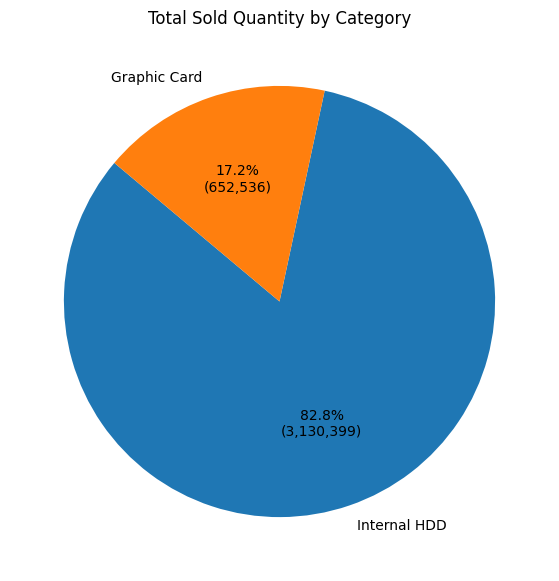

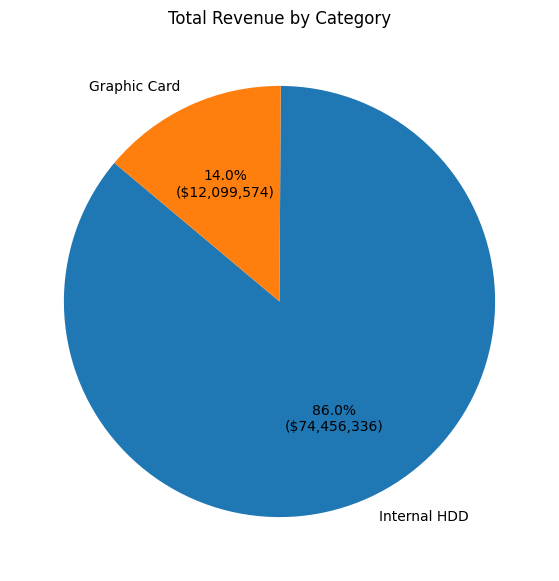

In [67]:
# Plotting Total Sold Quantity Pie Chart
plt.figure(figsize=(10, 7))
plt.pie(sales_volume_revenue_by_category['total_sold_quantity'], 
        labels=sales_volume_revenue_by_category['category'], 
        autopct=lambda p: '{:.1f}%\n({:,.0f})'.format(p, p * sum(sales_volume_revenue_by_category['total_sold_quantity']) / 100), 
        startangle=140)
plt.title('Total Sold Quantity by Category')
plt.show()

# Plotting Total Revenue Pie Chart
plt.figure(figsize=(10, 7))
plt.pie(sales_volume_revenue_by_category['total_revenue'], 
        labels=sales_volume_revenue_by_category['category'], 
        autopct=lambda p: '{:.1f}%\n(${:,.0f})'.format(p, p * sum(sales_volume_revenue_by_category['total_revenue']) / 100), 
        startangle=140)
plt.title('Total Revenue by Category')
plt.show()

Internal HDDs are much more popular and profitable than Graphic Cards. Internal HDDs have over 3.1 million units sold, generating about 74.46 million dollars in revenue. In comparison, Graphic Cards sold around 652,536 units, with a revenue of about 12.10 million dollars. This suggests that Internal HDDs are a key product category, and the company might benefit from focusing more on this area, either by expanding its range of products or enhancing marketing strategies to capitalize on its strong performance.

In [68]:
# Calculating total sales volume and revenue by product
query = """
SELECT
    product,
    SUM(sold_quantity) AS total_sold_quantity,
    ROUND(SUM(sold_quantity * gross_price), 2) AS total_revenue
FROM 
(SELECT
    c.date,
    c.fiscal_year,
    c.month_number,
    c.product_code,
    c.product,
    c.variant,
    c.division,
    c.category,
    c.segment,
    c.sold_quantity,
    fgp.gross_price
FROM
    (SELECT 
        fsm.date AS date,
        fsm.fiscal_year AS fiscal_year,
        strftime('%m', fsm.date) AS month_number,
        fsm.product_code AS product_code,
        dp.product AS product,
        dp.variant AS variant,
        dp.division AS division,
        dp.category AS category,
        dp.segment AS segment,
        fsm.sold_quantity AS sold_quantity
     FROM 
        (SELECT 
            date,
            product_code,
            customer_code,
            sold_quantity,
            fiscal_year
         FROM 
            Fact_sales_monthly
         WHERE
            date IS NOT NULL AND
            product_code IS NOT NULL AND
            customer_code IS NOT NULL AND
            sold_quantity IS NOT NULL AND
            fiscal_year IS NOT NULL) fsm
     INNER JOIN
        (SELECT
            product_code,
            TRIM(product) AS product,
            division,  
            category,
            segment,
            TRIM(variant) AS variant
         FROM 
            dim_product) dp ON fsm.product_code = dp.product_code) c
INNER JOIN
    fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
ORDER BY
    c.date, c.product_code) AS ajoined_data
GROUP BY
    product
ORDER BY
    total_revenue DESC;
"""

sales_volume_revenue_by_product = pd.read_sql_query(query, con)
sales_volume_revenue_by_product

,product,total_sold_quantity,total_revenue
0,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,1075354,26003959.68
1,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,1211581,25433048.27
2,AQ Zion Saga,843464,23019325.80
3,AQ Mforce Gen X,652536,12099575.31


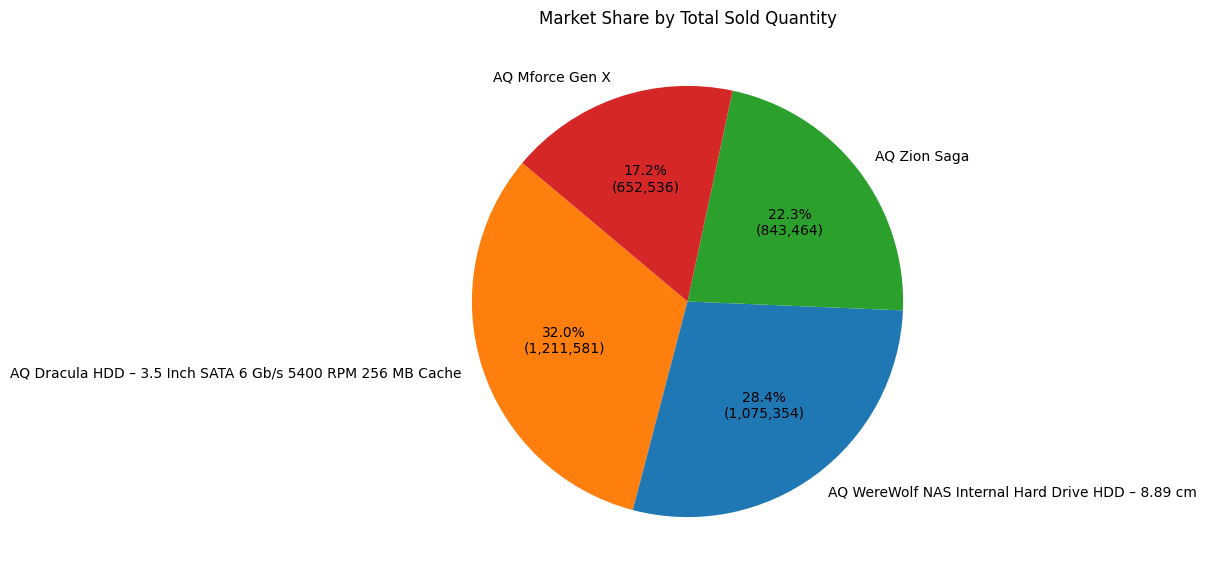

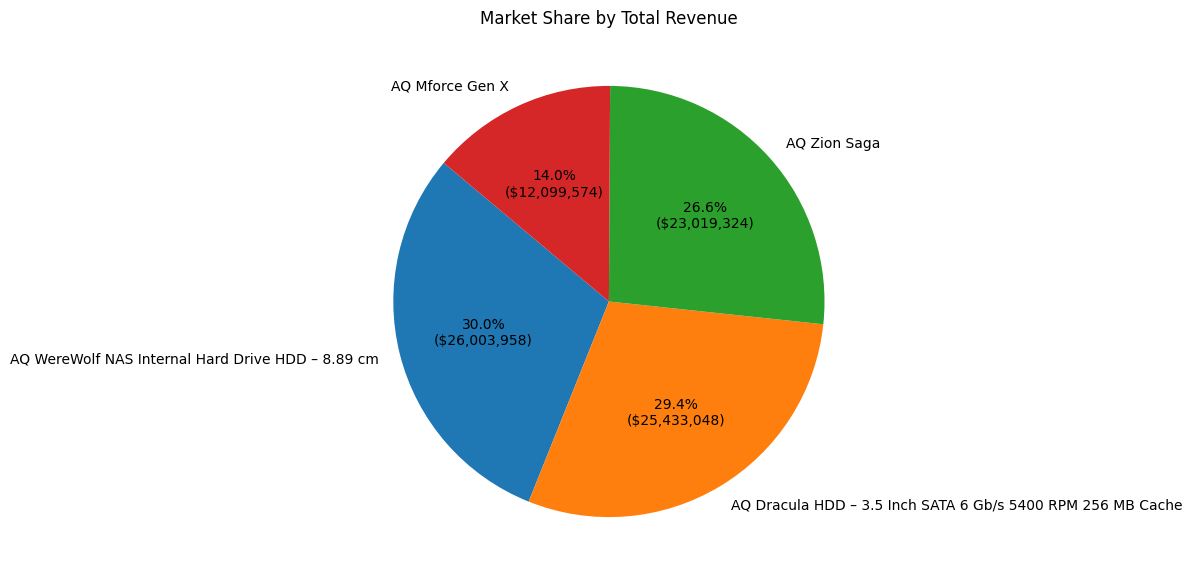

In [69]:
# Ensure the DataFrame is correctly loaded as sales_volume_revenue_by_product
df = sales_volume_revenue_by_product

# Define the order of products for consistent coloring
product_order = df['product'].unique()

# Define a consistent color palette
colors = plt.cm.tab10(range(len(product_order)))

# Create a mapping of products to colors
product_color_map = dict(zip(product_order, colors))

# Sort the DataFrame by total_sold_quantity in descending order
df_sorted_quantity = df.sort_values(by='total_sold_quantity', ascending=False)
df_sorted_quantity['color'] = df_sorted_quantity['product'].map(product_color_map)

# Sort the DataFrame by total_revenue in descending order
df_sorted_revenue = df.sort_values(by='total_revenue', ascending=False)
df_sorted_revenue['color'] = df_sorted_revenue['product'].map(product_color_map)

# Plotting Total Sold Quantity Pie Chart
plt.figure(figsize=(10, 7))
plt.pie(df_sorted_quantity['total_sold_quantity'], labels=df_sorted_quantity['product'], 
        autopct=lambda p: '{:.1f}%\n({:,.0f})'.format(p, p * sum(df_sorted_quantity['total_sold_quantity']) / 100), 
        startangle=140, colors=df_sorted_quantity['color'])
plt.title('Market Share by Total Sold Quantity')
plt.show()

# Plotting Total Revenue Pie Chart
plt.figure(figsize=(10, 7))
plt.pie(df_sorted_revenue['total_revenue'], labels=df_sorted_revenue['product'], 
        autopct=lambda p: '{:.1f}%\n(${:,.0f})'.format(p, p * sum(df_sorted_revenue['total_revenue']) / 100), 
        startangle=140, colors=df_sorted_revenue['color'])
plt.title('Market Share by Total Revenue')
plt.show()

The "AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache" has the highest total sales volume, indicating it has been the most popular product in terms of units sold. However, the "AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm" generated the most revenue, making it a strong contender for the best-selling product overall.

While "AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm" did not have the highest sales volume, it generated the most revenue. This suggests it might be priced higher or has a higher profit margin compared to the other products.

The "AQ Zion Saga" and "AQ Mforce Gen X" also performed well, with substantial sales volumes and revenues. This indicates a diversified product portfolio contributing to overall sales.

It's important to note that these conclusions are based on historical data spanning the last five years. The market dynamics and consumer preferences may have shifted over time. Therefore, it's crucial to conduct further analysis on recent data to understand current trends and ensure the company's product strategies are aligned with the latest market demands.

In [70]:
#Retrieving sales volume and revenue data by product variant
query = """
SELECT
    product,
    variant,
    SUM(sold_quantity) AS total_sold_quantity,
    ROUND(SUM(sold_quantity * gross_price), 2) AS total_revenue
FROM 
(SELECT
    c.date,
    c.fiscal_year,
    c.month_number,
    c.product_code,
    c.product,
    c.variant,
    c.division,
    c.category,
    c.segment,
    c.sold_quantity,
    fgp.gross_price
FROM
    (SELECT 
        fsm.date AS date,
        fsm.fiscal_year AS fiscal_year,
        strftime('%m', fsm.date) AS month_number,
        fsm.product_code AS product_code,
        dp.product AS product,
        dp.variant AS variant,
        dp.division AS division,
        dp.category AS category,
        dp.segment AS segment,
        fsm.sold_quantity AS sold_quantity
     FROM 
        (SELECT 
            date,
            product_code,
            customer_code,
            sold_quantity,
            fiscal_year
         FROM 
            Fact_sales_monthly
         WHERE
            date IS NOT NULL AND
            product_code IS NOT NULL AND
            customer_code IS NOT NULL AND
            sold_quantity IS NOT NULL AND
            fiscal_year IS NOT NULL) fsm
     INNER JOIN
        (SELECT
            product_code,
            TRIM(product) AS product,
            division,  
            category,
            segment,
            TRIM(variant) AS variant
         FROM 
            dim_product) dp ON fsm.product_code = dp.product_code) c
INNER JOIN
    fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
ORDER BY
    c.date, c.product_code) AS ajoined_data
GROUP BY
    product,
    category,
    segment,
    division,
    variant
ORDER BY
    total_revenue DESC;
"""

sales_volume_revenue_variant = pd.read_sql_query(query, con)
sales_volume_revenue_variant

,product,variant,total_sold_quantity,total_revenue
0,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Plus,370148,9028654.63
1,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Standard,378195,8875081.88
2,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Premium Plus,386569,8603684.42
3,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Premium,380146,8513646.22
4,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Premium,327011,8100223.16
5,AQ Mforce Gen X,Standard 3,399751,7887871.22
6,AQ Zion Saga,Standard,319568,7818967.85
7,AQ Zion Saga,Plus,268082,7670057.83
8,AQ Zion Saga,Premium,255814,7530300.11
9,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Plus,221924,4504476.97


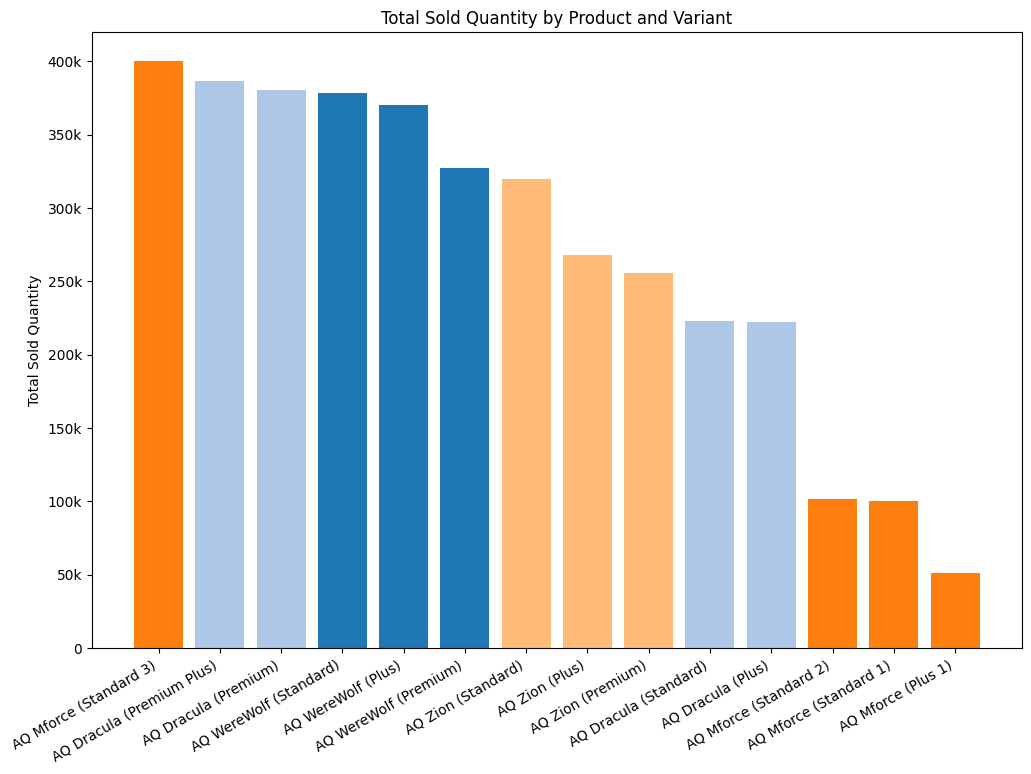

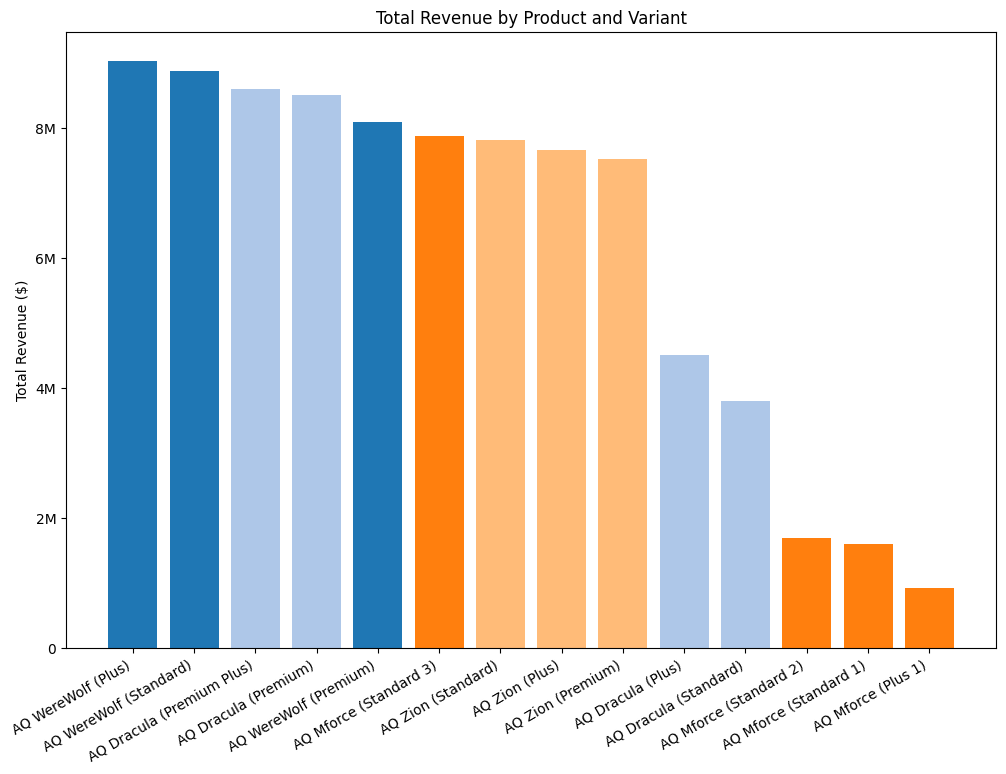

In [71]:
# Assuming your DataFrame is named df
df = sales_volume_revenue_variant

# Create more detailed short labels including full variant names
df['short_label'] = df['product'].str.split().str[:2].str.join(' ') + ' (' + df['variant'] + ')'

# Generate a color map for products
unique_products = df['product'].unique()
colors = plt.cm.tab20.colors[:len(unique_products)]
color_map = dict(zip(unique_products, colors))

# Assign colors based on product
df['color'] = df['product'].map(color_map)

# Sort the DataFrame by total_sold_quantity in descending order for the vertical bar chart
df_sorted_quantity = df.sort_values('total_sold_quantity', ascending=False)

# Plotting Total Sold Quantity
plt.figure(figsize=(12, 8))
bars = plt.bar(df_sorted_quantity['short_label'], df_sorted_quantity['total_sold_quantity'], color=df_sorted_quantity['color'])
plt.ylabel('Total Sold Quantity')
plt.title('Total Sold Quantity by Product and Variant')
plt.xticks(rotation=30, ha='right')

# Format the y-axis labels to show 'k' for thousands
ax = plt.gca()  # Get current axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}k'.format(x/1000) if x >= 1000 else '{:,.0f}'.format(x)))

plt.show()

# Sort the DataFrame by total_revenue in descending order for the vertical bar chart
df_sorted_revenue = df.sort_values('total_revenue', ascending=False)

# Plotting Total Revenue
plt.figure(figsize=(12, 8))
bars = plt.bar(df_sorted_revenue['short_label'], df_sorted_revenue['total_revenue'], color=df_sorted_revenue['color'])
plt.ylabel('Total Revenue ($)')
plt.title('Total Revenue by Product and Variant')
plt.xticks(rotation=30, ha='right')

# Format the y-axis labels to show 'M' for millions
ax = plt.gca()  # Get current axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}M'.format(x/1e6) if x >= 1e6 else '{:,.0f}'.format(x)))

plt.show()

The AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm series, particularly the Plus and Standard variants, show high sales volumes and total revenue, indicating a strong market presence and customer preference for these products.

The AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache series, especially the Premium Plus and Premium variants, also show significant revenue generation, highlighting their popularity and profitability.

Within each product series, certain variants like Premium Plus and Premium for AQ Dracula HDD and Standard for AQ Zion Saga are more popular, suggesting customer preference for higher-end models with potentially better features.

The lower sales and revenue figures for variants like AQ Mforce Gen X Standard 2 and Standard 1 suggest areas where the company might need to increase marketing efforts or reconsider product positioning.

#### Conclusion

The analysis of AtliQ Hardware's product sales data reveals that Internal HDDs significantly outperform Graphic Cards in both popularity and profitability. Internal HDDs have achieved over 3.1 million units sold, generating approximately 74.46 million dollars in revenue. In contrast, Graphic Cards have sold around 652,536 units, with a revenue of about 12.10 million dollars. This highlights Internal HDDs as a critical product category, suggesting the company could benefit from expanding this range or enhancing marketing strategies to capitalize on its strong performance.

Among the Internal HDDs, the "AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache" has the highest total sales volume, indicating it is the most popular product by units sold. However, the "AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm" generates the most revenue, suggesting a higher price point or profit margin, making it a strong overall best-seller.

The "AQ Zion Saga" and "AQ Mforce Gen X" also show substantial sales volumes and revenues, highlighting a diverse product portfolio. Premium variants like the "AQ Dracula HDD – Premium Plus" and "AQ Zion Saga – Standard" are particularly popular, reflecting a preference for higher-end models with enhanced features.

Some variants, such as the "AQ Mforce Gen X Standard 2" and "Standard 1," have lower sales and revenue figures, suggesting potential areas for increased marketing efforts or re-evaluation of product positioning.

These findings are based on data from the past five years. It's important to analyze more recent data to ensure that the company's product strategies are aligned with current market trends and consumer preferences.

## Stage 3. Sales Improvement Analysis<a id='sales_improvement'></a> 

Next, we will join the comprehensive dataset with the fact_pre_discount table. This will enable us to examine the impact of discounts on sales volume and revenue, providing insights into how discounts influence purchasing behavior.

In [72]:
# Merging compehensive data with discount information
query = """
SELECT 
    c.date,
    c.fiscal_year,
    c.month_number,
    c.product_code,
    c.customer_code,
    c.product,
    c.variant,
    c.category,
    c.sold_quantity,
    fpd.pre_invoice_discount_pct
FROM 
    (SELECT
        fsm.date,
        fsm.fiscal_year,
        strftime('%m', fsm.date) AS month_number,
        fsm.product_code,
        fsm.customer_code,
        dp.product,
        dp.variant,
        dp.division,  
        dp.category,  
        dp.segment,
        fsm.sold_quantity
     FROM 
        (SELECT 
            date(date) AS date,  
            product_code,
            customer_code,
            sold_quantity,
            fiscal_year
         FROM 
            Fact_sales_monthly
         WHERE
            date IS NOT NULL AND
            product_code IS NOT NULL AND
            customer_code IS NOT NULL AND
            sold_quantity IS NOT NULL AND
            fiscal_year IS NOT NULL) fsm
     INNER JOIN
        (SELECT
            product_code,
            TRIM(product) AS product,
            division,  
            category,
            segment,
            TRIM(variant) AS variant
         FROM 
            dim_product) dp ON fsm.product_code = dp.product_code
     ORDER BY
        fsm.date, fsm.product_code) c
INNER JOIN 
    fact_pre_discount fpd
ON 
    c.customer_code = fpd.customer_code AND c.fiscal_year = fpd.fiscal_year
ORDER BY 
    c.date, c.product_code;
"""

sales_discount_merged = pd.read_sql_query(query, con)
sales_discount_merged

,date,fiscal_year,month_number,product_code,customer_code,product,variant,category,sold_quantity,pre_invoice_discount_pct
0,2017-09-01,2018,09,A0118150101,70002017,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,Internal HDD,51,0.0824
1,2017-09-01,2018,09,A0118150101,70002018,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,Internal HDD,77,0.2956
2,2017-09-01,2018,09,A0118150101,70003181,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,Internal HDD,17,0.0536
3,2017-09-01,2018,09,A0118150101,70003182,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,Internal HDD,6,0.2378
4,2017-09-01,2018,09,A0118150101,70006157,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,Internal HDD,5,0.1057
...,...,...,...,...,...,...,...,...,...,...
67245,2021-12-01,2022,12,A0418150103,90023028,AQ Mforce Gen X,Standard 3,Graphic Card,168,0.2842
67246,2021-12-01,2022,12,A0418150103,90023030,AQ Mforce Gen X,Standard 3,Graphic Card,545,0.1923
67247,2021-12-01,2022,12,A0418150103,90024183,AQ Mforce Gen X,Standard 3,Graphic Card,38,0.1809
67248,2021-12-01,2022,12,A0418150103,90024184,AQ Mforce Gen X,Standard 3,Graphic Card,51,0.2453


In [73]:
# Calculating average discount and total sold quantity per product
query = """
SELECT 
    product,
    AVG(pre_invoice_discount_pct) AS average_discount_pct,
    SUM(sold_quantity) AS total_sold_quantity
FROM 
    (SELECT 
        c.date,
        c.fiscal_year,
        c.month_number,
        c.product_code,
        c.customer_code,
        c.product,
        c.variant,
        c.category,
        c.sold_quantity,
        fpd.pre_invoice_discount_pct
    FROM 
        (SELECT
            fsm.date,
            fsm.fiscal_year,
            strftime('%m', fsm.date) AS month_number,
            fsm.product_code,
            fsm.customer_code,
            dp.product,
            dp.variant,
            dp.division,  
            dp.category,  
            dp.segment,
            fsm.sold_quantity
        FROM 
            (SELECT 
                date(date) AS date,  
                product_code,
                customer_code,
                sold_quantity,
                fiscal_year
            FROM 
                Fact_sales_monthly
            WHERE
                date IS NOT NULL AND
                product_code IS NOT NULL AND
                customer_code IS NOT NULL AND
                sold_quantity IS NOT NULL AND
                fiscal_year IS NOT NULL) fsm
        INNER JOIN
            (SELECT
                product_code,
                TRIM(product) AS product,
                division,  
                category,
                segment,
                TRIM(variant) AS variant
            FROM 
                dim_product) dp ON fsm.product_code = dp.product_code
        ORDER BY
            fsm.date, fsm.product_code) c
    INNER JOIN 
        fact_pre_discount fpd
    ON 
        c.customer_code = fpd.customer_code AND c.fiscal_year = fpd.fiscal_year
    ORDER BY 
        c.date, c.product_code
    )
GROUP BY 
    product
ORDER BY 
    total_sold_quantity DESC;
"""

discount_sales_summary = pd.read_sql_query(query, con)
discount_sales_summary

,product,average_discount_pct,total_sold_quantity
0,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,0.232179,1211581
1,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,0.232593,1075354
2,AQ Zion Saga,0.233981,843464
3,AQ Mforce Gen X,0.231366,652536


As observed, each product currently has the same discount percentage. Let's delve deeper and examine the discount percentages for all product variants to understand if there are any differences or patterns.

In [74]:
# Calculating average discount and total sold quantity per product variant and category
query = """
SELECT 
    product,
    variant,
    category,
    AVG(pre_invoice_discount_pct) AS average_discount_pct,
    SUM(sold_quantity) AS total_sold_quantity
FROM 
    (SELECT 
        c.date,
        c.fiscal_year,
        c.month_number,
        c.product_code,
        c.customer_code,
        c.product,
        c.variant,
        c.category,
        c.sold_quantity,
        fpd.pre_invoice_discount_pct
    FROM 
        (SELECT
            fsm.date,
            fsm.fiscal_year,
            strftime('%m', fsm.date) AS month_number,
            fsm.product_code,
            fsm.customer_code,
            dp.product,
            dp.variant,
            dp.division,  
            dp.category,  
            dp.segment,
            fsm.sold_quantity
        FROM 
            (SELECT 
                date(date) AS date,  
                product_code,
                customer_code,
                sold_quantity,
                fiscal_year
            FROM 
                Fact_sales_monthly
            WHERE
                date IS NOT NULL AND
                product_code IS NOT NULL AND
                customer_code IS NOT NULL AND
                sold_quantity IS NOT NULL AND
                fiscal_year IS NOT NULL) fsm
        INNER JOIN
            (SELECT
                product_code,
                TRIM(product) AS product,
                division,  
                category,
                segment,
                TRIM(variant) AS variant
            FROM 
                dim_product) dp ON fsm.product_code = dp.product_code
        ORDER BY
            fsm.date, fsm.product_code) c
    INNER JOIN 
        fact_pre_discount fpd
    ON 
        c.customer_code = fpd.customer_code AND c.fiscal_year = fpd.fiscal_year
    ORDER BY 
        c.date, c.product_code
    )
GROUP BY 
    product,  
    variant,
    category
ORDER BY 
    total_sold_quantity DESC;
"""

discount_sales_summary = pd.read_sql_query(query, con)
discount_sales_summary

,product,variant,category,average_discount_pct,total_sold_quantity
0,AQ Mforce Gen X,Standard 3,Graphic Card,0.232316,399751
1,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Premium Plus,Internal HDD,0.232313,386569
2,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Premium,Internal HDD,0.232356,380146
3,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Standard,Internal HDD,0.232235,378195
4,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Plus,Internal HDD,0.232193,370148
5,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Premium,Internal HDD,0.233603,327011
6,AQ Zion Saga,Standard,Internal HDD,0.233752,319568
7,AQ Zion Saga,Plus,Internal HDD,0.234178,268082
8,AQ Zion Saga,Premium,Internal HDD,0.234178,255814
9,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,Internal HDD,0.231964,222942


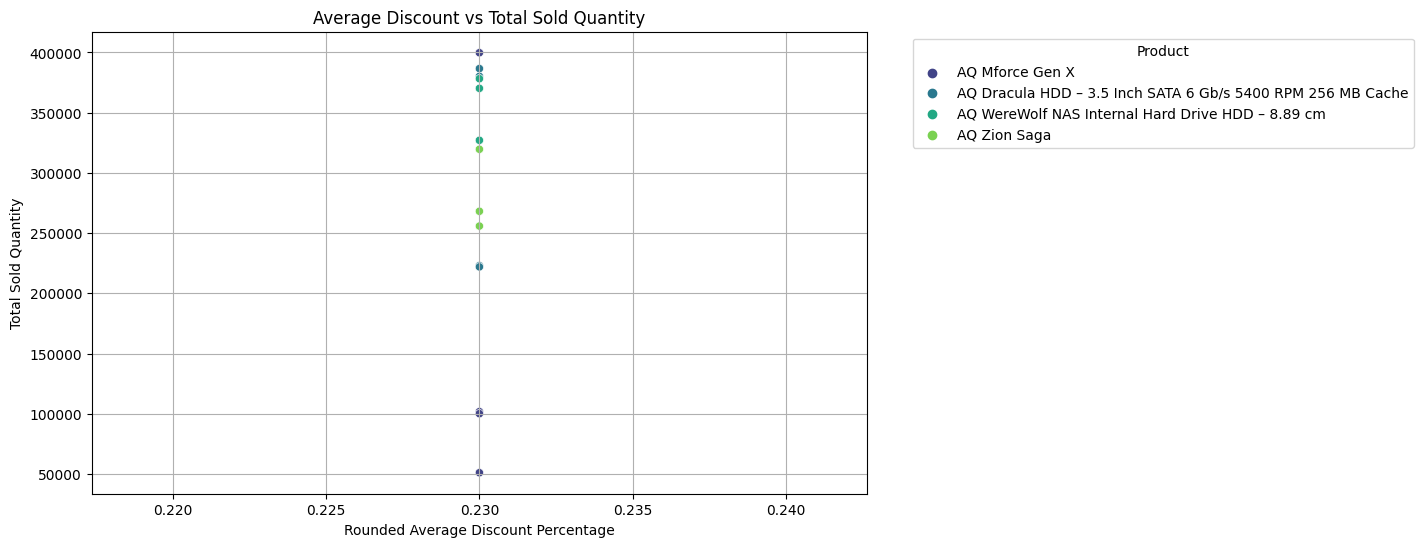

In [75]:
# Assuming the DataFrame is named discount_sales_summary
df = discount_sales_summary.copy()

# Round the average discount percentage to two decimal places
df['rounded_discount_pct'] = df['average_discount_pct'].round(2)

# Scatter plot for Rounded Average Discount vs Total Sold Quantity
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['rounded_discount_pct'], y=df['total_sold_quantity'], hue=df['product'], palette='viridis')
plt.title('Average Discount vs Total Sold Quantity')
plt.xlabel('Rounded Average Discount Percentage')
plt.ylabel('Total Sold Quantity')
plt.grid(True)
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

It appears that the discount percentages are indeed very similar across different products and variants. This might indicate a uniform discount policy applied by AtliQ Hardware. So as we can see there is no significant relationship between the discounts and the sales volume.

Now, we will join the fact_gross_price and fact_manufacturing_cost tables. This will allow us to calculate the profit margin for each product. By comparing gross prices and manufacturing costs with sales performance, we can evaluate the effectiveness of current pricing strategies and identify potential areas for optimization.

In [76]:
# Joining gross price and manufacturing cost data to calculate profit margin
query = """
SELECT 
    fgp.product_code,
    fgp.fiscal_year,
    fgp.gross_price,
    fmc.manufacturing_cost,
    (fgp.gross_price - fmc.manufacturing_cost) AS profit_margin
FROM 
    fact_gross_price fgp
INNER JOIN 
    fact_manufacturing_cost fmc ON fgp.product_code = fmc.product_code AND fgp.fiscal_year = fmc.cost_year
"""
pricing_dataset = pd.read_sql_query(query, con)
pricing_dataset

,product_code,fiscal_year,gross_price,manufacturing_cost,profit_margin
0,A0118150101,2018,15.3952,4.6190,10.7762
1,A0118150101,2019,14.4392,4.2033,10.2359
2,A0118150101,2020,16.2323,5.0207,11.2116
3,A0118150101,2021,19.0573,5.5172,13.5401
4,A0118150102,2018,19.5875,5.6036,13.9839
...,...,...,...,...,...
1177,A7321160301,2022,44.6260,13.4069,31.2191
1178,A7321160302,2021,43.9446,12.5670,31.3776
1179,A7321160302,2022,46.0399,13.1954,32.8445
1180,A7321160303,2021,42.8483,12.9502,29.8981


In [77]:
# Merging sales and pricing data to analyze profit margins and sales performance
query = """
SELECT
    cd.date,
    cd.fiscal_year,
    cd.month_number,
    cd.product_code,
    cd.product,
    cd.variant,
    cd.division,
    cd.category,
    cd.segment,
    cd.sold_quantity,
    pd.gross_price,
    pd.manufacturing_cost,
    pd.profit_margin
FROM
    (SELECT
        fsm.date,
        fsm.fiscal_year,
        strftime('%m', fsm.date) AS month_number,
        fsm.product_code,
        dp.product,
        dp.variant,
        dp.division,  
        dp.category,  
        dp.segment,
        fsm.sold_quantity
     FROM
        (SELECT 
            date(date) AS date,  
            product_code,
            customer_code,
            sold_quantity,
            fiscal_year
         FROM 
            Fact_sales_monthly
         WHERE
            date IS NOT NULL AND
            product_code IS NOT NULL AND
            customer_code IS NOT NULL AND
            sold_quantity IS NOT NULL AND
            fiscal_year IS NOT NULL) fsm
     INNER JOIN
        (SELECT
            product_code,
            TRIM(product) AS product,
            division,  
            category,
            segment,
            TRIM(variant) AS variant
         FROM 
            dim_product) dp ON fsm.product_code = dp.product_code
     ORDER BY
        fsm.date, fsm.product_code) cd
INNER JOIN
    (SELECT 
        fgp.product_code,
        fgp.fiscal_year,
        fgp.gross_price,
        fmc.manufacturing_cost,
        (fgp.gross_price - fmc.manufacturing_cost) AS profit_margin
     FROM 
        fact_gross_price fgp
     INNER JOIN 
        fact_manufacturing_cost fmc ON fgp.product_code = fmc.product_code AND fgp.fiscal_year = fmc.cost_year) pd
ON
    cd.product_code = pd.product_code AND cd.fiscal_year = pd.fiscal_year
ORDER BY
    cd.date, cd.product_code;
"""

sales_pricing_merged = pd.read_sql_query(query, con)
sales_pricing_merged

,date,fiscal_year,month_number,product_code,product,variant,division,category,segment,sold_quantity,gross_price,manufacturing_cost,profit_margin
0,2017-09-01,2018,09,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,51,15.3952,4.6190,10.7762
1,2017-09-01,2018,09,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,77,15.3952,4.6190,10.7762
2,2017-09-01,2018,09,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,17,15.3952,4.6190,10.7762
3,2017-09-01,2018,09,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,6,15.3952,4.6190,10.7762
4,2017-09-01,2018,09,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,5,15.3952,4.6190,10.7762
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67245,2021-12-01,2022,12,A0418150103,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,168,21.0913,6.0345,15.0568
67246,2021-12-01,2022,12,A0418150103,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,545,21.0913,6.0345,15.0568
67247,2021-12-01,2022,12,A0418150103,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,38,21.0913,6.0345,15.0568
67248,2021-12-01,2022,12,A0418150103,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,51,21.0913,6.0345,15.0568


In [78]:
# Analyzing profit margins and total profit by product and variant
query = """
SELECT 
    product,
    variant,
    profit_margin,
    SUM(sold_quantity) AS total_sold_quantity,
    ROUND(SUM(sold_quantity * profit_margin),2) AS total_profit
FROM 
    (SELECT
    cd.date,
    cd.fiscal_year,
    cd.month_number,
    cd.product_code,
    cd.product,
    cd.variant,
    cd.division,
    cd.category,
    cd.segment,
    cd.sold_quantity,
    pd.gross_price,
    pd.manufacturing_cost,
    pd.profit_margin
FROM
    (SELECT
        fsm.date,
        fsm.fiscal_year,
        strftime('%m', fsm.date) AS month_number,
        fsm.product_code,
        dp.product,
        dp.variant,
        dp.division,  
        dp.category,  
        dp.segment,
        fsm.sold_quantity
     FROM
        (SELECT 
            date(date) AS date,  
            product_code,
            customer_code,
            sold_quantity,
            fiscal_year
         FROM 
            Fact_sales_monthly
         WHERE
            date IS NOT NULL AND
            product_code IS NOT NULL AND
            customer_code IS NOT NULL AND
            sold_quantity IS NOT NULL AND
            fiscal_year IS NOT NULL) fsm
     INNER JOIN
        (SELECT
            product_code,
            TRIM(product) AS product,
            division,  
            category,
            segment,
            TRIM(variant) AS variant
         FROM 
            dim_product) dp ON fsm.product_code = dp.product_code
     ORDER BY
        fsm.date, fsm.product_code) cd
INNER JOIN
    (SELECT 
        fgp.product_code,
        fgp.fiscal_year,
        fgp.gross_price,
        fmc.manufacturing_cost,
        (fgp.gross_price - fmc.manufacturing_cost) AS profit_margin
     FROM 
        fact_gross_price fgp
     INNER JOIN 
        fact_manufacturing_cost fmc ON fgp.product_code = fmc.product_code AND fgp.fiscal_year = fmc.cost_year) pd
ON
    cd.product_code = pd.product_code AND cd.fiscal_year = pd.fiscal_year
ORDER BY
    cd.date, cd.product_code) AS sales_pricing
GROUP BY 
    product, variant
ORDER BY 
    product, profit_margin DESC;
"""

profit_margin_analysis = pd.read_sql_query(query, con)
profit_margin_analysis

,product,variant,profit_margin,total_sold_quantity,total_profit
0,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Plus,13.9839,221924,3198627.54
1,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Premium Plus,13.6785,386569,5973455.70
2,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Premium,13.4161,380146,5984860.00
3,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,10.7762,222942,2683754.11
4,AQ Mforce Gen X,Plus 1,13.2791,51007,647409.43
5,AQ Mforce Gen X,Standard 3,12.6070,399751,5590255.04
6,AQ Mforce Gen X,Standard 2,11.6199,101725,1182072.83
7,AQ Mforce Gen X,Standard 1,11.1040,100053,1123386.85
8,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Premium,16.8572,327011,5701184.82
9,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Plus,14.5857,370148,6399013.73


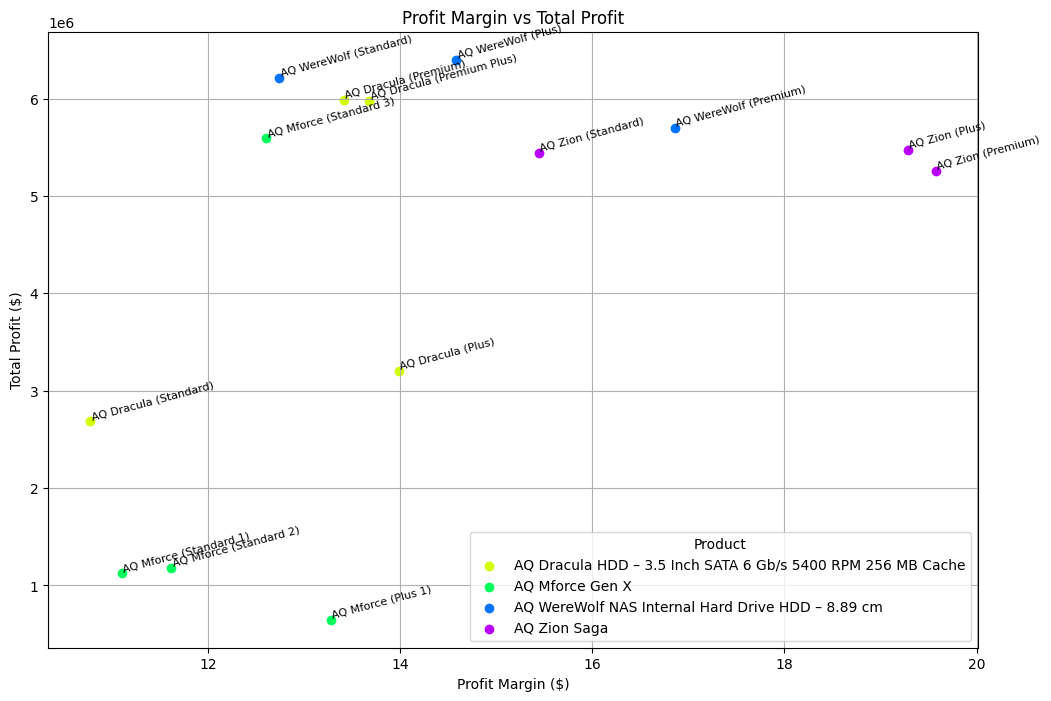

In [79]:
# Sample data, assuming the DataFrame is named profit_margin_analysis
df = profit_margin_analysis

# Generate more detailed short labels including full variant names
df['short_label'] = df['product'].str.split().str[:2].str.join(' ') + ' (' + df['variant'] + ')'

# Define a color palette for the products
palette = sns.color_palette("hsv", len(df['product'].unique()))
product_colors = dict(zip(df['product'].unique(), palette))

# Scatter plot for Profit Margin vs Total Profit
plt.figure(figsize=(12, 8))
for product, color in product_colors.items():
    product_data = df[df['product'] == product]
    plt.scatter(product_data['profit_margin'], product_data['total_profit'], label=product, color=color)

plt.title('Profit Margin vs Total Profit')
plt.xlabel('Profit Margin ($)')
plt.ylabel('Total Profit ($)')
plt.grid(True)

# Adding labels for each point with rotation
for i, txt in enumerate(df['short_label']):
    plt.annotate(txt, (df['profit_margin'][i], df['total_profit'][i]), fontsize=8, ha='left', va='bottom', rotation=15)

plt.legend(title='Product')
plt.show()

Analyzing pricing data specifically for 2022 would provide a more accurate and relevant picture, especially considering that some products or variants may have been discontinued or introduced in recent years.

In [80]:
# Analyzing profit margins and total profit by product and variant for 2022
query = """
SELECT 
    product,
    variant,
    profit_margin,
    SUM(sold_quantity) AS total_sold_quantity,
    ROUND(SUM(sold_quantity * profit_margin), 2) AS total_profit
FROM 
    (SELECT
        fsm.date AS date,
        fsm.fiscal_year AS fiscal_year,
        strftime('%m', fsm.date) AS month_number,
        fsm.product_code AS product_code,
        dp.product AS product,
        dp.variant AS variant,
        dp.division AS division,  
        dp.category AS category,  
        dp.segment AS segment,
        fsm.sold_quantity AS sold_quantity,
        fgp.gross_price AS gross_price,
        fmc.manufacturing_cost AS manufacturing_cost,
        (fgp.gross_price - fmc.manufacturing_cost) AS profit_margin
    FROM 
        Fact_sales_monthly fsm
    INNER JOIN
        dim_product dp ON fsm.product_code = dp.product_code
    INNER JOIN
        fact_gross_price fgp ON fsm.product_code = fgp.product_code AND fsm.fiscal_year = fgp.fiscal_year
    INNER JOIN
        fact_manufacturing_cost fmc ON fsm.product_code = fmc.product_code AND fsm.fiscal_year = fmc.cost_year
    WHERE
        fsm.fiscal_year = 2022
    ) AS sales_pricing
GROUP BY 
    product, variant
ORDER BY 
    product, total_profit DESC;
"""

profit_margin_analysis_2022 = pd.read_sql_query(query, con)
profit_margin_analysis_2022

,product,variant,profit_margin,total_sold_quantity,total_profit
0,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Premium,16.8089,162972,2739380.05
1,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Premium Plus,16.2643,166735,2711828.06
2,AQ Mforce Gen X,Standard 3,15.0568,218083,3283632.11
3,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Premium,18.3507,165516,3037334.46
4,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Plus,17.8766,169156,3023934.15
5,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Standard,17.4853,172000,3007471.60
6,AQ Zion Saga,Plus,21.0661,168127,3541780.19
7,AQ Zion Saga,Premium,21.1183,159123,3360407.25
8,AQ Zion Saga,Standard,18.0928,157906,2856961.68


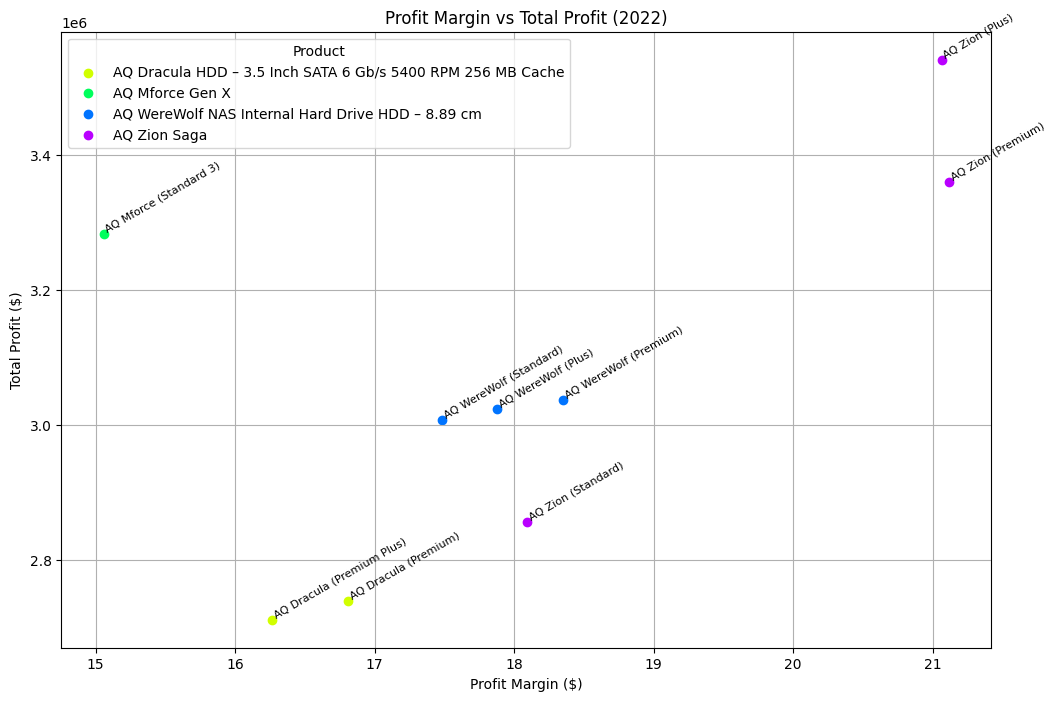

In [81]:
# Sample data, assuming the DataFrame is named profit_margin_analysis_2022
df = profit_margin_analysis_2022

# Generate more detailed short labels including full variant names
df['short_label'] = df['product'].str.split().str[:2].str.join(' ') + ' (' + df['variant'] + ')'

# Define a color palette for the products
palette = sns.color_palette("hsv", len(df['product'].unique()))
product_colors = dict(zip(df['product'].unique(), palette))

# Scatter plot for Profit Margin vs Total Profit
plt.figure(figsize=(12, 8))
for product, color in product_colors.items():
    product_data = df[df['product'] == product]
    plt.scatter(product_data['profit_margin'], product_data['total_profit'], label=product, color=color)

plt.title('Profit Margin vs Total Profit (2022)')
plt.xlabel('Profit Margin ($)')
plt.ylabel('Total Profit ($)')
plt.grid(True)

# Adding labels for each point with rotation
for i, txt in enumerate(df['short_label']):
    plt.annotate(txt, (df['profit_margin'][i], df['total_profit'][i]), fontsize=8, ha='left', va='bottom', rotation=30)

plt.legend(title='Product')
plt.show()

The 2022-specific analysis highlights a clearer focus on profitability, with a noticeable shift towards promoting higher-margin products. The multi-year data included a broader range of products and variants, some of which may no longer be in focus. The current analysis provides a sharper view of the products that are currently contributing most significantly to the company's profitability.

AQ Zion Saga: The Plus and Premium variants show the highest profit margins, with the Plus and Premium variant achieving a margin more than 21 dollar per unit. These variants also lead in total profit, with the Plus variant generating approximately 3.5 million dollars. This suggests a successful premium pricing strategy and strong market demand for these higher-end variants.

AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm: This product line displays consistent performance across its variants, with profit margins ranging from 17.5 to 18.5 dollars per unit. The total profits for these variants are all around 3 million dollars, indicating robust sales and profitability.

AQ Mforce Gen X: In 2022, it was represented by only one product variant. Despite having the lowest profit margin per unit in the entire product line, it still achieved the third highest total profit overall.

AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache: The Premium and Premium Plus variants, while maintaining reasonable profit margins, show the lowest total profit compared to other products analyzed. This indicates that these variants may not be performing as strongly in the market. The company's strategy to focus on these higher-margin variants may not be yielding the desired profitability, suggesting a need to reassess the product's positioning or market strategy.

#### Conclusions 

The analysis reveals that AtliQ Hardware appears to have a uniform discount policy across its product range, as the discount percentages are consistent among different products and variants. This uniformity suggests that the company's current discount strategy does not significantly impact sales volumes. Therefore, there's no clear correlation between discounts and sales volumes, indicating that other factors may be influencing purchasing decisions.

**Key Product Insights:**

AQ Zion Saga: The Plus and Premium variants show the highest profit margins, with the Plus and Premium variant achieving a margin more than 21 dollar per unit. These variants also lead in total profit, with the Plus variant generating approximately 3.5 million dollars. This suggests a successful premium pricing strategy and strong market demand for these higher-end variants.

AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm: This product line displays consistent performance across its variants, with profit margins ranging from 17.5 to 18.5 dollars per unit. The total profits for these variants are all around 3 million dollars, indicating robust sales and profitability.

AQ Mforce Gen X: In 2022, it was represented by only one product variant. Despite having the lowest profit margin per unit in the entire product line, it still achieved the third highest total profit overall.

AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache: The Premium and Premium Plus variants, while maintaining reasonable profit margins, show the lowest total profit compared to other products analyzed. This indicates that these variants may not be performing as strongly in the market. The company's strategy to focus on these higher-margin variants may not be yielding the desired profitability, suggesting a need to reassess the product's positioning or market strategy.

**Recommendations:**

Adjust Discount Strategy: tailor discounts based on product demand to stimulate sales of less popular items such as AQ Dracula HDD Premium and Premium Plus variants.

Promote High-Performing Products: continue investing in the AQ Zion Saga Plus and Premium variants, which show strong profitability and demand.

Capitalize on WereWolf NAS Success: explore new features or variants to maintain the strong market position of the AQ WereWolf NAS line.

Reevaluate AQ Dracula HDD: reassess the pricing, features, or marketing approach for the Premium and Premium Plus variants to improve their market performance and profitability. Consider exploring why these products underperform compared to others and adjust the strategy accordingly.

##  Stage 4. Popularity Trends Analysis<a id='trends'></a>

Here, we will perform a time series analysis on the monthly and yearly sales data to identify trends and patterns over time for our product line. This analysis will help us understand seasonal variations, growth trends, and other temporal dynamics affecting our sales.

In [82]:
# Analyzing total sold quantity and total revenue by year
query = """
SELECT
    fiscal_year AS year,
    SUM(sold_quantity) AS total_sold_quantity,
    ROUND(SUM(sold_quantity * gross_price),2) AS total_revenue
FROM 
(SELECT
    c.date,
    c.fiscal_year,
    c.month_number,
    c.product_code,
    c.product,
    c.variant,
    c.division,
    c.category,
    c.segment,
    c.sold_quantity,
    fgp.gross_price
FROM
    (SELECT 
        fsm.date AS date,
        fsm.fiscal_year AS fiscal_year,
        strftime('%m', fsm.date) AS month_number,
        fsm.product_code AS product_code,
        dp.product AS product,
        dp.variant AS variant,
        dp.division AS division,
        dp.category AS category,
        dp.segment AS segment,
        fsm.sold_quantity AS sold_quantity
     FROM 
        (SELECT 
            date,
            product_code,
            customer_code,
            sold_quantity,
            fiscal_year
         FROM 
            Fact_sales_monthly
         WHERE
            date IS NOT NULL AND
            product_code IS NOT NULL AND
            customer_code IS NOT NULL AND
            sold_quantity IS NOT NULL AND
            fiscal_year IS NOT NULL) fsm
     INNER JOIN
        (SELECT
            product_code,
            TRIM(product) AS product,
            division,  
            category,
            segment,
            TRIM(variant) AS variant
         FROM 
            dim_product) dp ON fsm.product_code = dp.product_code) c
INNER JOIN
    fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
ORDER BY
    c.date, c.product_code) AS ajoined_data
GROUP BY
    year
ORDER BY
    total_revenue DESC;
"""
    
yearly_trend_analysis = pd.read_sql_query(query, con)
yearly_trend_analysis

,year,total_sold_quantity,total_revenue
0,2022,1539618,39136207.36
1,2021,1057943,24661170.06
2,2020,640584,13172917.14
3,2019,379519,6641603.64
4,2018,165271,2944010.85


We observe a substantial growth in both total sold quantity and total revenue over the years 2018-2022. Now, we will delve deeper by analyzing the sales performance for each product over the years.

In [83]:
# Executing the query to analyze yearly trends in product sales and revenue
query = """
SELECT
    fiscal_year AS year,
    product,
    SUM(sold_quantity) AS total_sold_quantity,
    ROUND(SUM(sold_quantity * gross_price),2) AS total_revenue
FROM 
(SELECT
    c.date,
    c.fiscal_year,
    c.month_number,
    c.product_code,
    c.product,
    c.variant,
    c.division,
    c.category,
    c.segment,
    c.sold_quantity,
    fgp.gross_price
FROM
    (SELECT 
        fsm.date AS date,
        fsm.fiscal_year AS fiscal_year,
        strftime('%m', fsm.date) AS month_number,
        fsm.product_code AS product_code,
        dp.product AS product,
        dp.variant AS variant,
        dp.division AS division,
        dp.category AS category,
        dp.segment AS segment,
        fsm.sold_quantity AS sold_quantity
     FROM 
        (SELECT 
            date,
            product_code,
            customer_code,
            sold_quantity,
            fiscal_year
         FROM 
            Fact_sales_monthly
         WHERE
            date IS NOT NULL AND
            product_code IS NOT NULL AND
            customer_code IS NOT NULL AND
            sold_quantity IS NOT NULL AND
            fiscal_year IS NOT NULL) fsm
     INNER JOIN
        (SELECT
            product_code,
            TRIM(product) AS product,
            division,  
            category,
            segment,
            TRIM(variant) AS variant
         FROM 
            dim_product) dp ON fsm.product_code = dp.product_code) c
INNER JOIN
    fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
ORDER BY
    c.date, c.product_code) AS ajoined_data
GROUP BY
    year, product
ORDER BY
    year DESC, total_revenue DESC;
"""
    
yearly_product_trend_analysis = pd.read_sql_query(query, con)
yearly_product_trend_analysis

,year,product,total_sold_quantity,total_revenue
0,2022,AQ Zion Saga,485156,13860032.50
1,2022,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,506672,12826581.95
2,2022,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,329707,7849938.93
3,2022,AQ Mforce Gen X,218083,4599653.98
4,2021,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,390575,8319378.85
5,2021,AQ Zion Saga,293806,7721827.52
6,2021,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,295705,7099922.55
7,2021,AQ Mforce Gen X,77857,1520041.14
8,2020,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,249242,4918547.38
9,2020,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,188971,4429404.83


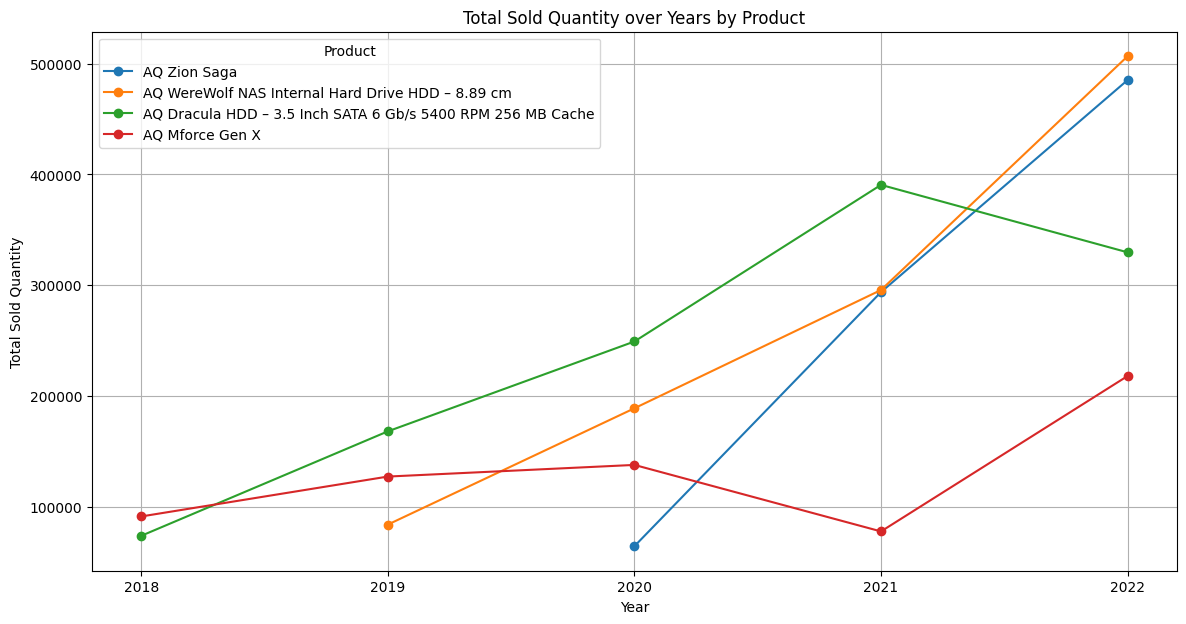

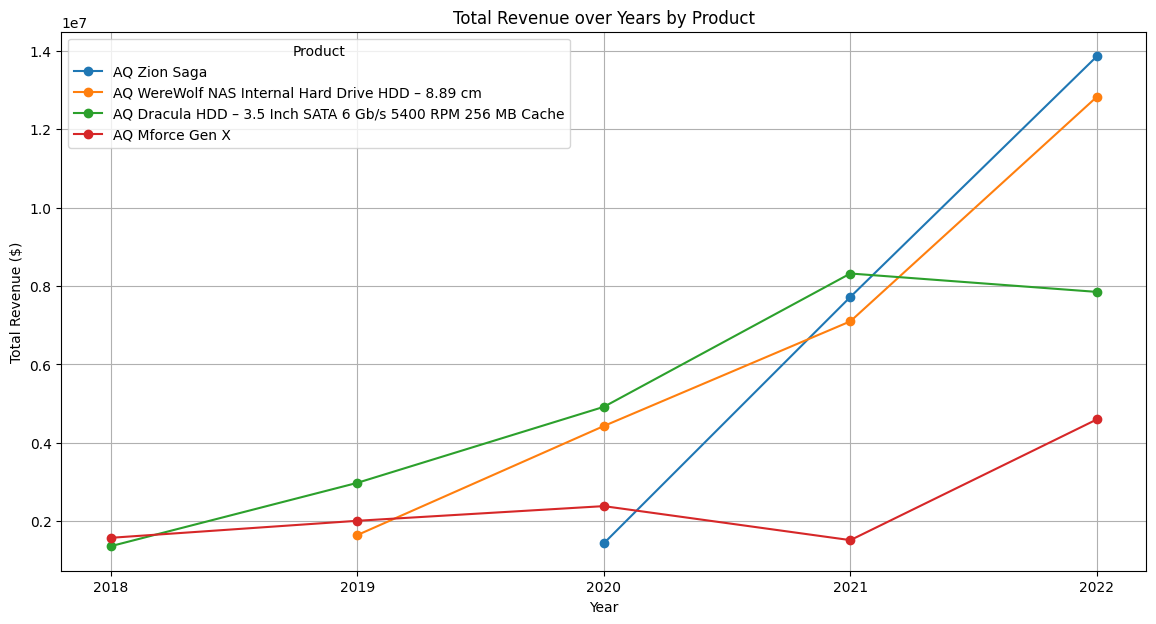

In [84]:
# Sample DataFrame assuming it's named yearly_product_trend_analysis
df = yearly_product_trend_analysis.copy()

# Define the unique years for x-axis ticks
years = sorted(df['year'].unique())

# Plotting Total Sold Quantity over Years for each product
plt.figure(figsize=(14, 7))
for product in df['product'].unique():
    product_data = df[df['product'] == product]
    plt.plot(product_data['year'], product_data['total_sold_quantity'], marker='o', label=product)

plt.title('Total Sold Quantity over Years by Product')
plt.xlabel('Year')
plt.ylabel('Total Sold Quantity')
plt.xticks(years)  # Set the x-axis ticks to the unique years
plt.legend(title='Product')
plt.grid(True)
plt.show()

# Plotting Total Revenue over Years for each product
plt.figure(figsize=(14, 7))
for product in df['product'].unique():
    product_data = df[df['product'] == product]
    plt.plot(product_data['year'], product_data['total_revenue'], marker='o', label=product)

plt.title('Total Revenue over Years by Product')
plt.xlabel('Year')
plt.ylabel('Total Revenue ($)')
plt.xticks(years)  # Set the x-axis ticks to the unique years
plt.legend(title='Product')
plt.grid(True)
plt.show()

Despite being launched relatively recently, 'AQ Zion Saga' in 2020 and 'AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm' in 2019, these products have shown remarkable growth in the subsequent years. They achieved significant sales volumes and revenues, especially by 2022, indicating strong market acceptance and demand.

The 'AQ Mforce Gen X' had lower sales volumes and revenues compared to other products, with a particularly noticeable dip in 2021. However, there was a positive turnaround in 2022, as the product experienced significant growth relative to itself, more than doubling its revenue and sold quantity. On the other hand, the 'AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache' was a market leader until 2021. However, in 2022, it showed a decline in both sales volumes and revenues.

In [85]:
query = """
SELECT
    fiscal_year AS year,
    variant,
    SUM(sold_quantity) AS total_sold_quantity,
    ROUND(SUM(sold_quantity * gross_price), 2) AS total_revenue
FROM
    (SELECT
        c.date,
        c.fiscal_year,
        c.month_number,
        c.product_code,
        c.product,
        c.variant,
        c.division,
        c.category,
        c.segment,
        c.sold_quantity,
        fgp.gross_price
     FROM
        (SELECT 
            fsm.date AS date,
            fsm.fiscal_year AS fiscal_year,
            strftime('%m', fsm.date) AS month_number,
            fsm.product_code AS product_code,
            dp.product AS product,
            dp.variant AS variant,
            dp.division AS division,
            dp.category AS category,
            dp.segment AS segment,
            fsm.sold_quantity AS sold_quantity
         FROM 
            (SELECT 
                date,
                product_code,
                customer_code,
                sold_quantity,
                fiscal_year
             FROM 
                Fact_sales_monthly
             WHERE
                date IS NOT NULL AND
                product_code IS NOT NULL AND
                customer_code IS NOT NULL AND
                sold_quantity IS NOT NULL AND
                fiscal_year IS NOT NULL) fsm
         INNER JOIN
            (SELECT
                product_code,
                TRIM(product) AS product,
                division,  
                category,
                segment,
                TRIM(variant) AS variant
             FROM 
                dim_product) dp ON fsm.product_code = dp.product_code
         WHERE dp.product LIKE 'AQ Mforce Gen X') c
    INNER JOIN
        fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
    WHERE c.fiscal_year IN (2021, 2022)
    ORDER BY c.date, c.product_code) AS filtered_data
GROUP BY year, variant
ORDER BY year, total_revenue DESC;
"""
aq_mforce_by_year = pd.read_sql_query(query, con)
aq_mforce_by_year

,year,variant,total_sold_quantity,total_revenue
0,2021,Standard 3,77857,1520041.14
1,2022,Standard 3,218083,4599653.98


The "AQ Mforce Gen X" product had only one variant, "Standard 3," available in 2021 and 2022. During this period, sales volume and revenue tripled, indicating a significant increase in demand for this product variant.The data indicates that the "AQ Mforce Gen X Standard 3" has become increasingly popular among customers, making it a key product for AtliQ Hardware.

In [86]:
query = """
SELECT
    fiscal_year AS year,
    variant,
    SUM(sold_quantity) AS total_sold_quantity,
    ROUND(SUM(sold_quantity * gross_price), 2) AS total_revenue
FROM
    (SELECT
        c.date,
        c.fiscal_year,
        c.month_number,
        c.product_code,
        c.product,
        c.variant,
        c.division,
        c.category,
        c.segment,
        c.sold_quantity,
        fgp.gross_price
     FROM
        (SELECT 
            fsm.date AS date,
            fsm.fiscal_year AS fiscal_year,
            strftime('%m', fsm.date) AS month_number,
            fsm.product_code AS product_code,
            dp.product AS product,
            dp.variant AS variant,
            dp.division AS division,
            dp.category AS category,
            dp.segment AS segment,
            fsm.sold_quantity AS sold_quantity
         FROM 
            (SELECT 
                date,
                product_code,
                customer_code,
                sold_quantity,
                fiscal_year
             FROM 
                Fact_sales_monthly
             WHERE
                date IS NOT NULL AND
                product_code IS NOT NULL AND
                customer_code IS NOT NULL AND
                sold_quantity IS NOT NULL AND
                fiscal_year IS NOT NULL) fsm
         INNER JOIN
            (SELECT
                product_code,
                TRIM(product) AS product,
                division,  
                category,
                segment,
                TRIM(variant) AS variant
             FROM 
                dim_product) dp ON fsm.product_code = dp.product_code
         WHERE dp.product LIKE 'AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB%') c
    INNER JOIN
        fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
    WHERE c.fiscal_year IN (2021, 2022)
    ORDER BY c.date, c.product_code) AS filtered_data
GROUP BY year, variant
ORDER BY year, total_revenue DESC;
"""
aq_dracula_by_year = pd.read_sql_query(query, con)
aq_dracula_by_year

,year,variant,total_sold_quantity,total_revenue
0,2021,Premium Plus,97931,2249759.07
1,2021,Plus,98124,2105397.61
2,2021,Premium,94481,2057748.94
3,2021,Standard,100039,1906473.23
4,2022,Premium Plus,166735,3939914.70
5,2022,Premium,162972,3910024.22


It appears that in 2022, the "AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB" product line discontinued the "Plus" and "Standard" variants, while the "Premium Plus" and "Premium" variants continued to be sold. The increase in total sold quantity and revenue for the remaining variants suggests that the customers likely shifted their purchases to these remaining options. 

Despite the increase in sales for the "Premium Plus" and "Premium" variants in 2022, there is an overall decline in total sales volumes and revenues for the "AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB" product line compared to 2021.

In [87]:
#Analyzing sales trends by month
query = """
SELECT
    month_number,
    SUM(sold_quantity) AS total_sold_quantity,
    ROUND(SUM(sold_quantity * gross_price),2) AS total_revenue
FROM 
(SELECT
    c.date,
    c.fiscal_year,
    c.month_number,
    c.product_code,
    c.product,
    c.variant,
    c.division,
    c.category,
    c.segment,
    c.sold_quantity,
    fgp.gross_price
FROM
    (SELECT 
        fsm.date AS date,
        fsm.fiscal_year AS fiscal_year,
        strftime('%m', fsm.date) AS month_number,
        fsm.product_code AS product_code,
        dp.product AS product,
        dp.variant AS variant,
        dp.division AS division,
        dp.category AS category,
        dp.segment AS segment,
        fsm.sold_quantity AS sold_quantity
     FROM 
        (SELECT 
            date,
            product_code,
            customer_code,
            sold_quantity,
            fiscal_year
         FROM 
            Fact_sales_monthly
         WHERE
            date IS NOT NULL AND
            product_code IS NOT NULL AND
            customer_code IS NOT NULL AND
            sold_quantity IS NOT NULL AND
            fiscal_year IS NOT NULL) fsm
     INNER JOIN
        (SELECT
            product_code,
            TRIM(product) AS product,
            division,  
            category,
            segment,
            TRIM(variant) AS variant
         FROM 
            dim_product) dp ON fsm.product_code = dp.product_code) c
INNER JOIN
    fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
ORDER BY
    c.date, c.product_code) AS ajoined_data
GROUP BY
    month_number
ORDER BY
    total_revenue DESC;
"""
    
monthly_trend_analysis = pd.read_sql_query(query, con)
monthly_trend_analysis

,month_number,total_sold_quantity,total_revenue
0,12,797284,18945282.32
1,11,747456,17734023.72
2,10,548509,12983397.88
3,09,438491,10400887.82
4,01,171129,3607091.20
5,02,170300,3602765.64
6,08,168172,3556906.42
7,07,164585,3489596.94
8,06,161948,3420550.99
9,05,148674,3149445.80


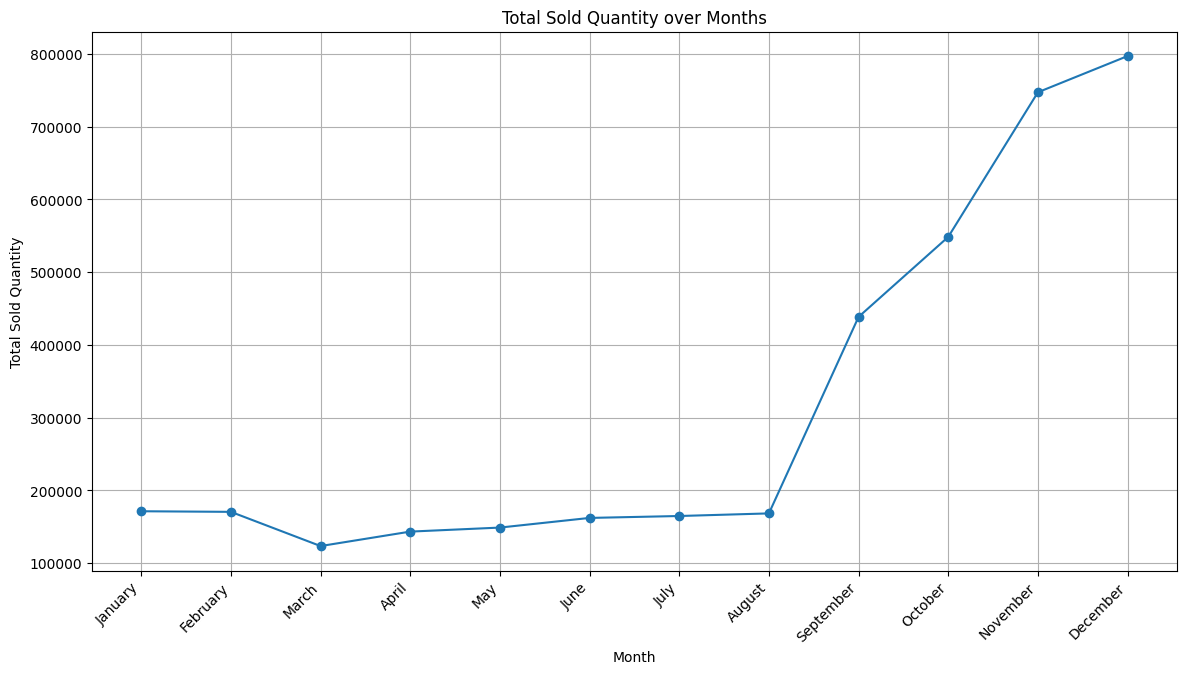

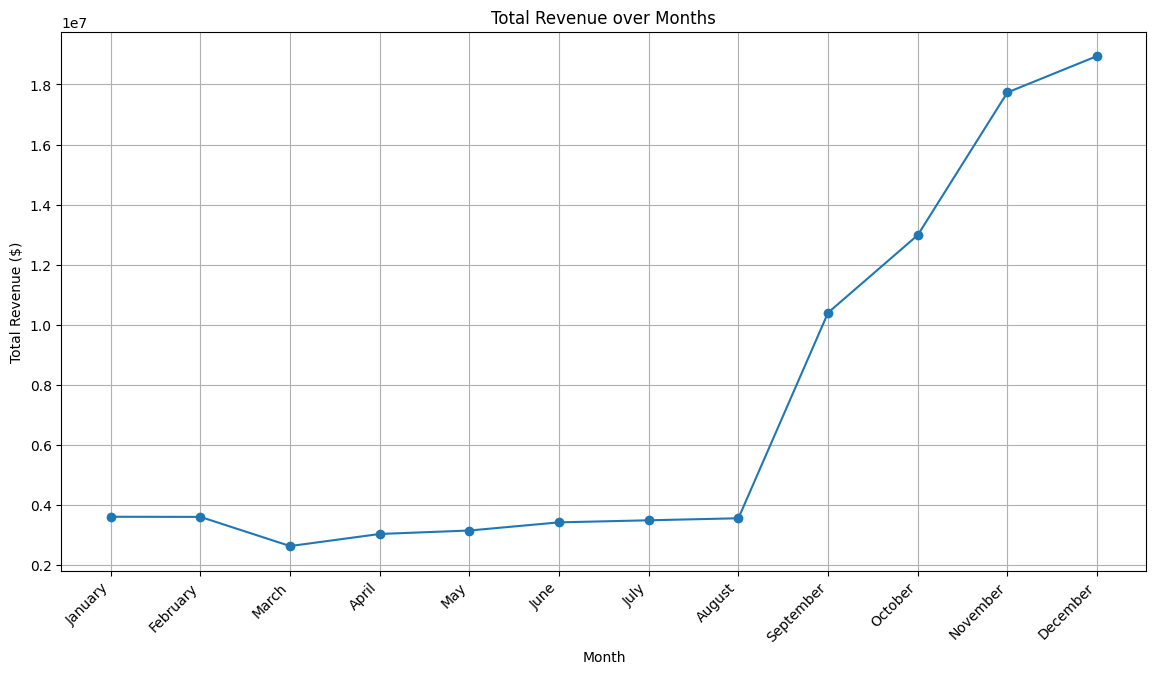

In [88]:
# Ensure month_number is an integer
monthly_trend_analysis['month_number'] = monthly_trend_analysis['month_number'].astype(int)

# Mapping month numbers to month names
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Convert month numbers to month names in the DataFrame
monthly_trend_analysis['month_name'] = monthly_trend_analysis['month_number'].map(month_names)

# Sort the DataFrame by month_number to ensure correct order
monthly_trend_analysis = monthly_trend_analysis.sort_values('month_number')

# Plotting Total Sold Quantity over Months
plt.figure(figsize=(14, 7))
plt.plot(monthly_trend_analysis['month_name'], monthly_trend_analysis['total_sold_quantity'], marker='o')
plt.title('Total Sold Quantity over Months')
plt.xlabel('Month')
plt.ylabel('Total Sold Quantity')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.show()

# Plotting Total Revenue over Months
plt.figure(figsize=(14, 7))
plt.plot(monthly_trend_analysis['month_name'], monthly_trend_analysis['total_revenue'], marker='o')
plt.title('Total Revenue over Months')
plt.xlabel('Month')
plt.ylabel('Total Revenue ($)')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.show()

Month 12 (December) shows the highest sales volume and revenue, which may indicate a seasonal peak, possibly due to year-end holidays or end-of-year purchases.Months 11 (November) and 10 (October) also show significant sales, suggesting a possible buildup towards the holiday season.

The lowest sales volumes and revenues are seen in Month 03 (March) and Month 04 (April). This could be a period of low demand, possibly influenced by factors like the end of the fiscal year or seasonal lulls.

#### Conclusions

Growth of 'AQ Zion Saga' and 'AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm': Both products, despite being launched recently, have shown significant growth in sales volumes and revenues, particularly in 2022. This indicates strong market acceptance and demand for these product lines.

Recovery and Growth of 'AQ Mforce Gen X': After a noticeable dip in 2021, the 'AQ Mforce Gen X' product line experienced a substantial increase in sales volume and revenue in 2022, particularly for the "Standard 3" variant. This suggests a successful turnaround, potentially due to improved market strategies or increased consumer interest.

Decline in 'AQ Dracula HDD' Variants: While the 'AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache' was a strong performer until 2021, there was a decline in 2022. The discontinuation of the "Plus" and "Standard" variants and a shift towards the "Premium Plus" and "Premium" variants led to an overall reduction in sales volumes and revenues.

Seasonal Sales Trends: The analysis indicates a strong seasonal peak in sales volumes and revenues during December, with significant activity also seen in October and November. Conversely, March and April experienced the lowest sales, suggesting seasonal variability.

**Reccomendations:**

For 'AQ Zion Saga' and 'AQ WereWolf NAS Internal Hard Drive HDD':

Consider expanding these product lines with new variants or enhancements to capitalize on their popularity. Innovation in features or technology can help maintain and grow market share.

For 'AQ Mforce Gen X':

Build on the momentum gained in 2022 by exploring additional variants or bundled offers to attract a broader customer base. Focus on targeted marketing campaigns to highlight the unique features and benefits of the 'Standard 3' variant, which has shown significant consumer interest.

For 'AQ Dracula HDD' Product Line:

In light of the decline in sales, it is important to reassess the product line. This may involve reintroducing previous variants or introducing new ones. Additionally, efforts should focus on promoting the more successful 'Premium' and 'Premium Plus' variants, highlighting their superior features and value proposition to attract customers.


Seasonal Promotions: 
Implement targeted promotions and discounts during off-peak months (March and April) to stimulate demand and manage inventory.

Holiday Campaigns: 
Maximize sales opportunities during peak months (October-December) with special holiday campaigns, limited-time offers, and enhanced marketing efforts.

Product Launch Timing: 
Strategically launch new products or variants during quieter months to generate excitement and prevent competition with peak-season promotions.

##  Stage 5. Market Segmentation<a id='market'></a>

For market segmentation analysis, we will join the comprehensive dataset with the dim_customer table. This will allow us to segment the market based on regions, platforms, and channels. We can then analyze sales performance and profitability for each segment, gaining insights into which segments are driving sales and where there may be opportunities for growth.

In [89]:
# Query to join the comprehensive data with product and customer details
query = """
SELECT
    jd.date,
    jd.product,
    jd.variant,
    dc.customer,
    dc.platform,
    dc.channel,
    dc.market,
    dc.sub_zone,
    dc.region,
    jd.sold_quantity,
    jd.gross_price
FROM
    (SELECT
        c.date,
        c.fiscal_year,
        c.month_number,
        c.customer_code,
        c.product_code,
        c.product,
        c.variant,
        c.division,
        c.category,
        c.segment,
        c.sold_quantity,
        fgp.gross_price
     FROM
        (SELECT 
            fsm.date AS date,
            fsm.fiscal_year AS fiscal_year,
            strftime('%m', fsm.date) AS month_number,
            fsm.product_code AS product_code,
            fsm.customer_code AS customer_code,
            dp.product AS product,
            dp.variant AS variant,
            dp.division AS division,
            dp.category AS category,
            dp.segment AS segment,
            fsm.sold_quantity AS sold_quantity
         FROM 
            (SELECT 
                date,
                product_code,
                customer_code,
                sold_quantity,
                fiscal_year
             FROM 
                Fact_sales_monthly
             WHERE
                date IS NOT NULL AND
                product_code IS NOT NULL AND
                customer_code IS NOT NULL AND
                sold_quantity IS NOT NULL AND
                fiscal_year IS NOT NULL) fsm
         INNER JOIN
            (SELECT
                product_code,
                TRIM(product) AS product,
                division,  
                category,
                segment,
                TRIM(variant) AS variant
             FROM 
                dim_product) dp ON fsm.product_code = dp.product_code) c
     INNER JOIN
        fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
     ORDER BY
        c.date, c.product_code) jd
INNER JOIN 
    (SELECT 
        customer_code,
        CASE 
            WHEN LOWER(TRIM(customer)) = 'walmart' THEN 'Walmart'
            ELSE TRIM(customer)
        END AS customer,
        platform,
        channel,
        market,
        sub_zone,
        region
     FROM 
        dim_customer) dc ON jd.customer_code = dc.customer_code
ORDER BY 
    jd.date, jd.product_code;
"""

market_sales_dataset = pd.read_sql_query(query, con)
market_sales_dataset

,date,product,variant,customer,platform,channel,market,sub_zone,region,sold_quantity,gross_price
0,2017-09-01,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,51,15.3952
1,2017-09-01,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,Atliq e Store,E-Commerce,Direct,India,India,APAC,77,15.3952
2,2017-09-01,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,Atliq Exclusive,Brick & Mortar,Direct,Indonesia,ROA,APAC,17,15.3952
3,2017-09-01,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,Atliq e Store,E-Commerce,Direct,Indonesia,ROA,APAC,6,15.3952
4,2017-09-01,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,Atliq Exclusive,Brick & Mortar,Direct,Philiphines,ROA,APAC,5,15.3952
...,...,...,...,...,...,...,...,...,...,...,...
67245,2021-12-01,AQ Mforce Gen X,Standard 3,Walmart,Brick & Mortar,Retailer,Canada,NA,NA,168,21.0913
67246,2021-12-01,AQ Mforce Gen X,Standard 3,Amazon,E-Commerce,Retailer,Canada,NA,NA,545,21.0913
67247,2021-12-01,AQ Mforce Gen X,Standard 3,Electricalsbea Stores,Brick & Mortar,Retailer,Chile,LATAM,LATAM,38,21.0913
67248,2021-12-01,AQ Mforce Gen X,Standard 3,Amazon,E-Commerce,Retailer,Chile,LATAM,LATAM,51,21.0913


In [90]:
# Query to join sales data with product details, customer information, and calculate profit margins
query = """
SELECT
    msd.date,
    msd.product,
    msd.variant,
    msd.customer,
    msd.platform,
    msd.channel,
    msd.market,
    msd.sub_zone,
    msd.region,
    msd.sold_quantity,
    msd.gross_price,
    pd.manufacturing_cost,
    pd.profit_margin
FROM
    (SELECT
        jd.date,
        jd.product,
        jd.variant,
        dc.customer,
        dc.platform,
        dc.channel,
        dc.market,
        dc.sub_zone,
        dc.region,
        jd.sold_quantity,
        jd.gross_price,
        jd.product_code,
        jd.fiscal_year
     FROM
        (SELECT
            c.date,
            c.fiscal_year,
            strftime('%m', c.date) AS month_number,
            c.customer_code,
            c.product_code,
            c.product,
            c.variant,
            c.division,
            c.category,
            c.segment,
            c.sold_quantity,
            fgp.gross_price
         FROM
            (SELECT 
                fsm.date AS date,
                fsm.fiscal_year AS fiscal_year,
                strftime('%m', fsm.date) AS month_number,
                fsm.product_code AS product_code,
                fsm.customer_code AS customer_code,
                dp.product AS product,
                dp.variant AS variant,
                dp.division AS division,
                dp.category AS category,
                dp.segment AS segment,
                fsm.sold_quantity AS sold_quantity
             FROM 
                (SELECT 
                    date,
                    product_code,
                    customer_code,
                    sold_quantity,
                    fiscal_year
                 FROM 
                    Fact_sales_monthly
                 WHERE
                    date IS NOT NULL AND
                    product_code IS NOT NULL AND
                    customer_code IS NOT NULL AND
                    sold_quantity IS NOT NULL AND
                    fiscal_year IS NOT NULL) fsm
             INNER JOIN
                (SELECT
                    product_code,
                    TRIM(product) AS product,
                    division,  
                    category,
                    segment,
                    TRIM(variant) AS variant
                 FROM 
                    dim_product) dp ON fsm.product_code = dp.product_code) c
         INNER JOIN
            fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
         ORDER BY
            c.date, c.product_code) jd
     INNER JOIN 
        (SELECT 
            customer_code,
            CASE 
                WHEN LOWER(TRIM(customer)) = 'walmart' THEN 'Walmart'
                ELSE TRIM(customer)
            END AS customer,
            platform,
            channel,
            market,
            sub_zone,
            region
         FROM 
            dim_customer) dc ON jd.customer_code = dc.customer_code
     ORDER BY 
        jd.date, jd.product_code) msd
INNER JOIN
    (SELECT 
        fgp.product_code,
        fgp.fiscal_year,
        fgp.gross_price,
        fmc.manufacturing_cost,
        (fgp.gross_price - fmc.manufacturing_cost) AS profit_margin
     FROM 
        fact_gross_price fgp
     INNER JOIN 
        fact_manufacturing_cost fmc ON fgp.product_code = fmc.product_code AND fgp.fiscal_year = fmc.cost_year) pd
ON
    msd.product_code = pd.product_code AND msd.fiscal_year = pd.fiscal_year
ORDER BY
    msd.date, msd.product_code;
"""

segment_sales_profit_joined = pd.read_sql_query(query, con)
segment_sales_profit_joined

,date,product,variant,customer,platform,channel,market,sub_zone,region,sold_quantity,gross_price,manufacturing_cost,profit_margin
0,2017-09-01,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,51,15.3952,4.6190,10.7762
1,2017-09-01,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,Atliq e Store,E-Commerce,Direct,India,India,APAC,77,15.3952,4.6190,10.7762
2,2017-09-01,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,Atliq Exclusive,Brick & Mortar,Direct,Indonesia,ROA,APAC,17,15.3952,4.6190,10.7762
3,2017-09-01,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,Atliq e Store,E-Commerce,Direct,Indonesia,ROA,APAC,6,15.3952,4.6190,10.7762
4,2017-09-01,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,Atliq Exclusive,Brick & Mortar,Direct,Philiphines,ROA,APAC,5,15.3952,4.6190,10.7762
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67245,2021-12-01,AQ Mforce Gen X,Standard 3,Walmart,Brick & Mortar,Retailer,Canada,NA,NA,168,21.0913,6.0345,15.0568
67246,2021-12-01,AQ Mforce Gen X,Standard 3,Amazon,E-Commerce,Retailer,Canada,NA,NA,545,21.0913,6.0345,15.0568
67247,2021-12-01,AQ Mforce Gen X,Standard 3,Electricalsbea Stores,Brick & Mortar,Retailer,Chile,LATAM,LATAM,38,21.0913,6.0345,15.0568
67248,2021-12-01,AQ Mforce Gen X,Standard 3,Amazon,E-Commerce,Retailer,Chile,LATAM,LATAM,51,21.0913,6.0345,15.0568


In [91]:
# Calculating total sold quantity, total profit, and total revenue by region, platform, and channel
query = """
SELECT
    region,
    platform,
    channel,
    SUM(sold_quantity) AS total_sold_quantity,
    ROUND(SUM(sold_quantity * profit_margin), 2) AS total_profit,
    ROUND(SUM(sold_quantity * gross_price), 2) AS total_revenue
FROM
(SELECT
    msd.date,
    msd.product,
    msd.variant,
    msd.customer,
    msd.platform,
    msd.channel,
    msd.market,
    msd.sub_zone,
    msd.region,
    msd.sold_quantity,
    msd.gross_price,
    pd.manufacturing_cost,
    pd.profit_margin
FROM
    (SELECT
        jd.date,
        jd.product,
        jd.variant,
        dc.customer,
        dc.platform,
        dc.channel,
        dc.market,
        dc.sub_zone,
        dc.region,
        jd.sold_quantity,
        jd.gross_price,
        jd.product_code,
        jd.fiscal_year
     FROM
        (SELECT
            c.date,
            c.fiscal_year,
            strftime('%m', c.date) AS month_number,
            c.customer_code,
            c.product_code,
            c.product,
            c.variant,
            c.division,
            c.category,
            c.segment,
            c.sold_quantity,
            fgp.gross_price
         FROM
            (SELECT 
                fsm.date AS date,
                fsm.fiscal_year AS fiscal_year,
                strftime('%m', fsm.date) AS month_number,
                fsm.product_code AS product_code,
                fsm.customer_code AS customer_code,
                dp.product AS product,
                dp.variant AS variant,
                dp.division AS division,
                dp.category AS category,
                dp.segment AS segment,
                fsm.sold_quantity AS sold_quantity
             FROM 
                (SELECT 
                    date,
                    product_code,
                    customer_code,
                    sold_quantity,
                    fiscal_year
                 FROM 
                    Fact_sales_monthly
                 WHERE
                    date IS NOT NULL AND
                    product_code IS NOT NULL AND
                    customer_code IS NOT NULL AND
                    sold_quantity IS NOT NULL AND
                    fiscal_year IS NOT NULL) fsm
             INNER JOIN
                (SELECT
                    product_code,
                    TRIM(product) AS product,
                    division,  
                    category,
                    segment,
                    TRIM(variant) AS variant
                 FROM 
                    dim_product) dp ON fsm.product_code = dp.product_code) c
         INNER JOIN
            fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
         ORDER BY
            c.date, c.product_code) jd
     INNER JOIN 
        (SELECT 
            customer_code,
            CASE 
                WHEN LOWER(TRIM(customer)) = 'walmart' THEN 'Walmart'
                ELSE TRIM(customer)
            END AS customer,
            platform,
            channel,
            market,
            sub_zone,
            region
         FROM 
            dim_customer) dc ON jd.customer_code = dc.customer_code
     ORDER BY 
        jd.date, jd.product_code) msd
INNER JOIN
    (SELECT 
        fgp.product_code,
        fgp.fiscal_year,
        fgp.gross_price,
        fmc.manufacturing_cost,
        (fgp.gross_price - fmc.manufacturing_cost) AS profit_margin
     FROM 
        fact_gross_price fgp
     INNER JOIN 
        fact_manufacturing_cost fmc ON fgp.product_code = fmc.product_code AND fgp.fiscal_year = fmc.cost_year) pd
ON
    msd.product_code = pd.product_code AND msd.fiscal_year = pd.fiscal_year
ORDER BY
    msd.date, msd.product_code) AS segment_sales_profit_joined
GROUP BY
    region, platform, channel
ORDER BY
    region, total_revenue DESC;
"""

segment_sales_profit_joined = pd.read_sql_query(query, con)
segment_sales_profit_joined

,region,platform,channel,total_sold_quantity,total_profit,total_revenue
0,APAC,Brick & Mortar,Retailer,906286,14542336.71,20680672.61
1,APAC,E-Commerce,Retailer,448088,7150787.79,10166987.08
2,APAC,Brick & Mortar,Distributor,443286,7076386.57,10062149.32
3,APAC,E-Commerce,Direct,187374,2984820.12,4244722.00
4,APAC,Brick & Mortar,Direct,158361,2532195.46,3601594.98
5,EU,Brick & Mortar,Retailer,586428,9624131.30,13686396.97
6,EU,E-Commerce,Retailer,91590,1494460.28,2125311.19
7,EU,E-Commerce,Direct,87161,1419681.49,2019127.27
8,EU,Brick & Mortar,Direct,47929,778799.46,1107721.49
9,LATAM,E-Commerce,Retailer,9233,140710.85,200247.23


In this step, we carried out a detailed market segmentation analysis to understand how sales performance and profitability vary across different regions, platforms, and sales channels. This segmentation gives us a clear view of the market, allowing us to further analyze each segment. The most popular and profitable combination is the APAC region with the Brick & Mortar platform and Retailer channel, which generates over $14.5M in total profit.

In [92]:
# Calculating total sold quantity, total profit, and total revenue by sales channel
query = """
SELECT
    channel,
    SUM(sold_quantity) AS total_sold_quantity,
    ROUND(SUM(sold_quantity * profit_margin), 2) AS total_profit,
    ROUND(SUM(sold_quantity * gross_price), 2) AS total_revenue
FROM
(SELECT
    msd.date,
    msd.product,
    msd.variant,
    msd.customer,
    msd.platform,
    msd.channel,
    msd.market,
    msd.sub_zone,
    msd.region,
    msd.sold_quantity,
    msd.gross_price,
    pd.manufacturing_cost,
    pd.profit_margin
FROM
    (SELECT
        jd.date,
        jd.product,
        jd.variant,
        dc.customer,
        dc.platform,
        dc.channel,
        dc.market,
        dc.sub_zone,
        dc.region,
        jd.sold_quantity,
        jd.gross_price,
        jd.product_code,
        jd.fiscal_year
     FROM
        (SELECT
            c.date,
            c.fiscal_year,
            strftime('%m', c.date) AS month_number,
            c.customer_code,
            c.product_code,
            c.product,
            c.variant,
            c.division,
            c.category,
            c.segment,
            c.sold_quantity,
            fgp.gross_price
         FROM
            (SELECT 
                fsm.date AS date,
                fsm.fiscal_year AS fiscal_year,
                strftime('%m', fsm.date) AS month_number,
                fsm.product_code AS product_code,
                fsm.customer_code AS customer_code,
                dp.product AS product,
                dp.variant AS variant,
                dp.division AS division,
                dp.category AS category,
                dp.segment AS segment,
                fsm.sold_quantity AS sold_quantity
             FROM 
                (SELECT 
                    date,
                    product_code,
                    customer_code,
                    sold_quantity,
                    fiscal_year
                 FROM 
                    Fact_sales_monthly
                 WHERE
                    date IS NOT NULL AND
                    product_code IS NOT NULL AND
                    customer_code IS NOT NULL AND
                    sold_quantity IS NOT NULL AND
                    fiscal_year IS NOT NULL) fsm
             INNER JOIN
                (SELECT
                    product_code,
                    TRIM(product) AS product,
                    division,  
                    category,
                    segment,
                    TRIM(variant) AS variant
                 FROM 
                    dim_product) dp ON fsm.product_code = dp.product_code) c
         INNER JOIN
            fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
         ORDER BY
            c.date, c.product_code) jd
     INNER JOIN 
        (SELECT 
            customer_code,
            CASE 
                WHEN LOWER(TRIM(customer)) = 'walmart' THEN 'Walmart'
                ELSE TRIM(customer)
            END AS customer,
            platform,
            channel,
            market,
            sub_zone,
            region
         FROM 
            dim_customer) dc ON jd.customer_code = dc.customer_code
     ORDER BY 
        jd.date, jd.product_code) msd
INNER JOIN
    (SELECT 
        fgp.product_code,
        fgp.fiscal_year,
        fgp.gross_price,
        fmc.manufacturing_cost,
        (fgp.gross_price - fmc.manufacturing_cost) AS profit_margin
     FROM 
        fact_gross_price fgp
     INNER JOIN 
        fact_manufacturing_cost fmc ON fgp.product_code = fmc.product_code AND fgp.fiscal_year = fmc.cost_year) pd
ON
    msd.product_code = pd.product_code AND msd.fiscal_year = pd.fiscal_year
ORDER BY
    msd.date, msd.product_code) AS segment_sales_profit_joined
GROUP BY
    channel
ORDER BY
    total_revenue DESC;
"""

channel_sales_performance = pd.read_sql_query(query, con)
channel_sales_performance

,channel,total_sold_quantity,total_profit,total_revenue
0,Retailer,2734758,44093013.95,62702629.61
1,Direct,604891,9696870.26,13791130.13
2,Distributor,443286,7076386.57,10062149.32


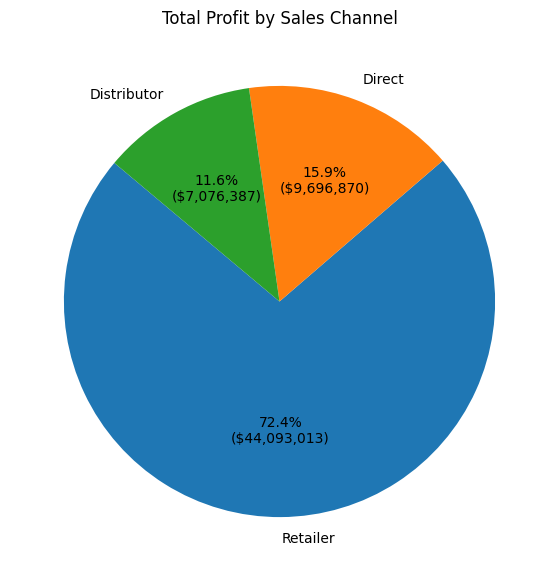

In [93]:
# Data for the pie chart
channels = channel_sales_performance['channel']
total_profit = channel_sales_performance['total_profit']

# Plotting the pie chart for total profit
plt.figure(figsize=(10, 7))
plt.pie(total_profit, labels=channels, autopct=lambda p: '{:.1f}%\n(${:,.0f})'.format(p, p * sum(total_profit) / 100), startangle=140)
plt.title('Total Profit by Sales Channel')
plt.show()


The Retailer channel leads significantly in both total sold quantity and total revenue, generating the highest profit, indicating it is the most effective sales channel for AtliQ Hardware.

In [94]:
#Executing query to retrieve sales performance by product across different channels
query = """
SELECT
    channel,
    product,
    SUM(sold_quantity) AS total_sold_quantity,
    ROUND(SUM(sold_quantity * profit_margin), 2) AS total_profit,
    ROUND(SUM(sold_quantity * gross_price), 2) AS total_revenue
FROM
(SELECT
    msd.date,
    msd.product,
    msd.variant,
    msd.customer,
    msd.platform,
    msd.channel,
    msd.market,
    msd.sub_zone,
    msd.region,
    msd.sold_quantity,
    msd.gross_price,
    pd.manufacturing_cost,
    pd.profit_margin
FROM
    (SELECT
        jd.date,
        jd.product,
        jd.variant,
        dc.customer,
        dc.platform,
        dc.channel,
        dc.market,
        dc.sub_zone,
        dc.region,
        jd.sold_quantity,
        jd.gross_price,
        jd.product_code,
        jd.fiscal_year
     FROM
        (SELECT
            c.date,
            c.fiscal_year,
            strftime('%m', c.date) AS month_number,
            c.customer_code,
            c.product_code,
            c.product,
            c.variant,
            c.division,
            c.category,
            c.segment,
            c.sold_quantity,
            fgp.gross_price
         FROM
            (SELECT 
                fsm.date AS date,
                fsm.fiscal_year AS fiscal_year,
                strftime('%m', fsm.date) AS month_number,
                fsm.product_code AS product_code,
                fsm.customer_code AS customer_code,
                dp.product AS product,
                dp.variant AS variant,
                dp.division AS division,
                dp.category AS category,
                dp.segment AS segment,
                fsm.sold_quantity AS sold_quantity
             FROM 
                (SELECT 
                    date,
                    product_code,
                    customer_code,
                    sold_quantity,
                    fiscal_year
                 FROM 
                    Fact_sales_monthly
                 WHERE
                    date IS NOT NULL AND
                    product_code IS NOT NULL AND
                    customer_code IS NOT NULL AND
                    sold_quantity IS NOT NULL AND
                    fiscal_year IS NOT NULL) fsm
             INNER JOIN
                (SELECT
                    product_code,
                    TRIM(product) AS product,
                    division,  
                    category,
                    segment,
                    TRIM(variant) AS variant
                 FROM 
                    dim_product) dp ON fsm.product_code = dp.product_code) c
         INNER JOIN
            fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
         ORDER BY
            c.date, c.product_code) jd
     INNER JOIN 
        (SELECT 
            customer_code,
            CASE 
                WHEN LOWER(TRIM(customer)) = 'walmart' THEN 'Walmart'
                ELSE TRIM(customer)
            END AS customer,
            platform,
            channel,
            market,
            sub_zone,
            region
         FROM 
            dim_customer) dc ON jd.customer_code = dc.customer_code
     ORDER BY 
        jd.date, jd.product_code) msd
INNER JOIN
    (SELECT 
        fgp.product_code,
        fgp.fiscal_year,
        fgp.gross_price,
        fmc.manufacturing_cost,
        (fgp.gross_price - fmc.manufacturing_cost) AS profit_margin
     FROM 
        fact_gross_price fgp
     INNER JOIN 
        fact_manufacturing_cost fmc ON fgp.product_code = fmc.product_code AND fgp.fiscal_year = fmc.cost_year) pd
ON
    msd.product_code = pd.product_code AND msd.fiscal_year = pd.fiscal_year
ORDER BY
    msd.date, msd.product_code) AS segment_sales_profit_joined
GROUP BY
    channel, product
ORDER BY
    channel, total_revenue DESC;
"""

channel_sales_performance_by_product = pd.read_sql_query(query, con)
channel_sales_performance_by_product

,channel,product,total_sold_quantity,total_profit,total_revenue
0,Direct,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,172014,2925417.96,4153678.70
1,Direct,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,196967,2893455.19,4124438.65
2,Direct,AQ Zion Saga,131645,2518007.49,3586065.34
3,Direct,AQ Mforce Gen X,104265,1359989.62,1926947.45
4,Distributor,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,144035,2112508.90,3010300.78
5,Distributor,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,123013,2084423.80,2961347.80
6,Distributor,AQ Zion Saga,93027,1789630.71,2547322.83
7,Distributor,AQ Mforce Gen X,83211,1089823.16,1543177.91
8,Retailer,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,780327,13306463.57,18888933.18
9,Retailer,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,870579,12834733.26,18298308.84


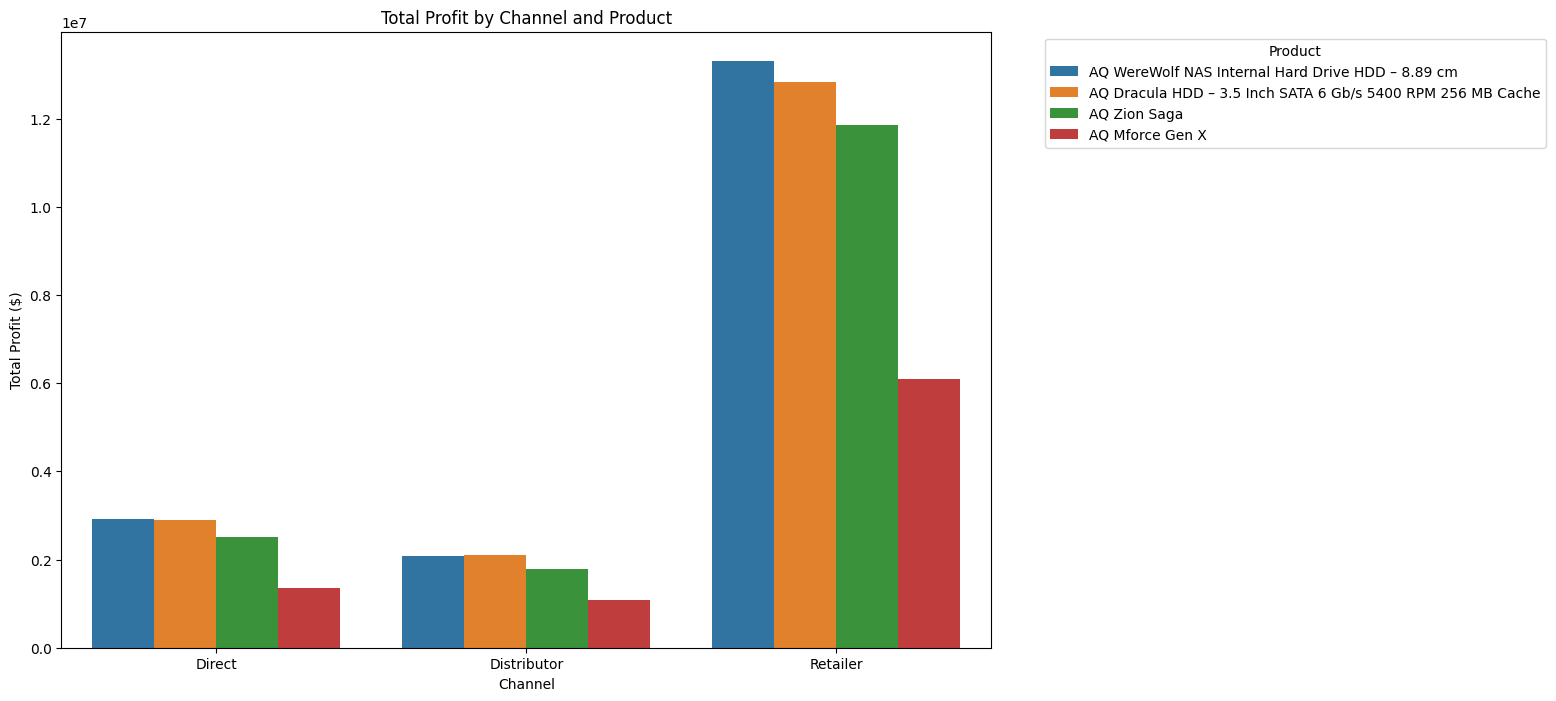

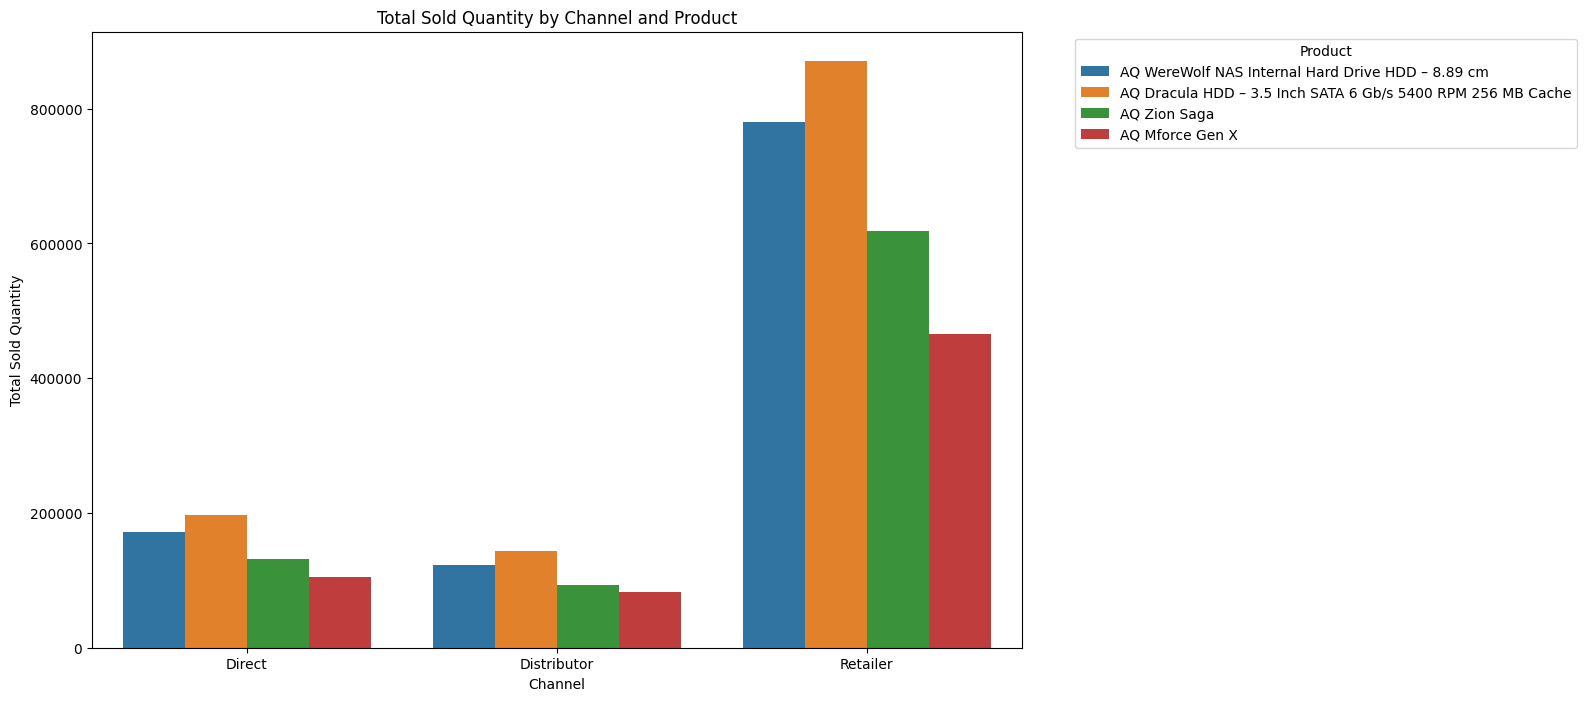

In [95]:
# Plotting Total Profit by Channel and Product
plt.figure(figsize=(12, 8))
sns.barplot(x='channel', y='total_profit', hue='product', data=channel_sales_performance_by_product, ci=None)
plt.title('Total Profit by Channel and Product')
plt.ylabel('Total Profit ($)')
plt.xlabel('Channel')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plotting Total Sold Quantity by Channel and Product
plt.figure(figsize=(12, 8))
sns.barplot(x='channel', y='total_sold_quantity', hue='product', data=channel_sales_performance_by_product, ci=None)
plt.title('Total Sold Quantity by Channel and Product')
plt.ylabel('Total Sold Quantity')
plt.xlabel('Channel')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We observe that the retailer channel dominates sales across all products. Within this channel, the 'AQ WereWolf' line stands out with the highest total profit and substantial sold quantities, demonstrating strong customer demand. Additionally, 'AQ Dracula' leads in total sold quantities, indicating a significant market presence and strong customer preference for this product.

In [96]:
# Querying the total sold quantity, total profit, and total revenue by platform
query = """
SELECT
    platform,
    SUM(sold_quantity) AS total_sold_quantity,
    ROUND(SUM(sold_quantity * profit_margin), 2) AS total_profit,
    ROUND(SUM(sold_quantity * gross_price), 2) AS total_revenue
FROM
(SELECT
    msd.date,
    msd.product,
    msd.variant,
    msd.customer,
    msd.platform,
    msd.channel,
    msd.market,
    msd.sub_zone,
    msd.region,
    msd.sold_quantity,
    msd.gross_price,
    pd.manufacturing_cost,
    pd.profit_margin
FROM
    (SELECT
        jd.date,
        jd.product,
        jd.variant,
        dc.customer,
        dc.platform,
        dc.channel,
        dc.market,
        dc.sub_zone,
        dc.region,
        jd.sold_quantity,
        jd.gross_price,
        jd.product_code,
        jd.fiscal_year
     FROM
        (SELECT
            c.date,
            c.fiscal_year,
            strftime('%m', c.date) AS month_number,
            c.customer_code,
            c.product_code,
            c.product,
            c.variant,
            c.division,
            c.category,
            c.segment,
            c.sold_quantity,
            fgp.gross_price
         FROM
            (SELECT 
                fsm.date AS date,
                fsm.fiscal_year AS fiscal_year,
                strftime('%m', fsm.date) AS month_number,
                fsm.product_code AS product_code,
                fsm.customer_code AS customer_code,
                dp.product AS product,
                dp.variant AS variant,
                dp.division AS division,
                dp.category AS category,
                dp.segment AS segment,
                fsm.sold_quantity AS sold_quantity
             FROM 
                (SELECT 
                    date,
                    product_code,
                    customer_code,
                    sold_quantity,
                    fiscal_year
                 FROM 
                    Fact_sales_monthly
                 WHERE
                    date IS NOT NULL AND
                    product_code IS NOT NULL AND
                    customer_code IS NOT NULL AND
                    sold_quantity IS NOT NULL AND
                    fiscal_year IS NOT NULL) fsm
             INNER JOIN
                (SELECT
                    product_code,
                    TRIM(product) AS product,
                    division,  
                    category,
                    segment,
                    TRIM(variant) AS variant
                 FROM 
                    dim_product) dp ON fsm.product_code = dp.product_code) c
         INNER JOIN
            fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
         ORDER BY
            c.date, c.product_code) jd
     INNER JOIN 
        (SELECT 
            customer_code,
            CASE 
                WHEN LOWER(TRIM(customer)) = 'walmart' THEN 'Walmart'
                ELSE TRIM(customer)
            END AS customer,
            platform,
            channel,
            market,
            sub_zone,
            region
         FROM 
            dim_customer) dc ON jd.customer_code = dc.customer_code
     ORDER BY 
        jd.date, jd.product_code) msd
INNER JOIN
    (SELECT 
        fgp.product_code,
        fgp.fiscal_year,
        fgp.gross_price,
        fmc.manufacturing_cost,
        (fgp.gross_price - fmc.manufacturing_cost) AS profit_margin
     FROM 
        fact_gross_price fgp
     INNER JOIN 
        fact_manufacturing_cost fmc ON fgp.product_code = fmc.product_code AND fgp.fiscal_year = fmc.cost_year) pd
ON
    msd.product_code = pd.product_code AND msd.fiscal_year = pd.fiscal_year
ORDER BY
    msd.date, msd.product_code) AS segment_sales_profit_joined
GROUP BY
    platform
ORDER BY
    total_revenue DESC;
"""

platform_sales_performance = pd.read_sql_query(query, con)
platform_sales_performance

,platform,total_sold_quantity,total_profit,total_revenue
0,Brick & Mortar,2657627,42868297.71,60962510.64
1,E-Commerce,1125308,17997973.07,25593398.42


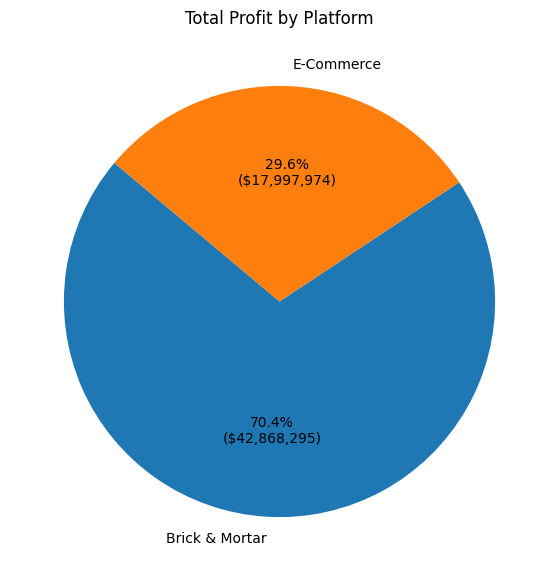

In [97]:
# Sample data, assuming the DataFrame is named platform_sales_performance
df = platform_sales_performance

# Extracting the platforms and total profit data
platforms = df['platform']
total_profit = df['total_profit']

# Plotting the pie chart for total profit
plt.figure(figsize=(10, 7))
plt.pie(total_profit, labels=platforms, autopct=lambda p: '{:.1f}%\n(${:,.0f})'.format(p, p * sum(total_profit) / 100), startangle=140)
plt.title('Total Profit by Platform')
plt.show()

Brick & Mortar significantly outperforms E-Commerce in both sales volume and revenue, indicating it remains the dominant sales channel despite the growing contribution from E-Commerce.

In [98]:
#Running the query to obtain sales performance data by platform and product
query = """
SELECT
    platform,
    product,
    SUM(sold_quantity) AS total_sold_quantity,
    ROUND(SUM(sold_quantity * profit_margin), 2) AS total_profit,
    ROUND(SUM(sold_quantity * gross_price), 2) AS total_revenue
FROM
(SELECT
    msd.date,
    msd.product,
    msd.variant,
    msd.customer,
    msd.platform,
    msd.channel,
    msd.market,
    msd.sub_zone,
    msd.region,
    msd.sold_quantity,
    msd.gross_price,
    pd.manufacturing_cost,
    pd.profit_margin
FROM
    (SELECT
        jd.date,
        jd.product,
        jd.variant,
        dc.customer,
        dc.platform,
        dc.channel,
        dc.market,
        dc.sub_zone,
        dc.region,
        jd.sold_quantity,
        jd.gross_price,
        jd.product_code,
        jd.fiscal_year
     FROM
        (SELECT
            c.date,
            c.fiscal_year,
            strftime('%m', c.date) AS month_number,
            c.customer_code,
            c.product_code,
            c.product,
            c.variant,
            c.division,
            c.category,
            c.segment,
            c.sold_quantity,
            fgp.gross_price
         FROM
            (SELECT 
                fsm.date AS date,
                fsm.fiscal_year AS fiscal_year,
                strftime('%m', fsm.date) AS month_number,
                fsm.product_code AS product_code,
                fsm.customer_code AS customer_code,
                dp.product AS product,
                dp.variant AS variant,
                dp.division AS division,
                dp.category AS category,
                dp.segment AS segment,
                fsm.sold_quantity AS sold_quantity
             FROM 
                (SELECT 
                    date,
                    product_code,
                    customer_code,
                    sold_quantity,
                    fiscal_year
                 FROM 
                    Fact_sales_monthly
                 WHERE
                    date IS NOT NULL AND
                    product_code IS NOT NULL AND
                    customer_code IS NOT NULL AND
                    sold_quantity IS NOT NULL AND
                    fiscal_year IS NOT NULL) fsm
             INNER JOIN
                (SELECT
                    product_code,
                    TRIM(product) AS product,
                    division,  
                    category,
                    segment,
                    TRIM(variant) AS variant
                 FROM 
                    dim_product) dp ON fsm.product_code = dp.product_code) c
         INNER JOIN
            fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
         ORDER BY
            c.date, c.product_code) jd
     INNER JOIN 
        (SELECT 
            customer_code,
            CASE 
                WHEN LOWER(TRIM(customer)) = 'walmart' THEN 'Walmart'
                ELSE TRIM(customer)
            END AS customer,
            platform,
            channel,
            market,
            sub_zone,
            region
         FROM 
            dim_customer) dc ON jd.customer_code = dc.customer_code
     ORDER BY 
        jd.date, jd.product_code) msd
INNER JOIN
    (SELECT 
        fgp.product_code,
        fgp.fiscal_year,
        fgp.gross_price,
        fmc.manufacturing_cost,
        (fgp.gross_price - fmc.manufacturing_cost) AS profit_margin
     FROM 
        fact_gross_price fgp
     INNER JOIN 
        fact_manufacturing_cost fmc ON fgp.product_code = fmc.product_code AND fgp.fiscal_year = fmc.cost_year) pd
ON
    msd.product_code = pd.product_code AND msd.fiscal_year = pd.fiscal_year
ORDER BY
    msd.date, msd.product_code) AS segment_sales_profit_joined
GROUP BY
    platform, product
ORDER BY
    platform, total_revenue DESC;
"""

platform_sales_performance_by_product = pd.read_sql_query(query, con)
platform_sales_performance_by_product

,platform,product,total_sold_quantity,total_profit,total_revenue
0,Brick & Mortar,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,760484,12968165.63,18412391.71
1,Brick & Mortar,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,849464,12538728.44,17877421.15
2,Brick & Mortar,AQ Zion Saga,592196,11379656.28,16203249.47
3,Brick & Mortar,AQ Mforce Gen X,455483,5981747.36,8469448.31
4,E-Commerce,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,314870,5348139.70,7591567.96
5,E-Commerce,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,362117,5301968.90,7555627.13
6,E-Commerce,AQ Zion Saga,251268,4786487.66,6816076.33
7,E-Commerce,AQ Mforce Gen X,197053,2561376.80,3630127.00


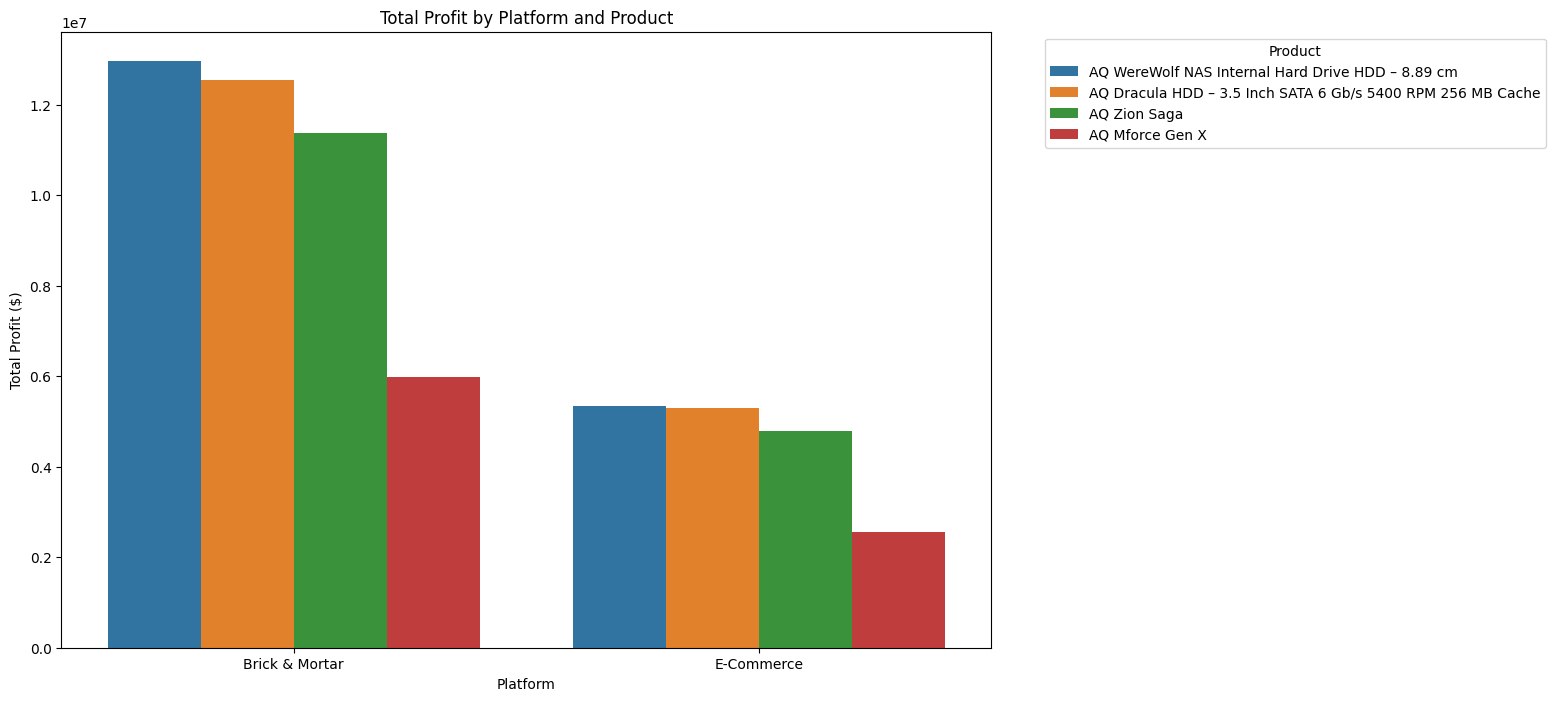

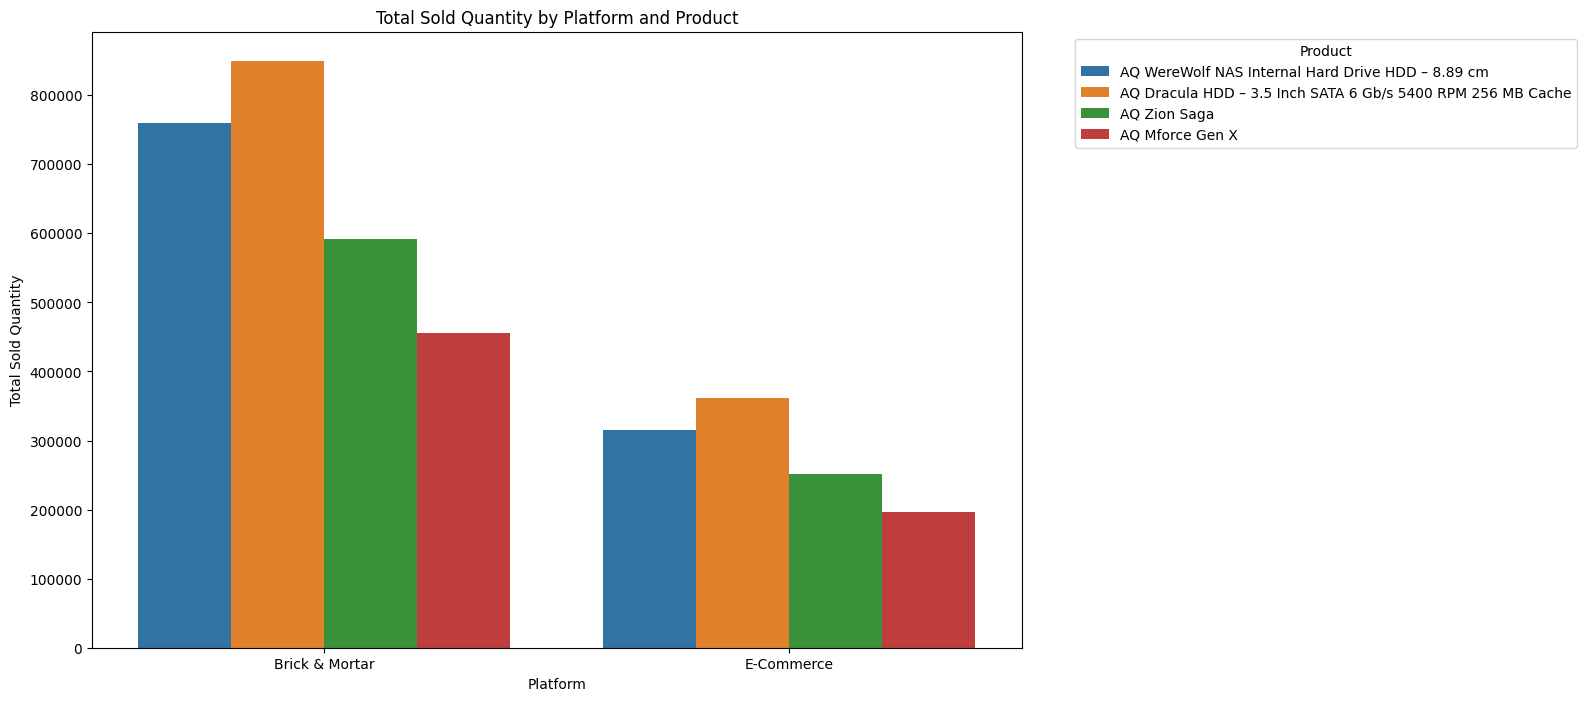

In [99]:
# Plotting total profit by platform and product
plt.figure(figsize=(12, 8))
sns.barplot(x='platform', y='total_profit', hue='product', data=platform_sales_performance_by_product, ci=None)
plt.title('Total Profit by Platform and Product')
plt.ylabel('Total Profit ($)')
plt.xlabel('Platform')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plotting total sold quantity by platform and product
plt.figure(figsize=(12, 8))
sns.barplot(x='platform', y='total_sold_quantity', hue='product', data=platform_sales_performance_by_product, ci=None)
plt.title('Total Sold Quantity by Platform and Product')
plt.ylabel('Total Sold Quantity')
plt.xlabel('Platform')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We observe that the Brick & Mortar platform leads in both total profit and sold quantities across all products. Similar to the channel analysis, the AQ WereWolf line is the most profitable and has a strong market presence, indicating robust customer demand. Additionally, the AQ Dracula line has the highest total sold quantities, underscoring its strong market presence and customer preference. These trends highlight the importance of physical retail outlets in driving sales for these key product lines.

In [100]:
#Querying regional sales performance, including total quantity sold, total profit, and total revenue
query = """
SELECT
    region,
    SUM(sold_quantity) AS total_sold_quantity,
    ROUND(SUM(sold_quantity * profit_margin), 2) AS total_profit,
    ROUND(SUM(sold_quantity * gross_price), 2) AS total_revenue
FROM
(SELECT
    msd.date,
    msd.product,
    msd.variant,
    msd.customer,
    msd.platform,
    msd.channel,
    msd.market,
    msd.sub_zone,
    msd.region,
    msd.sold_quantity,
    msd.gross_price,
    pd.manufacturing_cost,
    pd.profit_margin
FROM
    (SELECT
        jd.date,
        jd.product,
        jd.variant,
        dc.customer,
        dc.platform,
        dc.channel,
        dc.market,
        dc.sub_zone,
        dc.region,
        jd.sold_quantity,
        jd.gross_price,
        jd.product_code,
        jd.fiscal_year
     FROM
        (SELECT
            c.date,
            c.fiscal_year,
            strftime('%m', c.date) AS month_number,
            c.customer_code,
            c.product_code,
            c.product,
            c.variant,
            c.division,
            c.category,
            c.segment,
            c.sold_quantity,
            fgp.gross_price
         FROM
            (SELECT 
                fsm.date AS date,
                fsm.fiscal_year AS fiscal_year,
                strftime('%m', fsm.date) AS month_number,
                fsm.product_code AS product_code,
                fsm.customer_code AS customer_code,
                dp.product AS product,
                dp.variant AS variant,
                dp.division AS division,
                dp.category AS category,
                dp.segment AS segment,
                fsm.sold_quantity AS sold_quantity
             FROM 
                (SELECT 
                    date,
                    product_code,
                    customer_code,
                    sold_quantity,
                    fiscal_year
                 FROM 
                    Fact_sales_monthly
                 WHERE
                    date IS NOT NULL AND
                    product_code IS NOT NULL AND
                    customer_code IS NOT NULL AND
                    sold_quantity IS NOT NULL AND
                    fiscal_year IS NOT NULL) fsm
             INNER JOIN
                (SELECT
                    product_code,
                    TRIM(product) AS product,
                    division,  
                    category,
                    segment,
                    TRIM(variant) AS variant
                 FROM 
                    dim_product) dp ON fsm.product_code = dp.product_code) c
         INNER JOIN
            fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
         ORDER BY
            c.date, c.product_code) jd
     INNER JOIN 
        (SELECT 
            customer_code,
            CASE 
                WHEN LOWER(TRIM(customer)) = 'walmart' THEN 'Walmart'
                ELSE TRIM(customer)
            END AS customer,
            platform,
            channel,
            market,
            sub_zone,
            region
         FROM 
            dim_customer) dc ON jd.customer_code = dc.customer_code
     ORDER BY 
        jd.date, jd.product_code) msd
INNER JOIN
    (SELECT 
        fgp.product_code,
        fgp.fiscal_year,
        fgp.gross_price,
        fmc.manufacturing_cost,
        (fgp.gross_price - fmc.manufacturing_cost) AS profit_margin
     FROM 
        fact_gross_price fgp
     INNER JOIN 
        fact_manufacturing_cost fmc ON fgp.product_code = fmc.product_code AND fgp.fiscal_year = fmc.cost_year) pd
ON
    msd.product_code = pd.product_code AND msd.fiscal_year = pd.fiscal_year
ORDER BY
    msd.date, msd.product_code) AS segment_sales_profit_joined
GROUP BY
    region
ORDER BY
    total_revenue DESC;
"""

region_sales_performance = pd.read_sql_query(query, con)
region_sales_performance

,region,total_sold_quantity,total_profit,total_revenue
0,APAC,2143395,34286526.65,48756126.00
1,EU,813108,13317072.54,18938556.91
2,NA,806893,12962602.39,18434348.76
3,LATAM,19539,300069.21,426877.38


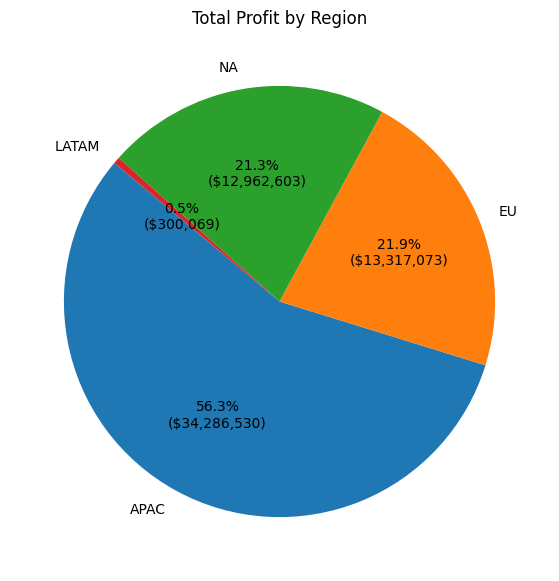

In [101]:
# Sample data, assuming the DataFrame is named region_sales_performance
df = region_sales_performance

# Plotting Total Profit by Region Pie Chart
plt.figure(figsize=(10, 7))
plt.pie(df['total_profit'], labels=df['region'], 
        autopct=lambda p: '{:.1f}%\n(${:,.0f})'.format(p, p * sum(df['total_profit']) / 100), 
        startangle=140)
plt.title('Total Profit by Region')
plt.show()

The APAC region dominates the sales performance, accounting for more than 50% of the total sold quantity and total profit indicating a strong market presence and customer base. In contrast, the LATAM region contributes less than 1% to the total sold quantity, profit, and revenue, suggesting a minimal market impact in this area. 

In [102]:
#Running the SQL query to get sales performance by product in each region
query = """
SELECT
    region,
    product,
    SUM(sold_quantity) AS total_sold_quantity,
    ROUND(SUM(sold_quantity * profit_margin), 2) AS total_profit,
    ROUND(SUM(sold_quantity * gross_price), 2) AS total_revenue
FROM
(SELECT
    msd.date,
    msd.product,
    msd.variant,
    msd.customer,
    msd.platform,
    msd.channel,
    msd.market,
    msd.sub_zone,
    msd.region,
    msd.sold_quantity,
    msd.gross_price,
    pd.manufacturing_cost,
    pd.profit_margin
FROM
    (SELECT
        jd.date,
        jd.product,
        jd.variant,
        dc.customer,
        dc.platform,
        dc.channel,
        dc.market,
        dc.sub_zone,
        dc.region,
        jd.sold_quantity,
        jd.gross_price,
        jd.product_code,
        jd.fiscal_year
     FROM
        (SELECT
            c.date,
            c.fiscal_year,
            strftime('%m', c.date) AS month_number,
            c.customer_code,
            c.product_code,
            c.product,
            c.variant,
            c.division,
            c.category,
            c.segment,
            c.sold_quantity,
            fgp.gross_price
         FROM
            (SELECT 
                fsm.date AS date,
                fsm.fiscal_year AS fiscal_year,
                strftime('%m', fsm.date) AS month_number,
                fsm.product_code AS product_code,
                fsm.customer_code AS customer_code,
                dp.product AS product,
                dp.variant AS variant,
                dp.division AS division,
                dp.category AS category,
                dp.segment AS segment,
                fsm.sold_quantity AS sold_quantity
             FROM 
                (SELECT 
                    date,
                    product_code,
                    customer_code,
                    sold_quantity,
                    fiscal_year
                 FROM 
                    Fact_sales_monthly
                 WHERE
                    date IS NOT NULL AND
                    product_code IS NOT NULL AND
                    customer_code IS NOT NULL AND
                    sold_quantity IS NOT NULL AND
                    fiscal_year IS NOT NULL) fsm
             INNER JOIN
                (SELECT
                    product_code,
                    TRIM(product) AS product,
                    division,  
                    category,
                    segment,
                    TRIM(variant) AS variant
                 FROM 
                    dim_product) dp ON fsm.product_code = dp.product_code) c
         INNER JOIN
            fact_gross_price fgp ON c.product_code = fgp.product_code AND c.fiscal_year = fgp.fiscal_year
         ORDER BY
            c.date, c.product_code) jd
     INNER JOIN 
        (SELECT 
            customer_code,
            CASE 
                WHEN LOWER(TRIM(customer)) = 'walmart' THEN 'Walmart'
                ELSE TRIM(customer)
            END AS customer,
            platform,
            channel,
            market,
            sub_zone,
            region
         FROM 
            dim_customer) dc ON jd.customer_code = dc.customer_code
     ORDER BY 
        jd.date, jd.product_code) msd
INNER JOIN
    (SELECT 
        fgp.product_code,
        fgp.fiscal_year,
        fgp.gross_price,
        fmc.manufacturing_cost,
        (fgp.gross_price - fmc.manufacturing_cost) AS profit_margin
     FROM 
        fact_gross_price fgp
     INNER JOIN 
        fact_manufacturing_cost fmc ON fgp.product_code = fmc.product_code AND fgp.fiscal_year = fmc.cost_year) pd
ON
    msd.product_code = pd.product_code AND msd.fiscal_year = pd.fiscal_year
ORDER BY
    msd.date, msd.product_code) AS segment_sales_profit_joined
GROUP BY
    region, product
ORDER BY
    region, total_revenue DESC;
"""

region_sales_performance_by_product = pd.read_sql_query(query, con)
region_sales_performance_by_product

,region,product,total_sold_quantity,total_profit,total_revenue
0,APAC,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,598260,10170398.38,14441003.18
1,APAC,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,688866,10091572.10,14383538.92
2,APAC,AQ Zion Saga,466250,8944749.63,12735426.17
3,APAC,AQ Mforce Gen X,390019,5079806.54,7196157.73
4,EU,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,240491,4118458.93,5846262.26
5,EU,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,254658,3808845.75,5432821.31
6,EU,AQ Zion Saga,194564,3738506.92,5323423.06
7,EU,AQ Mforce Gen X,123395,1651260.93,2336050.28
8,LATAM,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,6965,99180.09,141206.77
9,LATAM,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,5164,86254.71,122466.71


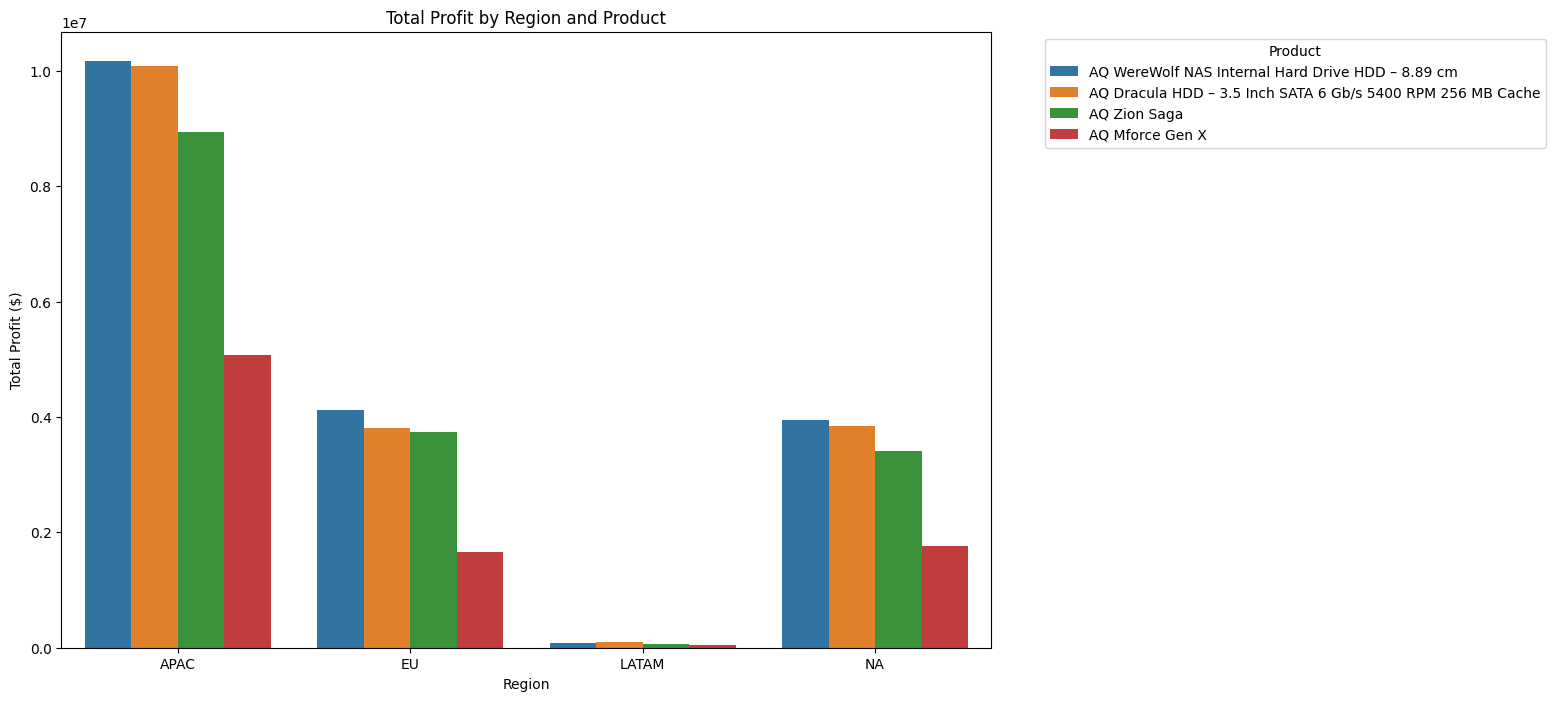

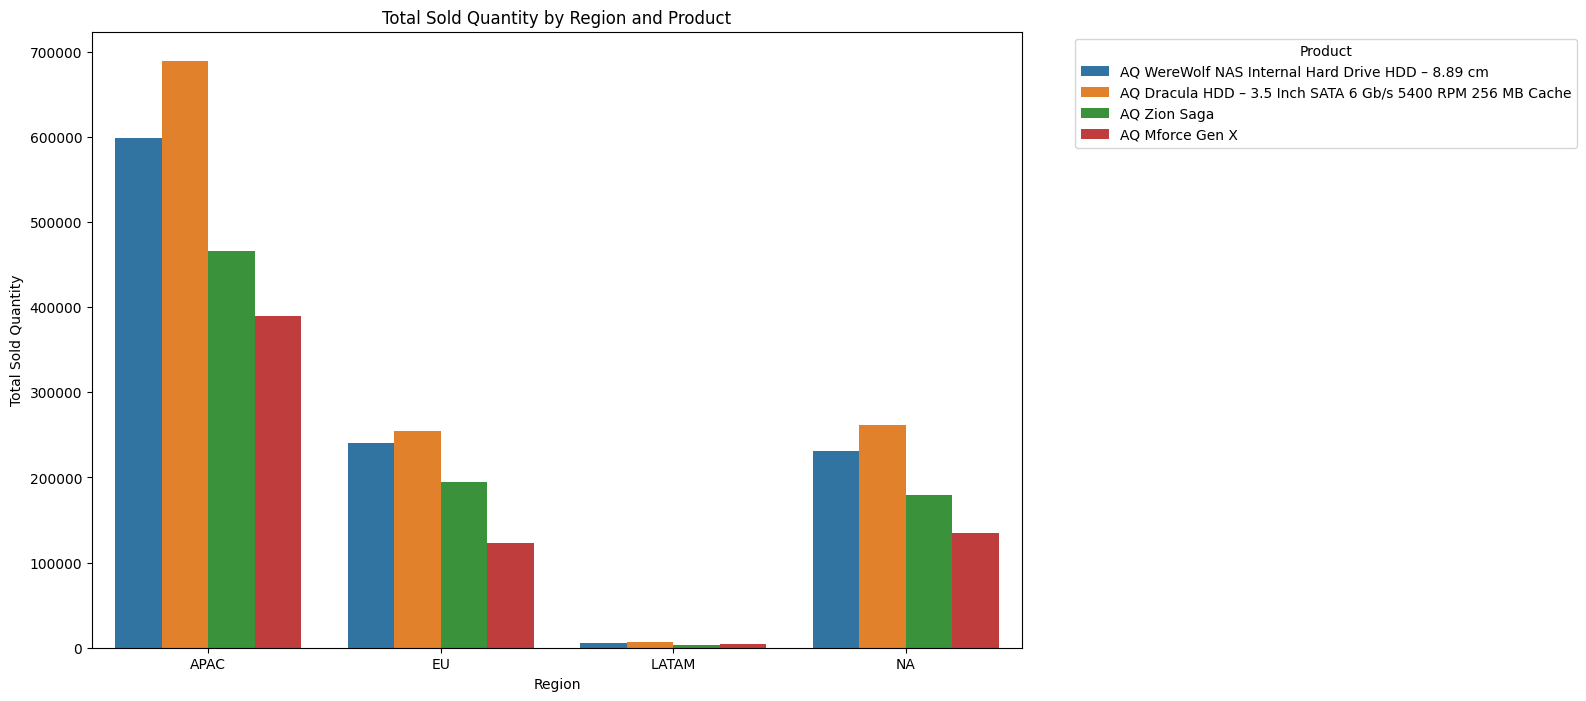

In [103]:
# Plotting Total Profit by Region and Product
plt.figure(figsize=(12, 8))
sns.barplot(x='region', y='total_profit', hue='product', data=region_sales_performance_by_product, ci=None)
plt.title('Total Profit by Region and Product')
plt.ylabel('Total Profit ($)')
plt.xlabel('Region')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plotting Total Sold Quantity by Region and Product
plt.figure(figsize=(12, 8))
sns.barplot(x='region', y='total_sold_quantity', hue='product', data=region_sales_performance_by_product, ci=None)
plt.title('Total Sold Quantity by Region and Product')
plt.ylabel('Total Sold Quantity')
plt.xlabel('Region')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We observe that the APAC region leads in both total profit and sold quantities across all regions, highlighting its dominant market presence and strong customer demand. The EU and NA regions exhibit comparable performance, both contributing moderately to overall sales and profit figures. In contrast, the LATAM region shows very limited engagement, with minimal sales and profit, indicating an area of underperformance.

Within these regions, the AQ WereWolf product line consistently stands out as the most profitable, demonstrating robust customer demand. The AQ Dracula product line also shows strong market presence, particularly noted for its high total sold quantities. Notably, the AQ Zion Saga line performs slightly better in the EU region compared to the NA region, while the AQ Mforce Gen X line shows stronger results in the NA region, suggesting regional preferences and opportunities for targeted marketing strategies.

#### Conclusions

The analysis reveals that the retailer channel and Brick & Mortar platform are the primary drivers of sales and profitability for AtliQ Hardware. The 'AQ WereWolf' product line consistently stands out across these channels and platforms, achieving the highest total profit and substantial sold quantities. This indicates a strong customer demand for this product line, making it a key contributor to the company's success. The 'AQ Dracula' line, while leading in total sold quantities, shows a strong market presence but does not match the profit levels of the 'AQ WereWolf' line. The consistent performance of these products highlights the importance of physical retail outlets in driving sales for AtliQ Hardware's key product lines.

Regionally, the APAC region is the most dominant, leading in both total profit and sold quantities, underscoring its critical role in AtliQ's market strategy. The EU and NA regions perform comparably, each contributing significantly to overall sales and profits. In contrast, the LATAM region shows minimal engagement, indicating a potential area for growth or reassessment of market strategy.

Within these regions, the AQ WereWolf product line continues to demonstrate strong demand and profitability. The AQ Dracula line, while popular in terms of sold quantities, may benefit from strategies to enhance profitability. The AQ Zion Saga performs better in the EU region compared to the NA region, suggesting regional preferences that could be leveraged through targeted marketing. Similarly, the AQ Mforce Gen X shows stronger results in the NA region, indicating opportunities for focused sales efforts.

**Reccomendations:**

Boost LATAM Presence: targeted marketing and localized offerings can increase sales and market share in the LATAM region.

Capitalize on Brick & Mortar: enhance in-store promotions, improve shelf placements, and offer exclusive deals to leverage the strong performance of Brick & Mortar stores.

Regional Marketing Focus: tailor campaigns based on regional preferences,as an example, promoting AQ Zion Saga in the EU and AQ Mforce Gen X in NA.

## Stage 6. Hypotheses <a id='hypotheses'></a>

**Hypothesis 1: Products in the 'PC' division have higher sales volumes compared to 'P & A' 
and 'N & S' divisions.**

In [104]:
# Grouping by division and calculating total sold quantity
division_sales = joined_dataset.groupby('division')['sold_quantity'].sum().reset_index()

# Displaying the results
division_sales

,division,sold_quantity
0,P & A,3782935


It turns out there is only one division represented, which is 'P & A.' Therefore, a comparison of sales volumes across multiple divisions, such as 'PC,' 'P & A,' and 'N & S,' is not applicable in this case.

**Hypothesis 2: Products with higher gross prices generate more revenue but may have 
lower sales volumes.**

We will filter the data to focus on the year 2022, as all products were represented during this period. This will provide a more representative and comprehensive analysis of the product performance across the entire product line.

In [105]:
# Filtering the dataset for the year 2022
dataset_2022 = joined_dataset[joined_dataset['fiscal_year'] == 2022]

# Grouping by product and calculating the total sales and revenue for each product
product_sales_summary_2022 = dataset_2022.groupby('product').agg(
    gross_price=('gross_price', 'mean'),
    sold_quantity=('sold_quantity', 'sum'),
    total_revenue=('sold_quantity', lambda x: round(sum(x * dataset_2022.loc[x.index, 'gross_price']), 2))
).reset_index()

# Sorting the summary by gross_price
product_sales_summary_2022 = product_sales_summary_2022.sort_values(by='gross_price', ascending=False)
product_sales_summary_2022

,product,gross_price,sold_quantity,total_revenue
3,AQ Zion Saga,28.543467,485156,13860032.50
2,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,25.320300,506672,12826581.95
0,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,23.810900,329707,7849938.93
1,AQ Mforce Gen X,21.091300,218083,4599653.98


In comparing the first two positions, 'AQ Zion Saga' and 'AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,' the data supports our hypothesis, as these products have the highest gross prices and total revenues. However, this correlation does not consistently hold true across the entire product line. For instance, 'AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache' and 'AQ Mforce Gen X' have lower gross prices but do not follow the same pattern in terms of total revenue, indicating that other factors beyond gross price also influence sales performance.

**Hypothesis 3: Products sold through the 'Direct' channel have higher profitability 
compared to those sold through 'Distributor' and 'Retailer' channels.**

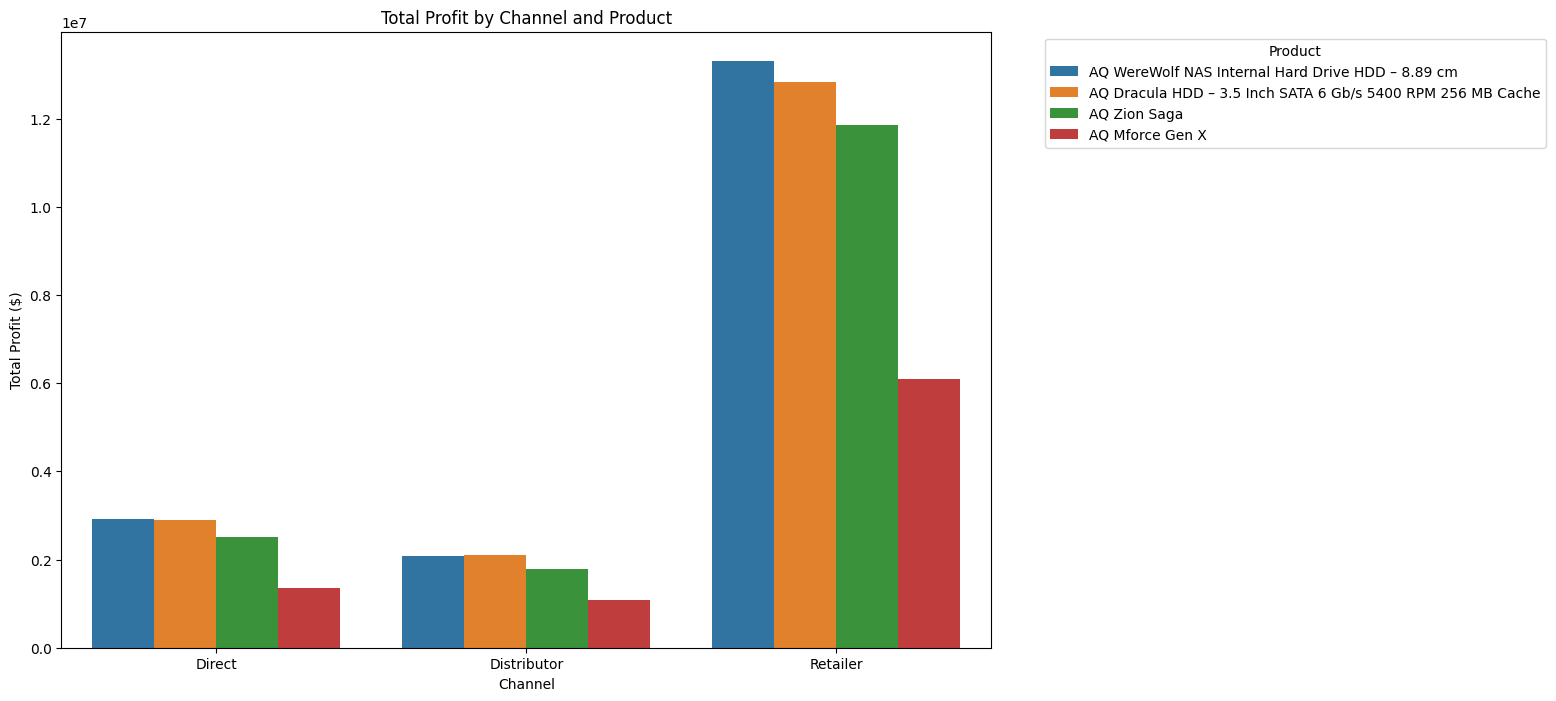

In [106]:
# Plotting Total Profit by Channel and Product
plt.figure(figsize=(12, 8))
sns.barplot(x='channel', y='total_profit', hue='product', data=channel_sales_performance_by_product, ci=None)
plt.title('Total Profit by Channel and Product')
plt.ylabel('Total Profit ($)')
plt.xlabel('Channel')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Based on the market segmentation analysis, it was observed that products sold through the retailer channel have higher profitability compared to those sold through the direct and distributor channels. This indicates that the retailer channel may offer better profit margins, possibly due to economies of scale, favorable retail partnerships, or effective marketing strategies that enhance product visibility and sales.

**Hypothesis 4: Sales of 'Networking' products have increased over the past three years due to rising demand for home office setups.**

In our sales data, there are no products in the networking segment; the only segment represented is Peripherals. We will examine the sales trends to determine if there has been an increase in sales within this segment.

In [107]:
# Filtering the DataFrame to include only the last three years
filtered_yearly_data = yearly_trend_analysis[yearly_trend_analysis['year'].isin([2022, 2021, 2020])]

# Selecting only the columns for year and total revenue
filtered_yearly_data = filtered_yearly_data[['year', 'total_revenue']]

filtered_yearly_data

,year,total_revenue
0,2022,39136207.36
1,2021,24661170.06
2,2020,13172917.14


As we can see, the total revenue nearly tripled from 2020 to 2022. This significant increase indicates strong growth in sales for the Peripherals segment during this period.

**Hypothesis 5: Sales trends show significant seasonal variations, with peaks during 
holiday seasons.**

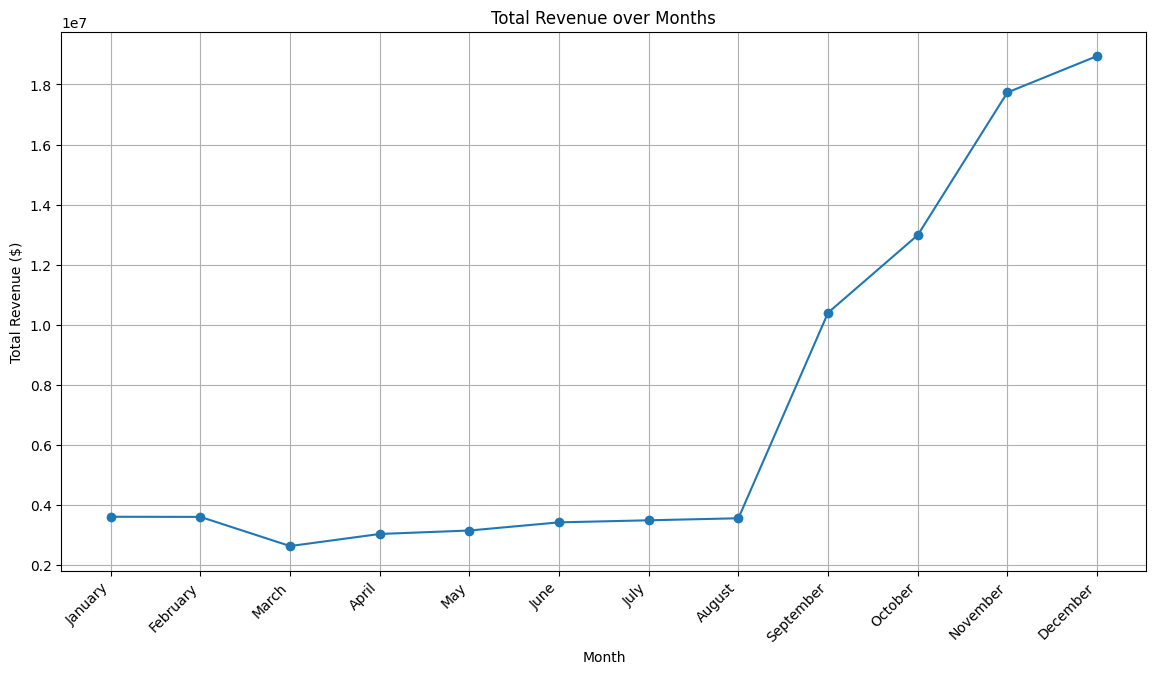

In [108]:
# Plotting Total Revenue over Months
plt.figure(figsize=(14, 7))
plt.plot(monthly_trend_analysis['month_name'], monthly_trend_analysis['total_revenue'], marker='o')
plt.title('Total Revenue over Months')
plt.xlabel('Month')
plt.ylabel('Total Revenue ($)')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.show()

Month 12 (December) shows the highest sales volume and revenue, which may indicate a seasonal peak, possibly due to year-end holidays or end-of-year purchases.Months 11 (November) and 10 (October) also show significant sales, suggesting a possible buildup towards the holiday season.

**6. Hypotheses 6 :The North American market generates the highest revenue compared to other regions.**

In [109]:
# Selecting only the columns for region and total revenue
region_sales_performance = region_sales_performance[['region','total_revenue']]

region_sales_performance

,region,total_revenue
0,APAC,48756126.00
1,EU,18938556.91
2,NA,18434348.76
3,LATAM,426877.38


As observed, the APAC region generates the highest revenue for AtliQ Hardware's.

**Hypothesis 7: Customers in the 'Retailer' channel purchase a wider variety of products compared to 'Direct' and 'Distributor' channels.**

In [110]:
# Grouping by channel and counting the number of unique products in each channel
channel_product_variety = channel_sales_performance_by_product.groupby('channel').agg(
    unique_products=('product', 'nunique')
).reset_index()

# Sorting the results by the number of unique products in descending order
channel_product_variety = channel_product_variety.sort_values(by='unique_products', ascending=False)

# Displaying the result
channel_product_variety

,channel,unique_products
0,Direct,4
1,Distributor,4
2,Retailer,4


As observed, each channel has sold the same quantity of 4 products. This uniform distribution indicates that there is an equal representation of product purchases across the different channels, suggesting balanced channel penetration.

## Stage 7. Summary and Suggestions<a id='summary'></a>

Throughout this analysis, we systematically examined AtliQ Hardware's sales data to identify key insights and recommendations for improving business performance. Our work began with a thorough **Data Overview and Preprocessing** stage, where we ensured data completeness, accuracy, and consistency by addressing missing values and standardizing entries. This foundational work was crucial for generating reliable insights.

**Bestsellers Analysis** revealed that Internal HDDs vastly outperform Graphic Cards, accounting for significant revenue and unit sales. Notably, the "AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache" led in sales volume, while the "AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm" stood out in revenue, highlighting a strong market position. The AQ Zion Saga and AQ Mforce Gen X lines also showed promising performance, suggesting a well-diversified product portfolio. However, some variants underperformed, indicating potential areas for increased marketing focus.

**Sales Improvement Analysis** indicated a uniform discount policy across AtliQ's products, which appears not to significantly impact sales volumes. This lack of correlation suggests other factors are at play in influencing purchasing decisions. The AQ Zion Saga's high profit margins and profitability underscore successful premium pricing strategies. In contrast, the AQ Dracula line's lower total profit, despite reasonable margins, suggests a need for strategic reassessment.

**Popularity Trends Analysis** highlighted significant growth for new products like the AQ Zion Saga and AQ WereWolf NAS Internal Hard Drive HDD. Conversely, the AQ Dracula HDD showed a decline, particularly after discontinuing less popular variants. Seasonal trends revealed peak sales in December, with a notable dip in March and April, emphasizing the importance of timing in sales strategies.

**Segment Analysis** underscored the dominance of the retailer channel and Brick & Mortar platform, with the AQ WereWolf line consistently achieving the highest profits and sales volumes. The APAC region emerged as the strongest market, with the EU and NA regions performing comparably. However, the LATAM region underperformed, indicating a potential area for growth.

### Recommendations

- **Adjust Discount Strategies**: Customize discounts to stimulate sales for underperforming items, such as the AQ Dracula HDD Premium and Premium Plus variants.

- **Strategic Timing**: Utilize peak seasons, particularly December, for major promotions, while employing targeted discounts during off-peak months like March and April to maintain consistent sales momentum.

- **Enhance LATAM Presence**: Implement targeted marketing strategies and localized offerings to increase engagement and market share in the LATAM region.

- **Leverage Brick & Mortar Success**: Continue to capitalize on this channel by enhancing in-store promotions, improving product placements, and offering exclusive deals to boost sales.

- **Regional Marketing Focus**: Tailor marketing campaigns to regional preferences, promoting AQ Zion Saga and AQ Mforce Gen X to optimize sales.

Optimize Product Line Strategies:

- **AQ WereWolf**: Consider expanding this successful line with new variants to sustain strong customer interest. Introducing innovative features or targeting new customer segments can help maintain and grow market share.

- **AQ Dracula**: Reevaluate the product line's positioning and explore strategies to improve profitability, possibly by reintroducing previously successful variants or refining the features of existing ones to better meet market demands.

- **AQ Zion Saga**: Continue to leverage the strong market reception of this line. Consider launching additional premium variants or bundling options to capitalize on its popularity and high profit margins.

- **AQ Mforce Gen X**: Build on the recent growth by introducing new models or enhancing existing ones. Focus on highlighting the unique aspects of this line through targeted marketing campaigns to further increase its appeal and sales.

## Creating a comprehensive dataset for Tableau

In [111]:
query = """
SELECT
    fsm.date,
    fsm.fiscal_year,
    strftime('%m', fsm.date) AS month_number,
    fsm.product_code,
    fsm.customer_code,
    dp.product,
    dp.variant,
    dp.division,  
    dp.category,  
    dp.segment,
    fsm.sold_quantity
FROM
    (SELECT 
        date(date) AS date,  
        product_code,
        customer_code,
        sold_quantity,
        fiscal_year
     FROM 
        Fact_sales_monthly
     WHERE
        date IS NOT NULL AND
        product_code IS NOT NULL AND
        customer_code IS NOT NULL AND
        sold_quantity IS NOT NULL AND
        fiscal_year IS NOT NULL) fsm
INNER JOIN
    (SELECT
        product_code,
        TRIM(product) AS product,
        division,  
        category,
        segment,
        TRIM(variant) AS variant
     FROM 
        dim_product) dp ON fsm.product_code = dp.product_code
ORDER BY
    fsm.date, fsm.product_code;
"""

comprehensive_dataset_2 = pd.read_sql_query(query, con)
comprehensive_dataset_2

,date,fiscal_year,month_number,product_code,customer_code,product,variant,division,category,segment,sold_quantity
0,2017-09-01,2018,09,A0118150101,70002017,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,51
1,2017-09-01,2018,09,A0118150101,70002018,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,77
2,2017-09-01,2018,09,A0118150101,70003181,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,17
3,2017-09-01,2018,09,A0118150101,70003182,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,6
4,2017-09-01,2018,09,A0118150101,70006157,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,5
...,...,...,...,...,...,...,...,...,...,...,...
67245,2021-12-01,2022,12,A0418150103,90023028,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,168
67246,2021-12-01,2022,12,A0418150103,90023030,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,545
67247,2021-12-01,2022,12,A0418150103,90024183,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,38
67248,2021-12-01,2022,12,A0418150103,90024184,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,51


In [112]:
# Performing the join
merge_2 = comprehensive_dataset_2.merge(dim_customer_filtered, on='customer_code', how='inner')
merge_2

,date,fiscal_year,month_number,product_code,customer_code,product,variant,division,category,segment,sold_quantity,customer,platform,channel,market,sub_zone,region
0,2017-09-01,2018,09,A0118150101,70002017,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,51,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
1,2017-09-01,2018,09,A0118150102,70002017,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Plus,P & A,Internal HDD,Peripherals,77,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
2,2017-09-01,2018,09,A0118150103,70002017,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Premium,P & A,Internal HDD,Peripherals,54,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
3,2017-09-01,2018,09,A0118150104,70002017,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Premium Plus,P & A,Internal HDD,Peripherals,42,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
4,2017-09-01,2018,09,A0418150101,70002017,AQ Mforce Gen X,Standard 1,P & A,Graphic Card,Peripherals,67,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67245,2021-12-01,2022,12,A0220150203,90024184,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Premium,P & A,Internal HDD,Peripherals,38,Amazon,E-Commerce,Retailer,Chile,LATAM,LATAM
67246,2021-12-01,2022,12,A0320150301,90024184,AQ Zion Saga,Standard,P & A,Internal HDD,Peripherals,12,Amazon,E-Commerce,Retailer,Chile,LATAM,LATAM
67247,2021-12-01,2022,12,A0321150302,90024184,AQ Zion Saga,Plus,P & A,Internal HDD,Peripherals,22,Amazon,E-Commerce,Retailer,Chile,LATAM,LATAM
67248,2021-12-01,2022,12,A0321150303,90024184,AQ Zion Saga,Premium,P & A,Internal HDD,Peripherals,23,Amazon,E-Commerce,Retailer,Chile,LATAM,LATAM


In [113]:
# Performing the join
merge_3 = merge_2.merge(Fact_pre_discount, on=['customer_code', 'fiscal_year'], how='inner')
merge_3

,date,fiscal_year,month_number,product_code,customer_code,product,variant,division,category,segment,sold_quantity,customer,platform,channel,market,sub_zone,region,pre_invoice_discount_pct
0,2017-09-01,2018,09,A0118150101,70002017,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,51,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,0.0824
1,2017-09-01,2018,09,A0118150102,70002017,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Plus,P & A,Internal HDD,Peripherals,77,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,0.0824
2,2017-09-01,2018,09,A0118150103,70002017,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Premium,P & A,Internal HDD,Peripherals,54,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,0.0824
3,2017-09-01,2018,09,A0118150104,70002017,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Premium Plus,P & A,Internal HDD,Peripherals,42,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,0.0824
4,2017-09-01,2018,09,A0418150101,70002017,AQ Mforce Gen X,Standard 1,P & A,Graphic Card,Peripherals,67,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,0.0824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67245,2021-12-01,2022,12,A0220150203,90024184,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Premium,P & A,Internal HDD,Peripherals,38,Amazon,E-Commerce,Retailer,Chile,LATAM,LATAM,0.2453
67246,2021-12-01,2022,12,A0320150301,90024184,AQ Zion Saga,Standard,P & A,Internal HDD,Peripherals,12,Amazon,E-Commerce,Retailer,Chile,LATAM,LATAM,0.2453
67247,2021-12-01,2022,12,A0321150302,90024184,AQ Zion Saga,Plus,P & A,Internal HDD,Peripherals,22,Amazon,E-Commerce,Retailer,Chile,LATAM,LATAM,0.2453
67248,2021-12-01,2022,12,A0321150303,90024184,AQ Zion Saga,Premium,P & A,Internal HDD,Peripherals,23,Amazon,E-Commerce,Retailer,Chile,LATAM,LATAM,0.2453


In [114]:
# Performing the join
dataset_for_tableau = merge_3.merge(pricing_dataset, on=['product_code', 'fiscal_year'], how='inner')
dataset_for_tableau

,date,fiscal_year,month_number,product_code,customer_code,product,variant,division,category,segment,...,customer,platform,channel,market,sub_zone,region,pre_invoice_discount_pct,gross_price,manufacturing_cost,profit_margin
0,2017-09-01,2018,09,A0118150101,70002017,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,...,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,0.0824,15.3952,4.6190,10.7762
1,2017-10-01,2018,10,A0118150101,70002017,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,...,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,0.0824,15.3952,4.6190,10.7762
2,2017-11-01,2018,11,A0118150101,70002017,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,...,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,0.0824,15.3952,4.6190,10.7762
3,2018-01-01,2018,01,A0118150101,70002017,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,...,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,0.0824,15.3952,4.6190,10.7762
4,2018-02-01,2018,02,A0118150101,70002017,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM 256 MB Cache,Standard,P & A,Internal HDD,Peripherals,...,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,0.0824,15.3952,4.6190,10.7762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67245,2021-11-01,2022,11,A0418150103,90020100,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,...,Nova,Brick & Mortar,Retailer,Austria,NE,EU,0.2633,21.0913,6.0345,15.0568
67246,2021-12-01,2022,12,A0418150103,90020100,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,...,Nova,Brick & Mortar,Retailer,Austria,NE,EU,0.2633,21.0913,6.0345,15.0568
67247,2021-10-01,2022,10,A0418150103,90024184,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,...,Amazon,E-Commerce,Retailer,Chile,LATAM,LATAM,0.2453,21.0913,6.0345,15.0568
67248,2021-11-01,2022,11,A0418150103,90024184,AQ Mforce Gen X,Standard 3,P & A,Graphic Card,Peripherals,...,Amazon,E-Commerce,Retailer,Chile,LATAM,LATAM,0.2453,21.0913,6.0345,15.0568


In [115]:
# Saving the final merged dataset to a CSV file
dataset_for_tableau.to_csv('dataset_for_tableau.csv', index=False)

**A link to my dashboard in Tableau**

https://public.tableau.com/views/Finalproject_17228444272390/Dashboard2?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link